In [1]:
!python -V

Python 3.9.12


In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import mlflow

In [2]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-course/02-experiment-tracking/mlruns/1', creation_time=1717606406714, experiment_id='1', last_update_time=1717606406714, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = pd.to_datetime(df.lpep_dropoff_datetime) - pd.to_datetime(df.lpep_pickup_datetime)
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

df = df[((df.duration >= 1) & (df.duration <= 60))]

categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [4]:
train_dicts = df[categorical + numerical].to_dict(orient = 'records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared = False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829577

/tmp/ipykernel_23461/4107668193.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = 'prediction')
/tmp/ipykernel_23461/4107668193.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label = 'actual')


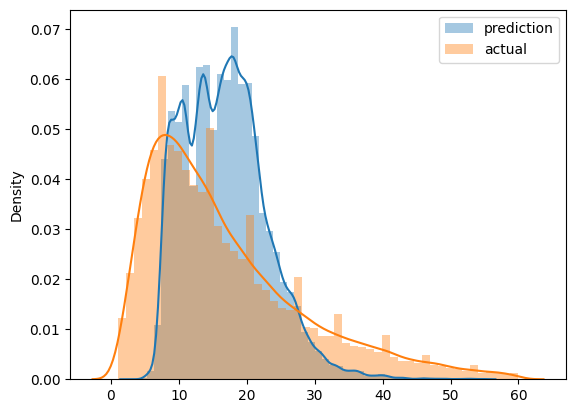

In [5]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()

In [6]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = pd.to_datetime(df.lpep_dropoff_datetime) - pd.to_datetime(df.lpep_pickup_datetime)
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

    df = df[((df.duration >= 1) & (df.duration <= 60))]

    categorical = ['PULocationID','DOLocationID']
    #numerical = ['trip_distance']

    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [8]:
df_train['PU_DO'] = df_train['PULocationID']+'_'+df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID']+'_'+df_val['DOLocationID']

In [9]:
categorical = ['PU_DO']#['PULocationID','DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

In [10]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared = False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715209663881

In [16]:
with mlflow.start_run():
    
    alpha = 0.01
    
    mlflow.set_tag("developer", "ilya")
    
    mlflow.log_param("train-data-path", './data/green_tripdata_2021-01.parquet')
    mlflow.log_param("validation-data-path", './data/green_tripdata_2021-02.parquet')
    mlflow.log_param("alpha", alpha)
    
    
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    mse = mean_squared_error(y_val, y_pred, squared = False)
    mlflow.log_metric("mse", mse)

In [18]:
!pip install hyperopt

     |████████████████████████████████| 1.6 MB 19.1 MB/s eta 0:00:01
     |████████████████████████████████| 200 kB 71.8 MB/s eta 0:00:01


In [13]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [11]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [22]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                    | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:18:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.13465                                                                    
[1]	validation-rmse:10.24421                                                                    
[2]	validation-rmse:9.51493                                                                     
[3]	validation-rmse:8.92228                                                                     
[4]	validation-rmse:8.44332                                                                     
[5]	validation-rmse:8.05893                                                                     
[6]	validation-rmse:7.75194                                                                     
[7]	validation-rmse:7.50654                                                                     
[8]	validation-rmse:7.31321                                                                     
[9]	validation-rmse:7.16022                                                                     
[10]	validation-rmse:7.03915  

[84]	validation-rmse:6.45958                                                                    
[85]	validation-rmse:6.45906                                                                    
[86]	validation-rmse:6.45850                                                                    
[87]	validation-rmse:6.45793                                                                    
[88]	validation-rmse:6.45751                                                                    
[89]	validation-rmse:6.45679                                                                    
[90]	validation-rmse:6.45614                                                                    
[91]	validation-rmse:6.45589                                                                    
[92]	validation-rmse:6.45553                                                                    
[93]	validation-rmse:6.45488                                                                    
[94]	validation-rmse:6.45407  

[168]	validation-rmse:6.42874                                                                   
[169]	validation-rmse:6.42866                                                                   
[170]	validation-rmse:6.42837                                                                   
[171]	validation-rmse:6.42806                                                                   
[172]	validation-rmse:6.42789                                                                   
[173]	validation-rmse:6.42726                                                                   
[174]	validation-rmse:6.42706                                                                   
[175]	validation-rmse:6.42689                                                                   
[176]	validation-rmse:6.42666                                                                   
[177]	validation-rmse:6.42658                                                                   
[178]	validation-rmse:6.42636 

[252]	validation-rmse:6.41177                                                                   
[253]	validation-rmse:6.41171                                                                   
[254]	validation-rmse:6.41162                                                                   
[255]	validation-rmse:6.41142                                                                   
[256]	validation-rmse:6.41130                                                                   
[257]	validation-rmse:6.41118                                                                   
[258]	validation-rmse:6.41104                                                                   
[259]	validation-rmse:6.41082                                                                   
[260]	validation-rmse:6.41069                                                                   
[261]	validation-rmse:6.41045                                                                   
[262]	validation-rmse:6.41040 

[336]	validation-rmse:6.40337                                                                   
[337]	validation-rmse:6.40327                                                                   
[338]	validation-rmse:6.40329                                                                   
[339]	validation-rmse:6.40304                                                                   
[340]	validation-rmse:6.40270                                                                   
[341]	validation-rmse:6.40273                                                                   
[342]	validation-rmse:6.40267                                                                   
[343]	validation-rmse:6.40268                                                                   
[344]	validation-rmse:6.40259                                                                   
[345]	validation-rmse:6.40261                                                                   
[346]	validation-rmse:6.40241 

[420]	validation-rmse:6.39675                                                                   
[421]	validation-rmse:6.39666                                                                   
[422]	validation-rmse:6.39668                                                                   
[423]	validation-rmse:6.39664                                                                   
[424]	validation-rmse:6.39670                                                                   
[425]	validation-rmse:6.39670                                                                   
[426]	validation-rmse:6.39667                                                                   
[427]	validation-rmse:6.39647                                                                   
[428]	validation-rmse:6.39626                                                                   
[429]	validation-rmse:6.39620                                                                   
[430]	validation-rmse:6.39609 

[504]	validation-rmse:6.39202                                                                   
[505]	validation-rmse:6.39189                                                                   
[506]	validation-rmse:6.39193                                                                   
[507]	validation-rmse:6.39171                                                                   
[508]	validation-rmse:6.39178                                                                   
[509]	validation-rmse:6.39166                                                                   
[510]	validation-rmse:6.39173                                                                   
[511]	validation-rmse:6.39147                                                                   
[512]	validation-rmse:6.39138                                                                   
[513]	validation-rmse:6.39137                                                                   
[514]	validation-rmse:6.39133 

[588]	validation-rmse:6.38799                                                                   
[589]	validation-rmse:6.38788                                                                   
[590]	validation-rmse:6.38784                                                                   
[591]	validation-rmse:6.38765                                                                   
[592]	validation-rmse:6.38762                                                                   
[593]	validation-rmse:6.38741                                                                   
[594]	validation-rmse:6.38727                                                                   
[595]	validation-rmse:6.38715                                                                   
[596]	validation-rmse:6.38719                                                                   
[597]	validation-rmse:6.38724                                                                   
[598]	validation-rmse:6.38732 

[672]	validation-rmse:6.38391                                                                   
[673]	validation-rmse:6.38379                                                                   
[674]	validation-rmse:6.38382                                                                   
[675]	validation-rmse:6.38381                                                                   
[676]	validation-rmse:6.38371                                                                   
[677]	validation-rmse:6.38370                                                                   
[678]	validation-rmse:6.38361                                                                   
[679]	validation-rmse:6.38373                                                                   
[680]	validation-rmse:6.38370                                                                   
[681]	validation-rmse:6.38367                                                                   
[682]	validation-rmse:6.38359 

[756]	validation-rmse:6.38254                                                                   
[757]	validation-rmse:6.38241                                                                   
[758]	validation-rmse:6.38240                                                                   
[759]	validation-rmse:6.38225                                                                   
[760]	validation-rmse:6.38210                                                                   
[761]	validation-rmse:6.38213                                                                   
[762]	validation-rmse:6.38212                                                                   
[763]	validation-rmse:6.38203                                                                   
[764]	validation-rmse:6.38197                                                                   
[765]	validation-rmse:6.38193                                                                   
[766]	validation-rmse:6.38186 

[840]	validation-rmse:6.38034                                                                   
[841]	validation-rmse:6.38034                                                                   
[842]	validation-rmse:6.38028                                                                   
[843]	validation-rmse:6.38020                                                                   
[844]	validation-rmse:6.38015                                                                   
[845]	validation-rmse:6.38013                                                                   
[846]	validation-rmse:6.38017                                                                   
[847]	validation-rmse:6.38010                                                                   
[848]	validation-rmse:6.38012                                                                   
[849]	validation-rmse:6.38007                                                                   
[850]	validation-rmse:6.38000 

[924]	validation-rmse:6.37694                                                                   
[925]	validation-rmse:6.37684                                                                   
[926]	validation-rmse:6.37684                                                                   
[927]	validation-rmse:6.37673                                                                   
[928]	validation-rmse:6.37672                                                                   
[929]	validation-rmse:6.37658                                                                   
[930]	validation-rmse:6.37657                                                                   
[931]	validation-rmse:6.37649                                                                   
[932]	validation-rmse:6.37648                                                                   
[933]	validation-rmse:6.37642                                                                   
[934]	validation-rmse:6.37634 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:21:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.82218                                                                     
[1]	validation-rmse:6.67866                                                                     
[2]	validation-rmse:6.66614                                                                     
[3]	validation-rmse:6.65600                                                                     
[4]	validation-rmse:6.65268                                                                     
[5]	validation-rmse:6.64315                                                                     
[6]	validation-rmse:6.63026                                                                     
[7]	validation-rmse:6.62443                                                                     
[8]	validation-rmse:6.61366                                                                     
[9]	validation-rmse:6.61306                                                                     
[10]	validation-rmse:6.61173  

[84]	validation-rmse:6.45492                                                                    
[85]	validation-rmse:6.45276                                                                    
[86]	validation-rmse:6.45229                                                                    
[87]	validation-rmse:6.45260                                                                    
[88]	validation-rmse:6.45176                                                                    
[89]	validation-rmse:6.45170                                                                    
[90]	validation-rmse:6.45322                                                                    
[91]	validation-rmse:6.44988                                                                    
[92]	validation-rmse:6.44803                                                                    
[93]	validation-rmse:6.44519                                                                    
[94]	validation-rmse:6.44429  

[168]	validation-rmse:6.40810                                                                   
[169]	validation-rmse:6.40718                                                                   
[170]	validation-rmse:6.40741                                                                   
[171]	validation-rmse:6.40733                                                                   
[172]	validation-rmse:6.40770                                                                   
[173]	validation-rmse:6.40770                                                                   
[174]	validation-rmse:6.40929                                                                   
[175]	validation-rmse:6.40854                                                                   
[176]	validation-rmse:6.40947                                                                   
[177]	validation-rmse:6.40939                                                                   
[178]	validation-rmse:6.41002 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:21:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.62495                                                                     
[1]	validation-rmse:7.33077                                                                     
[2]	validation-rmse:6.89717                                                                     
[3]	validation-rmse:6.73958                                                                     
[4]	validation-rmse:6.67004                                                                     
[5]	validation-rmse:6.63415                                                                     
[6]	validation-rmse:6.61197                                                                     
[7]	validation-rmse:6.60554                                                                     
[8]	validation-rmse:6.59834                                                                     
[9]	validation-rmse:6.59374                                                                     
[10]	validation-rmse:6.58995  

[84]	validation-rmse:6.47112                                                                    
[85]	validation-rmse:6.47047                                                                    
[86]	validation-rmse:6.47048                                                                    
[87]	validation-rmse:6.46850                                                                    
[88]	validation-rmse:6.46817                                                                    
[89]	validation-rmse:6.46791                                                                    
[90]	validation-rmse:6.46719                                                                    
[91]	validation-rmse:6.46756                                                                    
[92]	validation-rmse:6.46689                                                                    
[93]	validation-rmse:6.46665                                                                    
[94]	validation-rmse:6.46529  

[168]	validation-rmse:6.44845                                                                   
[169]	validation-rmse:6.44810                                                                   
[170]	validation-rmse:6.44837                                                                   
[171]	validation-rmse:6.44852                                                                   
[172]	validation-rmse:6.44962                                                                   
[173]	validation-rmse:6.45031                                                                   
[174]	validation-rmse:6.45120                                                                   
[175]	validation-rmse:6.45109                                                                   
[176]	validation-rmse:6.45050                                                                   
[177]	validation-rmse:6.45028                                                                   
[178]	validation-rmse:6.45051 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:22:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.10299                                                                    
[1]	validation-rmse:8.74568                                                                     
[2]	validation-rmse:7.89650                                                                     
[3]	validation-rmse:7.38566                                                                     
[4]	validation-rmse:7.07240                                                                     
[5]	validation-rmse:6.88181                                                                     
[6]	validation-rmse:6.76318                                                                     
[7]	validation-rmse:6.68741                                                                     
[8]	validation-rmse:6.63574                                                                     
[9]	validation-rmse:6.59934                                                                     
[10]	validation-rmse:6.57677  

[84]	validation-rmse:6.41273                                                                    
[85]	validation-rmse:6.41206                                                                    
[86]	validation-rmse:6.41152                                                                    
[87]	validation-rmse:6.41023                                                                    
[88]	validation-rmse:6.40964                                                                    
[89]	validation-rmse:6.40855                                                                    
[90]	validation-rmse:6.40776                                                                    
[91]	validation-rmse:6.40727                                                                    
[92]	validation-rmse:6.40617                                                                    
[93]	validation-rmse:6.40568                                                                    
[94]	validation-rmse:6.40519  

[168]	validation-rmse:6.36045                                                                   
[169]	validation-rmse:6.36074                                                                   
[170]	validation-rmse:6.36046                                                                   
[171]	validation-rmse:6.35994                                                                   
[172]	validation-rmse:6.35976                                                                   
[173]	validation-rmse:6.35958                                                                   
[174]	validation-rmse:6.35943                                                                   
[175]	validation-rmse:6.35908                                                                   
[176]	validation-rmse:6.35864                                                                   
[177]	validation-rmse:6.35851                                                                   
[178]	validation-rmse:6.35880 

[252]	validation-rmse:6.33795                                                                   
[253]	validation-rmse:6.33816                                                                   
[254]	validation-rmse:6.33799                                                                   
[255]	validation-rmse:6.33781                                                                   
[256]	validation-rmse:6.33678                                                                   
[257]	validation-rmse:6.33663                                                                   
[258]	validation-rmse:6.33658                                                                   
[259]	validation-rmse:6.33636                                                                   
[260]	validation-rmse:6.33640                                                                   
[261]	validation-rmse:6.33641                                                                   
[262]	validation-rmse:6.33601 

[336]	validation-rmse:6.32502                                                                   
[337]	validation-rmse:6.32511                                                                   
[338]	validation-rmse:6.32526                                                                   
[339]	validation-rmse:6.32524                                                                   
[340]	validation-rmse:6.32496                                                                   
[341]	validation-rmse:6.32439                                                                   
[342]	validation-rmse:6.32439                                                                   
[343]	validation-rmse:6.32426                                                                   
[344]	validation-rmse:6.32399                                                                   
[345]	validation-rmse:6.32315                                                                   
[346]	validation-rmse:6.32310 

[420]	validation-rmse:6.31984                                                                   
[421]	validation-rmse:6.31937                                                                   
[422]	validation-rmse:6.31943                                                                   
[423]	validation-rmse:6.31919                                                                   
[424]	validation-rmse:6.31931                                                                   
[425]	validation-rmse:6.31946                                                                   
[426]	validation-rmse:6.31920                                                                   
[427]	validation-rmse:6.31923                                                                   
[428]	validation-rmse:6.31889                                                                   
[429]	validation-rmse:6.31896                                                                   
[430]	validation-rmse:6.31895 

[504]	validation-rmse:6.31422                                                                   
[505]	validation-rmse:6.31409                                                                   
[506]	validation-rmse:6.31396                                                                   
[507]	validation-rmse:6.31414                                                                   
[508]	validation-rmse:6.31419                                                                   
[509]	validation-rmse:6.31437                                                                   
[510]	validation-rmse:6.31463                                                                   
[511]	validation-rmse:6.31453                                                                   
[512]	validation-rmse:6.31477                                                                   
[513]	validation-rmse:6.31374                                                                   
[514]	validation-rmse:6.31322 

[588]	validation-rmse:6.31167                                                                   
[589]	validation-rmse:6.31158                                                                   
[590]	validation-rmse:6.31176                                                                   
[591]	validation-rmse:6.31189                                                                   
[592]	validation-rmse:6.31202                                                                   
[593]	validation-rmse:6.31213                                                                   
[594]	validation-rmse:6.31209                                                                   
[595]	validation-rmse:6.31188                                                                   
[596]	validation-rmse:6.31172                                                                   
[597]	validation-rmse:6.31169                                                                   
[598]	validation-rmse:6.31159 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:24:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.88919                                                                    
[1]	validation-rmse:9.84663                                                                     
[2]	validation-rmse:9.03559                                                                     
[3]	validation-rmse:8.40935                                                                     
[4]	validation-rmse:7.93417                                                                     
[5]	validation-rmse:7.57426                                                                     
[6]	validation-rmse:7.30374                                                                     
[7]	validation-rmse:7.10253                                                                     
[8]	validation-rmse:6.95107                                                                     
[9]	validation-rmse:6.83883                                                                     
[10]	validation-rmse:6.74897  

[84]	validation-rmse:6.36480                                                                    
[85]	validation-rmse:6.36441                                                                    
[86]	validation-rmse:6.36413                                                                    
[87]	validation-rmse:6.36366                                                                    
[88]	validation-rmse:6.36300                                                                    
[89]	validation-rmse:6.36264                                                                    
[90]	validation-rmse:6.36240                                                                    
[91]	validation-rmse:6.36204                                                                    
[92]	validation-rmse:6.36173                                                                    
[93]	validation-rmse:6.36170                                                                    
[94]	validation-rmse:6.36136  

[168]	validation-rmse:6.34410                                                                   
[169]	validation-rmse:6.34386                                                                   
[170]	validation-rmse:6.34395                                                                   
[171]	validation-rmse:6.34364                                                                   
[172]	validation-rmse:6.34332                                                                   
[173]	validation-rmse:6.34318                                                                   
[174]	validation-rmse:6.34305                                                                   
[175]	validation-rmse:6.34280                                                                   
[176]	validation-rmse:6.34263                                                                   
[177]	validation-rmse:6.34239                                                                   
[178]	validation-rmse:6.34264 

[252]	validation-rmse:6.33414                                                                   
[253]	validation-rmse:6.33414                                                                   
[254]	validation-rmse:6.33419                                                                   
[255]	validation-rmse:6.33416                                                                   
[256]	validation-rmse:6.33435                                                                   
[257]	validation-rmse:6.33421                                                                   
[258]	validation-rmse:6.33393                                                                   
[259]	validation-rmse:6.33361                                                                   
[260]	validation-rmse:6.33375                                                                   
[261]	validation-rmse:6.33362                                                                   
[262]	validation-rmse:6.33391 

[336]	validation-rmse:6.33203                                                                   
[337]	validation-rmse:6.33208                                                                   
[338]	validation-rmse:6.33217                                                                   
[339]	validation-rmse:6.33209                                                                   
[340]	validation-rmse:6.33227                                                                   
[341]	validation-rmse:6.33230                                                                   
[342]	validation-rmse:6.33212                                                                   
[343]	validation-rmse:6.33222                                                                   
[344]	validation-rmse:6.33215                                                                   
[345]	validation-rmse:6.33218                                                                   
[346]	validation-rmse:6.33214 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:27:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.88238                                                                     
[1]	validation-rmse:8.47138                                                                     
[2]	validation-rmse:7.65024                                                                     
[3]	validation-rmse:7.18817                                                                     
[4]	validation-rmse:6.92589                                                                     
[5]	validation-rmse:6.77419                                                                     
[6]	validation-rmse:6.68560                                                                     
[7]	validation-rmse:6.62995                                                                     
[8]	validation-rmse:6.58975                                                                     
[9]	validation-rmse:6.56087                                                                     
[10]	validation-rmse:6.54336  

[84]	validation-rmse:6.44032                                                                    
[85]	validation-rmse:6.44024                                                                    
[86]	validation-rmse:6.43972                                                                    
[87]	validation-rmse:6.43958                                                                    
[88]	validation-rmse:6.43938                                                                    
[89]	validation-rmse:6.43909                                                                    
[90]	validation-rmse:6.43876                                                                    
[91]	validation-rmse:6.43888                                                                    
[92]	validation-rmse:6.43901                                                                    
[93]	validation-rmse:6.43805                                                                    
[94]	validation-rmse:6.43806  

[168]	validation-rmse:6.43249                                                                   
[169]	validation-rmse:6.43245                                                                   
[170]	validation-rmse:6.43228                                                                   
[171]	validation-rmse:6.43223                                                                   
[172]	validation-rmse:6.43177                                                                   
[173]	validation-rmse:6.43198                                                                   
[174]	validation-rmse:6.43159                                                                   
[175]	validation-rmse:6.43185                                                                   
[176]	validation-rmse:6.43161                                                                   
[177]	validation-rmse:6.43156                                                                   
[178]	validation-rmse:6.43125 

[252]	validation-rmse:6.43141                                                                   
[253]	validation-rmse:6.43136                                                                   
[254]	validation-rmse:6.43178                                                                   
[255]	validation-rmse:6.43167                                                                   
 12%|██▉                     | 6/50 [11:10<1:26:07, 117.43s/trial, best loss: 6.312134531284625]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:29:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.98567                                                                     
[1]	validation-rmse:7.55923                                                                     
[2]	validation-rmse:6.97030                                                                     
[3]	validation-rmse:6.72133                                                                     
[4]	validation-rmse:6.60693                                                                     
[5]	validation-rmse:6.55494                                                                     
[6]	validation-rmse:6.52611                                                                     
[7]	validation-rmse:6.50706                                                                     
[8]	validation-rmse:6.49773                                                                     
[9]	validation-rmse:6.48872                                                                     
[10]	validation-rmse:6.48402  

[84]	validation-rmse:6.35235                                                                    
[85]	validation-rmse:6.35272                                                                    
[86]	validation-rmse:6.35190                                                                    
[87]	validation-rmse:6.35192                                                                    
[88]	validation-rmse:6.35183                                                                    
[89]	validation-rmse:6.35154                                                                    
[90]	validation-rmse:6.35087                                                                    
[91]	validation-rmse:6.35046                                                                    
[92]	validation-rmse:6.34946                                                                    
[93]	validation-rmse:6.34932                                                                    
[94]	validation-rmse:6.34799  

[168]	validation-rmse:6.32862                                                                   
[169]	validation-rmse:6.32862                                                                   
[170]	validation-rmse:6.32861                                                                   
[171]	validation-rmse:6.32739                                                                   
[172]	validation-rmse:6.32775                                                                   
[173]	validation-rmse:6.32859                                                                   
[174]	validation-rmse:6.32855                                                                   
[175]	validation-rmse:6.32809                                                                   
[176]	validation-rmse:6.32814                                                                   
[177]	validation-rmse:6.32754                                                                   
[178]	validation-rmse:6.32761 

[252]	validation-rmse:6.32646                                                                   
[253]	validation-rmse:6.32726                                                                   
[254]	validation-rmse:6.32701                                                                   
[255]	validation-rmse:6.32675                                                                   
[256]	validation-rmse:6.32704                                                                   
[257]	validation-rmse:6.32700                                                                   
[258]	validation-rmse:6.32701                                                                   
[259]	validation-rmse:6.32703                                                                   
[260]	validation-rmse:6.32726                                                                   
[261]	validation-rmse:6.32703                                                                   
[262]	validation-rmse:6.32643 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:30:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.87088                                                                     
[1]	validation-rmse:6.75229                                                                     
[2]	validation-rmse:6.73969                                                                     
[3]	validation-rmse:6.73226                                                                     
[4]	validation-rmse:6.72313                                                                     
[5]	validation-rmse:6.71570                                                                     
[6]	validation-rmse:6.70504                                                                     
[7]	validation-rmse:6.70130                                                                     
[8]	validation-rmse:6.69769                                                                     
[9]	validation-rmse:6.69499                                                                     
[10]	validation-rmse:6.69139  

[84]	validation-rmse:6.61876                                                                    
[85]	validation-rmse:6.61878                                                                    
[86]	validation-rmse:6.61819                                                                    
[87]	validation-rmse:6.61846                                                                    
[88]	validation-rmse:6.61756                                                                    
[89]	validation-rmse:6.61762                                                                    
[90]	validation-rmse:6.61661                                                                    
[91]	validation-rmse:6.61648                                                                    
[92]	validation-rmse:6.61599                                                                    
[93]	validation-rmse:6.61661                                                                    
[94]	validation-rmse:6.61607  

[168]	validation-rmse:6.60749                                                                   
[169]	validation-rmse:6.60786                                                                   
[170]	validation-rmse:6.60849                                                                   
[171]	validation-rmse:6.60853                                                                   
[172]	validation-rmse:6.60849                                                                   
[173]	validation-rmse:6.60835                                                                   
[174]	validation-rmse:6.60843                                                                   
[175]	validation-rmse:6.60831                                                                   
[176]	validation-rmse:6.60766                                                                   
[177]	validation-rmse:6.60804                                                                   
[178]	validation-rmse:6.60785 

[252]	validation-rmse:6.60175                                                                   
[253]	validation-rmse:6.60163                                                                   
[254]	validation-rmse:6.60177                                                                   
[255]	validation-rmse:6.60192                                                                   
[256]	validation-rmse:6.60144                                                                   
[257]	validation-rmse:6.60162                                                                   
[258]	validation-rmse:6.60153                                                                   
[259]	validation-rmse:6.60178                                                                   
[260]	validation-rmse:6.60196                                                                   
[261]	validation-rmse:6.60153                                                                   
[262]	validation-rmse:6.60172 

[336]	validation-rmse:6.59505                                                                   
[337]	validation-rmse:6.59509                                                                   
[338]	validation-rmse:6.59491                                                                   
[339]	validation-rmse:6.59490                                                                   
[340]	validation-rmse:6.59489                                                                   
[341]	validation-rmse:6.59475                                                                   
[342]	validation-rmse:6.59500                                                                   
[343]	validation-rmse:6.59516                                                                   
[344]	validation-rmse:6.59496                                                                   
[345]	validation-rmse:6.59496                                                                   
[346]	validation-rmse:6.59497 

[420]	validation-rmse:6.59147                                                                   
[421]	validation-rmse:6.59180                                                                   
[422]	validation-rmse:6.59186                                                                   
[423]	validation-rmse:6.59154                                                                   
[424]	validation-rmse:6.59148                                                                   
[425]	validation-rmse:6.59143                                                                   
[426]	validation-rmse:6.59143                                                                   
[427]	validation-rmse:6.59152                                                                   
[428]	validation-rmse:6.59169                                                                   
[429]	validation-rmse:6.59179                                                                   
[430]	validation-rmse:6.59188 

[504]	validation-rmse:6.58871                                                                   
[505]	validation-rmse:6.58860                                                                   
[506]	validation-rmse:6.58833                                                                   
[507]	validation-rmse:6.58815                                                                   
[508]	validation-rmse:6.58831                                                                   
[509]	validation-rmse:6.58825                                                                   
[510]	validation-rmse:6.58826                                                                   
[511]	validation-rmse:6.58816                                                                   
[512]	validation-rmse:6.58827                                                                   
[513]	validation-rmse:6.58801                                                                   
[514]	validation-rmse:6.58808 

[588]	validation-rmse:6.58485                                                                   
[589]	validation-rmse:6.58481                                                                   
[590]	validation-rmse:6.58500                                                                   
[591]	validation-rmse:6.58478                                                                   
[592]	validation-rmse:6.58476                                                                   
[593]	validation-rmse:6.58476                                                                   
[594]	validation-rmse:6.58443                                                                   
[595]	validation-rmse:6.58429                                                                   
[596]	validation-rmse:6.58445                                                                   
[597]	validation-rmse:6.58425                                                                   
[598]	validation-rmse:6.58412 

[672]	validation-rmse:6.58316                                                                   
[673]	validation-rmse:6.58323                                                                   
[674]	validation-rmse:6.58302                                                                   
[675]	validation-rmse:6.58288                                                                   
[676]	validation-rmse:6.58285                                                                   
[677]	validation-rmse:6.58288                                                                   
[678]	validation-rmse:6.58283                                                                   
[679]	validation-rmse:6.58281                                                                   
[680]	validation-rmse:6.58273                                                                   
[681]	validation-rmse:6.58250                                                                   
[682]	validation-rmse:6.58250 

[756]	validation-rmse:6.58108                                                                   
[757]	validation-rmse:6.58122                                                                   
[758]	validation-rmse:6.58103                                                                   
[759]	validation-rmse:6.58112                                                                   
[760]	validation-rmse:6.58109                                                                   
[761]	validation-rmse:6.58109                                                                   
[762]	validation-rmse:6.58101                                                                   
[763]	validation-rmse:6.58108                                                                   
[764]	validation-rmse:6.58105                                                                   
[765]	validation-rmse:6.58106                                                                   
[766]	validation-rmse:6.58100 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:31:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.54812                                                                     
[1]	validation-rmse:8.07514                                                                     
[2]	validation-rmse:7.30088                                                                     
[3]	validation-rmse:6.90771                                                                     
[4]	validation-rmse:6.70342                                                                     
[5]	validation-rmse:6.59783                                                                     
[6]	validation-rmse:6.53556                                                                     
[7]	validation-rmse:6.49627                                                                     
[8]	validation-rmse:6.47219                                                                     
[9]	validation-rmse:6.45470                                                                     
[10]	validation-rmse:6.44321  

[84]	validation-rmse:6.34324                                                                    
[85]	validation-rmse:6.34232                                                                    
[86]	validation-rmse:6.34136                                                                    
[87]	validation-rmse:6.33971                                                                    
[88]	validation-rmse:6.33979                                                                    
[89]	validation-rmse:6.33973                                                                    
[90]	validation-rmse:6.34019                                                                    
[91]	validation-rmse:6.34003                                                                    
[92]	validation-rmse:6.34014                                                                    
[93]	validation-rmse:6.34021                                                                    
[94]	validation-rmse:6.33982  

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:32:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.27249                                                                     
[1]	validation-rmse:7.84389                                                                     
[2]	validation-rmse:7.19433                                                                     
[3]	validation-rmse:6.89965                                                                     
[4]	validation-rmse:6.76174                                                                     
[5]	validation-rmse:6.69435                                                                     
[6]	validation-rmse:6.65602                                                                     
[7]	validation-rmse:6.63229                                                                     
[8]	validation-rmse:6.61941                                                                     
[9]	validation-rmse:6.60862                                                                     
[10]	validation-rmse:6.60091  

[84]	validation-rmse:6.49510                                                                    
[85]	validation-rmse:6.49301                                                                    
[86]	validation-rmse:6.49233                                                                    
[87]	validation-rmse:6.49210                                                                    
[88]	validation-rmse:6.49097                                                                    
[89]	validation-rmse:6.49066                                                                    
[90]	validation-rmse:6.49029                                                                    
[91]	validation-rmse:6.49046                                                                    
[92]	validation-rmse:6.48993                                                                    
[93]	validation-rmse:6.48969                                                                    
[94]	validation-rmse:6.48945  

[168]	validation-rmse:6.46563                                                                   
[169]	validation-rmse:6.46560                                                                   
[170]	validation-rmse:6.46542                                                                   
[171]	validation-rmse:6.46549                                                                   
[172]	validation-rmse:6.46515                                                                   
[173]	validation-rmse:6.46522                                                                   
[174]	validation-rmse:6.46497                                                                   
[175]	validation-rmse:6.46499                                                                   
[176]	validation-rmse:6.46473                                                                   
[177]	validation-rmse:6.46465                                                                   
[178]	validation-rmse:6.46445 

[252]	validation-rmse:6.45696                                                                   
[253]	validation-rmse:6.45694                                                                   
[254]	validation-rmse:6.45679                                                                   
[255]	validation-rmse:6.45717                                                                   
[256]	validation-rmse:6.45707                                                                   
[257]	validation-rmse:6.45729                                                                   
[258]	validation-rmse:6.45718                                                                   
[259]	validation-rmse:6.45719                                                                   
[260]	validation-rmse:6.45690                                                                   
[261]	validation-rmse:6.45652                                                                   
[262]	validation-rmse:6.45637 

[336]	validation-rmse:6.45141                                                                   
[337]	validation-rmse:6.45103                                                                   
[338]	validation-rmse:6.45088                                                                   
[339]	validation-rmse:6.45099                                                                   
[340]	validation-rmse:6.45115                                                                   
[341]	validation-rmse:6.45109                                                                   
[342]	validation-rmse:6.45117                                                                   
[343]	validation-rmse:6.45107                                                                   
[344]	validation-rmse:6.45085                                                                   
[345]	validation-rmse:6.45075                                                                   
[346]	validation-rmse:6.45078 

[420]	validation-rmse:6.44858                                                                   
[421]	validation-rmse:6.44864                                                                   
[422]	validation-rmse:6.44860                                                                   
[423]	validation-rmse:6.44838                                                                   
[424]	validation-rmse:6.44818                                                                   
[425]	validation-rmse:6.44828                                                                   
[426]	validation-rmse:6.44816                                                                   
[427]	validation-rmse:6.44790                                                                   
[428]	validation-rmse:6.44808                                                                   
[429]	validation-rmse:6.44830                                                                   
[430]	validation-rmse:6.44828 

[504]	validation-rmse:6.44535                                                                   
[505]	validation-rmse:6.44550                                                                   
[506]	validation-rmse:6.44545                                                                   
[507]	validation-rmse:6.44555                                                                   
[508]	validation-rmse:6.44537                                                                   
[509]	validation-rmse:6.44547                                                                   
[510]	validation-rmse:6.44527                                                                   
[511]	validation-rmse:6.44526                                                                   
[512]	validation-rmse:6.44538                                                                   
[513]	validation-rmse:6.44498                                                                   
[514]	validation-rmse:6.44497 

[588]	validation-rmse:6.44439                                                                   
[589]	validation-rmse:6.44429                                                                   
[590]	validation-rmse:6.44437                                                                   
[591]	validation-rmse:6.44416                                                                   
[592]	validation-rmse:6.44403                                                                   
[593]	validation-rmse:6.44427                                                                   
[594]	validation-rmse:6.44418                                                                   
[595]	validation-rmse:6.44456                                                                   
[596]	validation-rmse:6.44433                                                                   
[597]	validation-rmse:6.44425                                                                   
[598]	validation-rmse:6.44454 

[672]	validation-rmse:6.44319                                                                   
[673]	validation-rmse:6.44362                                                                   
[674]	validation-rmse:6.44396                                                                   
[675]	validation-rmse:6.44374                                                                   
[676]	validation-rmse:6.44373                                                                   
[677]	validation-rmse:6.44368                                                                   
[678]	validation-rmse:6.44363                                                                   
[679]	validation-rmse:6.44361                                                                   
[680]	validation-rmse:6.44375                                                                   
[681]	validation-rmse:6.44386                                                                   
[682]	validation-rmse:6.44408 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:34:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.62512                                                                     
[1]	validation-rmse:7.30093                                                                     
[2]	validation-rmse:6.85045                                                                     
[3]	validation-rmse:6.68533                                                                     
[4]	validation-rmse:6.61787                                                                     
[5]	validation-rmse:6.58242                                                                     
[6]	validation-rmse:6.56545                                                                     
[7]	validation-rmse:6.55209                                                                     
[8]	validation-rmse:6.54273                                                                     
[9]	validation-rmse:6.53843                                                                     
[10]	validation-rmse:6.53447  

[84]	validation-rmse:6.44775                                                                    
[85]	validation-rmse:6.44734                                                                    
[86]	validation-rmse:6.44725                                                                    
[87]	validation-rmse:6.44661                                                                    
[88]	validation-rmse:6.44654                                                                    
[89]	validation-rmse:6.44673                                                                    
[90]	validation-rmse:6.44629                                                                    
[91]	validation-rmse:6.44579                                                                    
[92]	validation-rmse:6.44624                                                                    
[93]	validation-rmse:6.44602                                                                    
[94]	validation-rmse:6.44607  

[168]	validation-rmse:6.43443                                                                   
[169]	validation-rmse:6.43422                                                                   
[170]	validation-rmse:6.43423                                                                   
[171]	validation-rmse:6.43425                                                                   
[172]	validation-rmse:6.43461                                                                   
[173]	validation-rmse:6.43390                                                                   
[174]	validation-rmse:6.43414                                                                   
[175]	validation-rmse:6.43388                                                                   
[176]	validation-rmse:6.43369                                                                   
[177]	validation-rmse:6.43337                                                                   
[178]	validation-rmse:6.43361 

[252]	validation-rmse:6.42347                                                                   
[253]	validation-rmse:6.42320                                                                   
[254]	validation-rmse:6.42311                                                                   
[255]	validation-rmse:6.42322                                                                   
[256]	validation-rmse:6.42321                                                                   
[257]	validation-rmse:6.42326                                                                   
[258]	validation-rmse:6.42335                                                                   
[259]	validation-rmse:6.42336                                                                   
[260]	validation-rmse:6.42311                                                                   
[261]	validation-rmse:6.42332                                                                   
[262]	validation-rmse:6.42337 

[336]	validation-rmse:6.42504                                                                   
[337]	validation-rmse:6.42496                                                                   
[338]	validation-rmse:6.42490                                                                   
[339]	validation-rmse:6.42445                                                                   
[340]	validation-rmse:6.42451                                                                   
[341]	validation-rmse:6.42439                                                                   
[342]	validation-rmse:6.42379                                                                   
[343]	validation-rmse:6.42424                                                                   
[344]	validation-rmse:6.42416                                                                   
[345]	validation-rmse:6.42429                                                                   
[346]	validation-rmse:6.42407 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:35:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54912                                                                    
[1]	validation-rmse:10.95602                                                                    
[2]	validation-rmse:10.42787                                                                    
[3]	validation-rmse:9.95694                                                                     
[4]	validation-rmse:9.54041                                                                     
[5]	validation-rmse:9.17112                                                                     
[6]	validation-rmse:8.84539                                                                     
[7]	validation-rmse:8.56005                                                                     
[8]	validation-rmse:8.30811                                                                     
[9]	validation-rmse:8.08836                                                                     
[10]	validation-rmse:7.89470  

[84]	validation-rmse:6.47492                                                                    
[85]	validation-rmse:6.47400                                                                    
[86]	validation-rmse:6.47326                                                                    
[87]	validation-rmse:6.47264                                                                    
[88]	validation-rmse:6.47180                                                                    
[89]	validation-rmse:6.47100                                                                    
[90]	validation-rmse:6.46979                                                                    
[91]	validation-rmse:6.46889                                                                    
[92]	validation-rmse:6.46865                                                                    
[93]	validation-rmse:6.46804                                                                    
[94]	validation-rmse:6.46765  

[168]	validation-rmse:6.42780                                                                   
[169]	validation-rmse:6.42757                                                                   
[170]	validation-rmse:6.42724                                                                   
[171]	validation-rmse:6.42699                                                                   
[172]	validation-rmse:6.42631                                                                   
[173]	validation-rmse:6.42579                                                                   
[174]	validation-rmse:6.42534                                                                   
[175]	validation-rmse:6.42510                                                                   
[176]	validation-rmse:6.42458                                                                   
[177]	validation-rmse:6.42418                                                                   
[178]	validation-rmse:6.42373 

[252]	validation-rmse:6.39997                                                                   
[253]	validation-rmse:6.39980                                                                   
[254]	validation-rmse:6.39954                                                                   
[255]	validation-rmse:6.39910                                                                   
[256]	validation-rmse:6.39894                                                                   
[257]	validation-rmse:6.39868                                                                   
[258]	validation-rmse:6.39845                                                                   
[259]	validation-rmse:6.39814                                                                   
[260]	validation-rmse:6.39793                                                                   
[261]	validation-rmse:6.39772                                                                   
[262]	validation-rmse:6.39749 

[336]	validation-rmse:6.38006                                                                   
[337]	validation-rmse:6.37965                                                                   
[338]	validation-rmse:6.37924                                                                   
[339]	validation-rmse:6.37914                                                                   
[340]	validation-rmse:6.37906                                                                   
[341]	validation-rmse:6.37882                                                                   
[342]	validation-rmse:6.37858                                                                   
[343]	validation-rmse:6.37832                                                                   
[344]	validation-rmse:6.37797                                                                   
[345]	validation-rmse:6.37775                                                                   
[346]	validation-rmse:6.37760 

[420]	validation-rmse:6.36418                                                                   
[421]	validation-rmse:6.36405                                                                   
[422]	validation-rmse:6.36397                                                                   
[423]	validation-rmse:6.36386                                                                   
[424]	validation-rmse:6.36385                                                                   
[425]	validation-rmse:6.36380                                                                   
[426]	validation-rmse:6.36364                                                                   
[427]	validation-rmse:6.36352                                                                   
[428]	validation-rmse:6.36330                                                                   
[429]	validation-rmse:6.36321                                                                   
[430]	validation-rmse:6.36294 

[504]	validation-rmse:6.35184                                                                   
[505]	validation-rmse:6.35172                                                                   
[506]	validation-rmse:6.35161                                                                   
[507]	validation-rmse:6.35155                                                                   
[508]	validation-rmse:6.35144                                                                   
[509]	validation-rmse:6.35144                                                                   
[510]	validation-rmse:6.35134                                                                   
[511]	validation-rmse:6.35115                                                                   
[512]	validation-rmse:6.35099                                                                   
[513]	validation-rmse:6.35089                                                                   
[514]	validation-rmse:6.35089 

[588]	validation-rmse:6.34171                                                                   
[589]	validation-rmse:6.34165                                                                   
[590]	validation-rmse:6.34143                                                                   
[591]	validation-rmse:6.34140                                                                   
[592]	validation-rmse:6.34132                                                                   
[593]	validation-rmse:6.34131                                                                   
[594]	validation-rmse:6.34119                                                                   
[595]	validation-rmse:6.34118                                                                   
[596]	validation-rmse:6.34111                                                                   
[597]	validation-rmse:6.34099                                                                   
[598]	validation-rmse:6.34094 

[672]	validation-rmse:6.33407                                                                   
[673]	validation-rmse:6.33402                                                                   
[674]	validation-rmse:6.33399                                                                   
[675]	validation-rmse:6.33364                                                                   
[676]	validation-rmse:6.33342                                                                   
[677]	validation-rmse:6.33337                                                                   
[678]	validation-rmse:6.33328                                                                   
[679]	validation-rmse:6.33315                                                                   
[680]	validation-rmse:6.33293                                                                   
[681]	validation-rmse:6.33284                                                                   
[682]	validation-rmse:6.33290 

[756]	validation-rmse:6.32769                                                                   
[757]	validation-rmse:6.32760                                                                   
[758]	validation-rmse:6.32748                                                                   
[759]	validation-rmse:6.32731                                                                   
[760]	validation-rmse:6.32712                                                                   
[761]	validation-rmse:6.32712                                                                   
[762]	validation-rmse:6.32698                                                                   
[763]	validation-rmse:6.32694                                                                   
[764]	validation-rmse:6.32694                                                                   
[765]	validation-rmse:6.32685                                                                   
[766]	validation-rmse:6.32675 

[840]	validation-rmse:6.32157                                                                   
[841]	validation-rmse:6.32131                                                                   
[842]	validation-rmse:6.32105                                                                   
[843]	validation-rmse:6.32101                                                                   
[844]	validation-rmse:6.32102                                                                   
[845]	validation-rmse:6.32088                                                                   
[846]	validation-rmse:6.32080                                                                   
[847]	validation-rmse:6.32073                                                                   
[848]	validation-rmse:6.32071                                                                   
[849]	validation-rmse:6.32071                                                                   
[850]	validation-rmse:6.32053 

[924]	validation-rmse:6.31619                                                                   
[925]	validation-rmse:6.31613                                                                   
[926]	validation-rmse:6.31611                                                                   
[927]	validation-rmse:6.31609                                                                   
[928]	validation-rmse:6.31601                                                                   
[929]	validation-rmse:6.31598                                                                   
[930]	validation-rmse:6.31601                                                                   
[931]	validation-rmse:6.31590                                                                   
[932]	validation-rmse:6.31566                                                                   
[933]	validation-rmse:6.31555                                                                   
[934]	validation-rmse:6.31542 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:38:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.62220                                                                     
[1]	validation-rmse:6.56140                                                                     
[2]	validation-rmse:6.54428                                                                     
[3]	validation-rmse:6.53083                                                                     
[4]	validation-rmse:6.51624                                                                     
[5]	validation-rmse:6.50507                                                                     
[6]	validation-rmse:6.49704                                                                     
[7]	validation-rmse:6.48761                                                                     
[8]	validation-rmse:6.48257                                                                     
[9]	validation-rmse:6.47639                                                                     
[10]	validation-rmse:6.46717  

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:39:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.53455                                                                    
[1]	validation-rmse:9.32288                                                                     
[2]	validation-rmse:8.46534                                                                     
[3]	validation-rmse:7.86744                                                                     
[4]	validation-rmse:7.45774                                                                     
[5]	validation-rmse:7.17582                                                                     
[6]	validation-rmse:6.98556                                                                     
[7]	validation-rmse:6.85108                                                                     
[8]	validation-rmse:6.75787                                                                     
[9]	validation-rmse:6.68961                                                                     
[10]	validation-rmse:6.64139  

[84]	validation-rmse:6.40732                                                                    
[85]	validation-rmse:6.40717                                                                    
[86]	validation-rmse:6.40611                                                                    
[87]	validation-rmse:6.40522                                                                    
[88]	validation-rmse:6.40371                                                                    
[89]	validation-rmse:6.40297                                                                    
[90]	validation-rmse:6.40196                                                                    
[91]	validation-rmse:6.40060                                                                    
[92]	validation-rmse:6.39989                                                                    
[93]	validation-rmse:6.39902                                                                    
[94]	validation-rmse:6.39857  

[168]	validation-rmse:6.35622                                                                   
[169]	validation-rmse:6.35587                                                                   
[170]	validation-rmse:6.35577                                                                   
[171]	validation-rmse:6.35548                                                                   
[172]	validation-rmse:6.35523                                                                   
[173]	validation-rmse:6.35486                                                                   
[174]	validation-rmse:6.35480                                                                   
[175]	validation-rmse:6.35438                                                                   
[176]	validation-rmse:6.35418                                                                   
[177]	validation-rmse:6.35377                                                                   
[178]	validation-rmse:6.35351 

[252]	validation-rmse:6.33258                                                                   
[253]	validation-rmse:6.33201                                                                   
[254]	validation-rmse:6.33156                                                                   
[255]	validation-rmse:6.33115                                                                   
[256]	validation-rmse:6.33074                                                                   
[257]	validation-rmse:6.33035                                                                   
[258]	validation-rmse:6.32998                                                                   
[259]	validation-rmse:6.32978                                                                   
[260]	validation-rmse:6.32966                                                                   
[261]	validation-rmse:6.32944                                                                   
[262]	validation-rmse:6.32895 

[336]	validation-rmse:6.31927                                                                   
[337]	validation-rmse:6.31911                                                                   
[338]	validation-rmse:6.31924                                                                   
[339]	validation-rmse:6.31921                                                                   
[340]	validation-rmse:6.31900                                                                   
[341]	validation-rmse:6.31858                                                                   
[342]	validation-rmse:6.31820                                                                   
[343]	validation-rmse:6.31800                                                                   
[344]	validation-rmse:6.31784                                                                   
[345]	validation-rmse:6.31745                                                                   
[346]	validation-rmse:6.31710 

[420]	validation-rmse:6.31067                                                                   
[421]	validation-rmse:6.31106                                                                   
[422]	validation-rmse:6.31084                                                                   
[423]	validation-rmse:6.31083                                                                   
[424]	validation-rmse:6.31104                                                                   
[425]	validation-rmse:6.31074                                                                   
[426]	validation-rmse:6.31072                                                                   
[427]	validation-rmse:6.31071                                                                   
[428]	validation-rmse:6.31086                                                                   
[429]	validation-rmse:6.31068                                                                   
[430]	validation-rmse:6.31052 

[504]	validation-rmse:6.30883                                                                   
[505]	validation-rmse:6.30889                                                                   
[506]	validation-rmse:6.30884                                                                   
[507]	validation-rmse:6.30887                                                                   
[508]	validation-rmse:6.30893                                                                   
[509]	validation-rmse:6.30880                                                                   
[510]	validation-rmse:6.30903                                                                   
[511]	validation-rmse:6.30936                                                                   
[512]	validation-rmse:6.30945                                                                   
[513]	validation-rmse:6.30967                                                                   
[514]	validation-rmse:6.30976 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:40:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.86684                                                                    
[1]	validation-rmse:9.81789                                                                     
[2]	validation-rmse:9.01165                                                                     
[3]	validation-rmse:8.39113                                                                     
[4]	validation-rmse:7.92712                                                                     
[5]	validation-rmse:7.58548                                                                     
[6]	validation-rmse:7.32602                                                                     
[7]	validation-rmse:7.13648                                                                     
[8]	validation-rmse:6.99735                                                                     
[9]	validation-rmse:6.89135                                                                     
[10]	validation-rmse:6.81205  

[84]	validation-rmse:6.46580                                                                    
[85]	validation-rmse:6.46534                                                                    
[86]	validation-rmse:6.46507                                                                    
[87]	validation-rmse:6.46502                                                                    
[88]	validation-rmse:6.46468                                                                    
[89]	validation-rmse:6.46383                                                                    
[90]	validation-rmse:6.46349                                                                    
[91]	validation-rmse:6.46291                                                                    
[92]	validation-rmse:6.46276                                                                    
[93]	validation-rmse:6.46269                                                                    
[94]	validation-rmse:6.46184  

[168]	validation-rmse:6.44209                                                                   
[169]	validation-rmse:6.44206                                                                   
[170]	validation-rmse:6.44183                                                                   
[171]	validation-rmse:6.44146                                                                   
[172]	validation-rmse:6.44148                                                                   
[173]	validation-rmse:6.44115                                                                   
[174]	validation-rmse:6.44134                                                                   
[175]	validation-rmse:6.44124                                                                   
[176]	validation-rmse:6.44094                                                                   
[177]	validation-rmse:6.44076                                                                   
[178]	validation-rmse:6.44093 

[252]	validation-rmse:6.43891                                                                   
[253]	validation-rmse:6.43881                                                                   
[254]	validation-rmse:6.43883                                                                   
[255]	validation-rmse:6.43895                                                                   
[256]	validation-rmse:6.43908                                                                   
[257]	validation-rmse:6.43914                                                                   
[258]	validation-rmse:6.43930                                                                   
[259]	validation-rmse:6.43921                                                                   
[260]	validation-rmse:6.43899                                                                   
[261]	validation-rmse:6.43909                                                                   
[262]	validation-rmse:6.43907 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:44:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.19210                                                                     
[1]	validation-rmse:7.06526                                                                     
[2]	validation-rmse:6.75100                                                                     
[3]	validation-rmse:6.64250                                                                     
[4]	validation-rmse:6.59496                                                                     
[5]	validation-rmse:6.57046                                                                     
[6]	validation-rmse:6.54825                                                                     
[7]	validation-rmse:6.54386                                                                     
[8]	validation-rmse:6.53465                                                                     
[9]	validation-rmse:6.53187                                                                     
[10]	validation-rmse:6.52600  

[84]	validation-rmse:6.48754                                                                    
[85]	validation-rmse:6.48777                                                                    
[86]	validation-rmse:6.48783                                                                    
[87]	validation-rmse:6.48708                                                                    
[88]	validation-rmse:6.48732                                                                    
[89]	validation-rmse:6.48791                                                                    
[90]	validation-rmse:6.48749                                                                    
[91]	validation-rmse:6.48660                                                                    
[92]	validation-rmse:6.48678                                                                    
[93]	validation-rmse:6.48632                                                                    
[94]	validation-rmse:6.48681  

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:44:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80790                                                                    
[1]	validation-rmse:11.42873                                                                    
[2]	validation-rmse:11.07425                                                                    
[3]	validation-rmse:10.74318                                                                    
[4]	validation-rmse:10.43425                                                                    
[5]	validation-rmse:10.14608                                                                    
[6]	validation-rmse:9.87780                                                                     
[7]	validation-rmse:9.62820                                                                     
[8]	validation-rmse:9.39644                                                                     
[9]	validation-rmse:9.18084                                                                     
[10]	validation-rmse:8.98090  

[84]	validation-rmse:6.53336                                                                    
[85]	validation-rmse:6.53147                                                                    
[86]	validation-rmse:6.52968                                                                    
[87]	validation-rmse:6.52813                                                                    
[88]	validation-rmse:6.52689                                                                    
[89]	validation-rmse:6.52483                                                                    
[90]	validation-rmse:6.52318                                                                    
[91]	validation-rmse:6.52222                                                                    
[92]	validation-rmse:6.52076                                                                    
[93]	validation-rmse:6.51927                                                                    
[94]	validation-rmse:6.51794  

[168]	validation-rmse:6.48425                                                                   
[169]	validation-rmse:6.48404                                                                   
[170]	validation-rmse:6.48380                                                                   
[171]	validation-rmse:6.48347                                                                   
[172]	validation-rmse:6.48336                                                                   
[173]	validation-rmse:6.48315                                                                   
[174]	validation-rmse:6.48294                                                                   
[175]	validation-rmse:6.48269                                                                   
[176]	validation-rmse:6.48265                                                                   
[177]	validation-rmse:6.48236                                                                   
[178]	validation-rmse:6.48213 

[252]	validation-rmse:6.46940                                                                   
[253]	validation-rmse:6.46925                                                                   
[254]	validation-rmse:6.46921                                                                   
[255]	validation-rmse:6.46904                                                                   
[256]	validation-rmse:6.46888                                                                   
[257]	validation-rmse:6.46875                                                                   
[258]	validation-rmse:6.46869                                                                   
[259]	validation-rmse:6.46871                                                                   
[260]	validation-rmse:6.46851                                                                   
[261]	validation-rmse:6.46842                                                                   
[262]	validation-rmse:6.46835 

[336]	validation-rmse:6.46060                                                                   
[337]	validation-rmse:6.46052                                                                   
[338]	validation-rmse:6.46041                                                                   
[339]	validation-rmse:6.46031                                                                   
[340]	validation-rmse:6.46026                                                                   
[341]	validation-rmse:6.46020                                                                   
[342]	validation-rmse:6.46018                                                                   
[343]	validation-rmse:6.46021                                                                   
[344]	validation-rmse:6.46015                                                                   
[345]	validation-rmse:6.46006                                                                   
[346]	validation-rmse:6.45998 

[420]	validation-rmse:6.45345                                                                   
[421]	validation-rmse:6.45349                                                                   
[422]	validation-rmse:6.45342                                                                   
[423]	validation-rmse:6.45327                                                                   
[424]	validation-rmse:6.45318                                                                   
[425]	validation-rmse:6.45314                                                                   
[426]	validation-rmse:6.45308                                                                   
[427]	validation-rmse:6.45303                                                                   
[428]	validation-rmse:6.45298                                                                   
[429]	validation-rmse:6.45295                                                                   
[430]	validation-rmse:6.45290 

[504]	validation-rmse:6.44820                                                                   
[505]	validation-rmse:6.44814                                                                   
[506]	validation-rmse:6.44815                                                                   
[507]	validation-rmse:6.44807                                                                   
[508]	validation-rmse:6.44807                                                                   
[509]	validation-rmse:6.44808                                                                   
[510]	validation-rmse:6.44801                                                                   
[511]	validation-rmse:6.44799                                                                   
[512]	validation-rmse:6.44795                                                                   
[513]	validation-rmse:6.44789                                                                   
[514]	validation-rmse:6.44785 

[588]	validation-rmse:6.44416                                                                   
[589]	validation-rmse:6.44410                                                                   
[590]	validation-rmse:6.44411                                                                   
[591]	validation-rmse:6.44410                                                                   
[592]	validation-rmse:6.44409                                                                   
[593]	validation-rmse:6.44403                                                                   
[594]	validation-rmse:6.44399                                                                   
[595]	validation-rmse:6.44401                                                                   
[596]	validation-rmse:6.44399                                                                   
[597]	validation-rmse:6.44393                                                                   
[598]	validation-rmse:6.44386 

[672]	validation-rmse:6.44042                                                                   
[673]	validation-rmse:6.44037                                                                   
[674]	validation-rmse:6.44036                                                                   
[675]	validation-rmse:6.44033                                                                   
[676]	validation-rmse:6.44025                                                                   
[677]	validation-rmse:6.44021                                                                   
[678]	validation-rmse:6.44018                                                                   
[679]	validation-rmse:6.44013                                                                   
[680]	validation-rmse:6.44000                                                                   
[681]	validation-rmse:6.43997                                                                   
[682]	validation-rmse:6.43994 

[756]	validation-rmse:6.43705                                                                   
[757]	validation-rmse:6.43705                                                                   
[758]	validation-rmse:6.43700                                                                   
[759]	validation-rmse:6.43698                                                                   
[760]	validation-rmse:6.43697                                                                   
[761]	validation-rmse:6.43693                                                                   
[762]	validation-rmse:6.43692                                                                   
[763]	validation-rmse:6.43686                                                                   
[764]	validation-rmse:6.43683                                                                   
[765]	validation-rmse:6.43680                                                                   
[766]	validation-rmse:6.43680 

[840]	validation-rmse:6.43433                                                                   
[841]	validation-rmse:6.43431                                                                   
[842]	validation-rmse:6.43427                                                                   
[843]	validation-rmse:6.43424                                                                   
[844]	validation-rmse:6.43421                                                                   
[845]	validation-rmse:6.43420                                                                   
[846]	validation-rmse:6.43418                                                                   
[847]	validation-rmse:6.43414                                                                   
[848]	validation-rmse:6.43410                                                                   
[849]	validation-rmse:6.43409                                                                   
[850]	validation-rmse:6.43404 

[924]	validation-rmse:6.43195                                                                   
[925]	validation-rmse:6.43192                                                                   
[926]	validation-rmse:6.43191                                                                   
[927]	validation-rmse:6.43191                                                                   
[928]	validation-rmse:6.43192                                                                   
[929]	validation-rmse:6.43195                                                                   
[930]	validation-rmse:6.43191                                                                   
[931]	validation-rmse:6.43182                                                                   
[932]	validation-rmse:6.43180                                                                   
[933]	validation-rmse:6.43185                                                                   
[934]	validation-rmse:6.43184 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69062                                                                    
[1]	validation-rmse:11.21385                                                                    
[2]	validation-rmse:10.77608                                                                    
[3]	validation-rmse:10.37776                                                                    
[4]	validation-rmse:10.01506                                                                    
[5]	validation-rmse:9.68180                                                                     
[6]	validation-rmse:9.38393                                                                     
[7]	validation-rmse:9.11016                                                                     
[8]	validation-rmse:8.86291                                                                     
[9]	validation-rmse:8.63822                                                                     
[10]	validation-rmse:8.43959  

[84]	validation-rmse:6.51617                                                                    
[85]	validation-rmse:6.51576                                                                    
[86]	validation-rmse:6.51488                                                                    
[87]	validation-rmse:6.51412                                                                    
[88]	validation-rmse:6.51350                                                                    
[89]	validation-rmse:6.51283                                                                    
[90]	validation-rmse:6.51224                                                                    
[91]	validation-rmse:6.51167                                                                    
[92]	validation-rmse:6.51128                                                                    
[93]	validation-rmse:6.51042                                                                    
[94]	validation-rmse:6.50992  

[168]	validation-rmse:6.47880                                                                   
[169]	validation-rmse:6.47836                                                                   
[170]	validation-rmse:6.47775                                                                   
[171]	validation-rmse:6.47743                                                                   
[172]	validation-rmse:6.47709                                                                   
[173]	validation-rmse:6.47679                                                                   
[174]	validation-rmse:6.47632                                                                   
[175]	validation-rmse:6.47601                                                                   
[176]	validation-rmse:6.47568                                                                   
[177]	validation-rmse:6.47548                                                                   
[178]	validation-rmse:6.47518 

[252]	validation-rmse:6.45526                                                                   
[253]	validation-rmse:6.45495                                                                   
[254]	validation-rmse:6.45479                                                                   
[255]	validation-rmse:6.45454                                                                   
[256]	validation-rmse:6.45423                                                                   
[257]	validation-rmse:6.45406                                                                   
[258]	validation-rmse:6.45371                                                                   
[259]	validation-rmse:6.45335                                                                   
[260]	validation-rmse:6.45308                                                                   
[261]	validation-rmse:6.45287                                                                   
[262]	validation-rmse:6.45261 

[336]	validation-rmse:6.44004                                                                   
[337]	validation-rmse:6.43983                                                                   
[338]	validation-rmse:6.43959                                                                   
[339]	validation-rmse:6.43959                                                                   
[340]	validation-rmse:6.43942                                                                   
[341]	validation-rmse:6.43926                                                                   
[342]	validation-rmse:6.43925                                                                   
[343]	validation-rmse:6.43901                                                                   
[344]	validation-rmse:6.43874                                                                   
[345]	validation-rmse:6.43883                                                                   
[346]	validation-rmse:6.43870 

[420]	validation-rmse:6.42922                                                                   
[421]	validation-rmse:6.42912                                                                   
[422]	validation-rmse:6.42898                                                                   
[423]	validation-rmse:6.42898                                                                   
[424]	validation-rmse:6.42879                                                                   
[425]	validation-rmse:6.42864                                                                   
[426]	validation-rmse:6.42844                                                                   
[427]	validation-rmse:6.42832                                                                   
[428]	validation-rmse:6.42814                                                                   
[429]	validation-rmse:6.42810                                                                   
[430]	validation-rmse:6.42798 

[504]	validation-rmse:6.42004                                                                   
[505]	validation-rmse:6.41991                                                                   
[506]	validation-rmse:6.41978                                                                   
[507]	validation-rmse:6.41958                                                                   
[508]	validation-rmse:6.41928                                                                   
[509]	validation-rmse:6.41918                                                                   
[510]	validation-rmse:6.41919                                                                   
[511]	validation-rmse:6.41902                                                                   
[512]	validation-rmse:6.41886                                                                   
[513]	validation-rmse:6.41873                                                                   
[514]	validation-rmse:6.41864 

[588]	validation-rmse:6.41395                                                                   
[589]	validation-rmse:6.41375                                                                   
[590]	validation-rmse:6.41335                                                                   
[591]	validation-rmse:6.41324                                                                   
[592]	validation-rmse:6.41310                                                                   
[593]	validation-rmse:6.41306                                                                   
[594]	validation-rmse:6.41312                                                                   
[595]	validation-rmse:6.41299                                                                   
[596]	validation-rmse:6.41289                                                                   
[597]	validation-rmse:6.41288                                                                   
[598]	validation-rmse:6.41273 

[672]	validation-rmse:6.40834                                                                   
[673]	validation-rmse:6.40806                                                                   
[674]	validation-rmse:6.40790                                                                   
[675]	validation-rmse:6.40771                                                                   
[676]	validation-rmse:6.40760                                                                   
[677]	validation-rmse:6.40753                                                                   
[678]	validation-rmse:6.40741                                                                   
[679]	validation-rmse:6.40744                                                                   
[680]	validation-rmse:6.40751                                                                   
[681]	validation-rmse:6.40741                                                                   
[682]	validation-rmse:6.40732 

[756]	validation-rmse:6.40404                                                                   
[757]	validation-rmse:6.40398                                                                   
[758]	validation-rmse:6.40392                                                                   
[759]	validation-rmse:6.40376                                                                   
[760]	validation-rmse:6.40369                                                                   
[761]	validation-rmse:6.40352                                                                   
[762]	validation-rmse:6.40347                                                                   
[763]	validation-rmse:6.40338                                                                   
[764]	validation-rmse:6.40329                                                                   
[765]	validation-rmse:6.40330                                                                   
[766]	validation-rmse:6.40323 

[840]	validation-rmse:6.40039                                                                   
[841]	validation-rmse:6.40033                                                                   
[842]	validation-rmse:6.40034                                                                   
[843]	validation-rmse:6.40029                                                                   
[844]	validation-rmse:6.40021                                                                   
[845]	validation-rmse:6.40018                                                                   
[846]	validation-rmse:6.40013                                                                   
[847]	validation-rmse:6.40004                                                                   
[848]	validation-rmse:6.40016                                                                   
[849]	validation-rmse:6.40021                                                                   
[850]	validation-rmse:6.40017 

[924]	validation-rmse:6.39826                                                                   
[925]	validation-rmse:6.39818                                                                   
[926]	validation-rmse:6.39816                                                                   
[927]	validation-rmse:6.39810                                                                   
[928]	validation-rmse:6.39800                                                                   
[929]	validation-rmse:6.39805                                                                   
[930]	validation-rmse:6.39797                                                                   
[931]	validation-rmse:6.39807                                                                   
[932]	validation-rmse:6.39811                                                                   
[933]	validation-rmse:6.39812                                                                   
[934]	validation-rmse:6.39806 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:56:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.01440                                                                     
[1]	validation-rmse:7.58934                                                                     
[2]	validation-rmse:6.99366                                                                     
[3]	validation-rmse:6.74690                                                                     
[4]	validation-rmse:6.63678                                                                     
[5]	validation-rmse:6.58013                                                                     
[6]	validation-rmse:6.55071                                                                     
[7]	validation-rmse:6.53369                                                                     
[8]	validation-rmse:6.52132                                                                     
[9]	validation-rmse:6.51311                                                                     
[10]	validation-rmse:6.50682  

[84]	validation-rmse:6.39282                                                                    
[85]	validation-rmse:6.39264                                                                    
[86]	validation-rmse:6.39210                                                                    
[87]	validation-rmse:6.39184                                                                    
[88]	validation-rmse:6.39109                                                                    
[89]	validation-rmse:6.39031                                                                    
[90]	validation-rmse:6.38973                                                                    
[91]	validation-rmse:6.38968                                                                    
[92]	validation-rmse:6.38944                                                                    
[93]	validation-rmse:6.38878                                                                    
[94]	validation-rmse:6.38642  

[168]	validation-rmse:6.36963                                                                   
[169]	validation-rmse:6.36971                                                                   
[170]	validation-rmse:6.36982                                                                   
[171]	validation-rmse:6.36973                                                                   
[172]	validation-rmse:6.36993                                                                   
[173]	validation-rmse:6.36974                                                                   
[174]	validation-rmse:6.36960                                                                   
[175]	validation-rmse:6.36944                                                                   
[176]	validation-rmse:6.36920                                                                   
[177]	validation-rmse:6.36927                                                                   
[178]	validation-rmse:6.36901 

[252]	validation-rmse:6.36365                                                                   
[253]	validation-rmse:6.36367                                                                   
[254]	validation-rmse:6.36408                                                                   
[255]	validation-rmse:6.36425                                                                   
[256]	validation-rmse:6.36372                                                                   
[257]	validation-rmse:6.36376                                                                   
[258]	validation-rmse:6.36381                                                                   
[259]	validation-rmse:6.36378                                                                   
[260]	validation-rmse:6.36343                                                                   
[261]	validation-rmse:6.36351                                                                   
[262]	validation-rmse:6.36418 

[336]	validation-rmse:6.36014                                                                   
[337]	validation-rmse:6.36043                                                                   
[338]	validation-rmse:6.36043                                                                   
[339]	validation-rmse:6.36021                                                                   
[340]	validation-rmse:6.36044                                                                   
[341]	validation-rmse:6.36063                                                                   
[342]	validation-rmse:6.36071                                                                   
[343]	validation-rmse:6.36101                                                                   
[344]	validation-rmse:6.36113                                                                   
[345]	validation-rmse:6.36126                                                                   
[346]	validation-rmse:6.36157 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:57:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.41873                                                                    
[1]	validation-rmse:10.72694                                                                    
[2]	validation-rmse:10.12743                                                                    
[3]	validation-rmse:9.60892                                                                     
[4]	validation-rmse:9.16236                                                                     
[5]	validation-rmse:8.77965                                                                     
[6]	validation-rmse:8.45279                                                                     
[7]	validation-rmse:8.17533                                                                     
[8]	validation-rmse:7.93961                                                                     
[9]	validation-rmse:7.73965                                                                     
[10]	validation-rmse:7.57084  

[84]	validation-rmse:6.52436                                                                    
[85]	validation-rmse:6.52391                                                                    
[86]	validation-rmse:6.52339                                                                    
[87]	validation-rmse:6.52318                                                                    
[88]	validation-rmse:6.52256                                                                    
[89]	validation-rmse:6.52212                                                                    
[90]	validation-rmse:6.52174                                                                    
[91]	validation-rmse:6.52122                                                                    
[92]	validation-rmse:6.52102                                                                    
[93]	validation-rmse:6.52026                                                                    
[94]	validation-rmse:6.51999  

[168]	validation-rmse:6.50185                                                                   
[169]	validation-rmse:6.50174                                                                   
[170]	validation-rmse:6.50165                                                                   
[171]	validation-rmse:6.50154                                                                   
[172]	validation-rmse:6.50143                                                                   
[173]	validation-rmse:6.50132                                                                   
[174]	validation-rmse:6.50125                                                                   
[175]	validation-rmse:6.50114                                                                   
[176]	validation-rmse:6.50107                                                                   
[177]	validation-rmse:6.50079                                                                   
[178]	validation-rmse:6.50071 

[252]	validation-rmse:6.49380                                                                   
[253]	validation-rmse:6.49367                                                                   
[254]	validation-rmse:6.49358                                                                   
[255]	validation-rmse:6.49342                                                                   
[256]	validation-rmse:6.49333                                                                   
[257]	validation-rmse:6.49334                                                                   
[258]	validation-rmse:6.49330                                                                   
[259]	validation-rmse:6.49325                                                                   
[260]	validation-rmse:6.49329                                                                   
[261]	validation-rmse:6.49316                                                                   
[262]	validation-rmse:6.49317 

[336]	validation-rmse:6.48958                                                                   
[337]	validation-rmse:6.48947                                                                   
[338]	validation-rmse:6.48937                                                                   
[339]	validation-rmse:6.48930                                                                   
[340]	validation-rmse:6.48915                                                                   
[341]	validation-rmse:6.48913                                                                   
[342]	validation-rmse:6.48903                                                                   
[343]	validation-rmse:6.48903                                                                   
[344]	validation-rmse:6.48902                                                                   
[345]	validation-rmse:6.48894                                                                   
[346]	validation-rmse:6.48886 

[420]	validation-rmse:6.48498                                                                   
[421]	validation-rmse:6.48482                                                                   
[422]	validation-rmse:6.48480                                                                   
[423]	validation-rmse:6.48477                                                                   
[424]	validation-rmse:6.48475                                                                   
[425]	validation-rmse:6.48467                                                                   
[426]	validation-rmse:6.48458                                                                   
[427]	validation-rmse:6.48447                                                                   
[428]	validation-rmse:6.48442                                                                   
[429]	validation-rmse:6.48445                                                                   
[430]	validation-rmse:6.48436 

[504]	validation-rmse:6.48176                                                                   
[505]	validation-rmse:6.48178                                                                   
[506]	validation-rmse:6.48171                                                                   
[507]	validation-rmse:6.48154                                                                   
[508]	validation-rmse:6.48155                                                                   
[509]	validation-rmse:6.48149                                                                   
[510]	validation-rmse:6.48148                                                                   
[511]	validation-rmse:6.48146                                                                   
[512]	validation-rmse:6.48149                                                                   
[513]	validation-rmse:6.48147                                                                   
[514]	validation-rmse:6.48142 

[588]	validation-rmse:6.47935                                                                   
[589]	validation-rmse:6.47936                                                                   
[590]	validation-rmse:6.47936                                                                   
[591]	validation-rmse:6.47938                                                                   
[592]	validation-rmse:6.47930                                                                   
[593]	validation-rmse:6.47928                                                                   
[594]	validation-rmse:6.47921                                                                   
[595]	validation-rmse:6.47920                                                                   
[596]	validation-rmse:6.47920                                                                   
[597]	validation-rmse:6.47905                                                                   
[598]	validation-rmse:6.47903 

[672]	validation-rmse:6.47746                                                                   
[673]	validation-rmse:6.47753                                                                   
[674]	validation-rmse:6.47760                                                                   
[675]	validation-rmse:6.47760                                                                   
[676]	validation-rmse:6.47762                                                                   
[677]	validation-rmse:6.47763                                                                   
[678]	validation-rmse:6.47752                                                                   
[679]	validation-rmse:6.47754                                                                   
[680]	validation-rmse:6.47752                                                                   
[681]	validation-rmse:6.47745                                                                   
[682]	validation-rmse:6.47754 

[756]	validation-rmse:6.47628                                                                   
[757]	validation-rmse:6.47627                                                                   
[758]	validation-rmse:6.47624                                                                   
[759]	validation-rmse:6.47633                                                                   
[760]	validation-rmse:6.47632                                                                   
[761]	validation-rmse:6.47632                                                                   
[762]	validation-rmse:6.47629                                                                   
[763]	validation-rmse:6.47631                                                                   
[764]	validation-rmse:6.47634                                                                   
[765]	validation-rmse:6.47636                                                                   
[766]	validation-rmse:6.47631 

[840]	validation-rmse:6.47510                                                                   
[841]	validation-rmse:6.47510                                                                   
[842]	validation-rmse:6.47510                                                                   
[843]	validation-rmse:6.47518                                                                   
[844]	validation-rmse:6.47516                                                                   
[845]	validation-rmse:6.47514                                                                   
[846]	validation-rmse:6.47513                                                                   
[847]	validation-rmse:6.47513                                                                   
[848]	validation-rmse:6.47523                                                                   
[849]	validation-rmse:6.47526                                                                   
[850]	validation-rmse:6.47530 

[924]	validation-rmse:6.47469                                                                   
[925]	validation-rmse:6.47464                                                                   
[926]	validation-rmse:6.47455                                                                   
[927]	validation-rmse:6.47457                                                                   
[928]	validation-rmse:6.47457                                                                   
[929]	validation-rmse:6.47448                                                                   
[930]	validation-rmse:6.47446                                                                   
[931]	validation-rmse:6.47448                                                                   
[932]	validation-rmse:6.47446                                                                   
[933]	validation-rmse:6.47452                                                                   
[934]	validation-rmse:6.47455 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:02:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.18592                                                                    
[1]	validation-rmse:8.86685                                                                     
[2]	validation-rmse:8.02581                                                                     
[3]	validation-rmse:7.50498                                                                     
[4]	validation-rmse:7.18382                                                                     
[5]	validation-rmse:6.98900                                                                     
[6]	validation-rmse:6.85624                                                                     
[7]	validation-rmse:6.78008                                                                     
[8]	validation-rmse:6.72908                                                                     
[9]	validation-rmse:6.69169                                                                     
[10]	validation-rmse:6.66809  

[84]	validation-rmse:6.51903                                                                    
[85]	validation-rmse:6.51753                                                                    
[86]	validation-rmse:6.51755                                                                    
[87]	validation-rmse:6.51700                                                                    
[88]	validation-rmse:6.51674                                                                    
[89]	validation-rmse:6.51563                                                                    
[90]	validation-rmse:6.51516                                                                    
[91]	validation-rmse:6.51399                                                                    
[92]	validation-rmse:6.51277                                                                    
[93]	validation-rmse:6.51218                                                                    
[94]	validation-rmse:6.51123  

[168]	validation-rmse:6.47272                                                                   
[169]	validation-rmse:6.47243                                                                   
[170]	validation-rmse:6.47181                                                                   
[171]	validation-rmse:6.47127                                                                   
[172]	validation-rmse:6.47058                                                                   
[173]	validation-rmse:6.46978                                                                   
[174]	validation-rmse:6.46842                                                                   
[175]	validation-rmse:6.46680                                                                   
[176]	validation-rmse:6.46602                                                                   
[177]	validation-rmse:6.46546                                                                   
[178]	validation-rmse:6.46456 

[252]	validation-rmse:6.44431                                                                   
[253]	validation-rmse:6.44361                                                                   
[254]	validation-rmse:6.44357                                                                   
[255]	validation-rmse:6.44279                                                                   
[256]	validation-rmse:6.44267                                                                   
[257]	validation-rmse:6.44241                                                                   
[258]	validation-rmse:6.44208                                                                   
[259]	validation-rmse:6.44172                                                                   
[260]	validation-rmse:6.44177                                                                   
[261]	validation-rmse:6.44184                                                                   
[262]	validation-rmse:6.44067 

[336]	validation-rmse:6.42587                                                                   
[337]	validation-rmse:6.42591                                                                   
[338]	validation-rmse:6.42583                                                                   
[339]	validation-rmse:6.42496                                                                   
[340]	validation-rmse:6.42475                                                                   
[341]	validation-rmse:6.42448                                                                   
[342]	validation-rmse:6.42420                                                                   
[343]	validation-rmse:6.42344                                                                   
[344]	validation-rmse:6.42301                                                                   
[345]	validation-rmse:6.42284                                                                   
[346]	validation-rmse:6.42292 

[420]	validation-rmse:6.41603                                                                   
[421]	validation-rmse:6.41580                                                                   
[422]	validation-rmse:6.41569                                                                   
[423]	validation-rmse:6.41541                                                                   
[424]	validation-rmse:6.41539                                                                   
[425]	validation-rmse:6.41520                                                                   
[426]	validation-rmse:6.41517                                                                   
[427]	validation-rmse:6.41515                                                                   
[428]	validation-rmse:6.41523                                                                   
[429]	validation-rmse:6.41527                                                                   
[430]	validation-rmse:6.41488 

[504]	validation-rmse:6.40691                                                                   
[505]	validation-rmse:6.40716                                                                   
[506]	validation-rmse:6.40715                                                                   
[507]	validation-rmse:6.40704                                                                   
[508]	validation-rmse:6.40693                                                                   
[509]	validation-rmse:6.40685                                                                   
[510]	validation-rmse:6.40693                                                                   
[511]	validation-rmse:6.40663                                                                   
[512]	validation-rmse:6.40643                                                                   
[513]	validation-rmse:6.40578                                                                   
[514]	validation-rmse:6.40556 

[588]	validation-rmse:6.40141                                                                   
[589]	validation-rmse:6.40150                                                                   
[590]	validation-rmse:6.40151                                                                   
[591]	validation-rmse:6.40128                                                                   
[592]	validation-rmse:6.40142                                                                   
[593]	validation-rmse:6.40124                                                                   
[594]	validation-rmse:6.40126                                                                   
[595]	validation-rmse:6.40130                                                                   
[596]	validation-rmse:6.40081                                                                   
[597]	validation-rmse:6.40073                                                                   
[598]	validation-rmse:6.40070 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:03:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.23801                                                                     
[2]	validation-rmse:8.40411                                                                     
[3]	validation-rmse:7.84239                                                                     
[4]	validation-rmse:7.47180                                                                     
[5]	validation-rmse:7.22681                                                                     
[6]	validation-rmse:7.06474                                                                     
[7]	validation-rmse:6.95653                                                                     
[8]	validation-rmse:6.88320                                                                     
[9]	validation-rmse:6.83734                                                                     
[10]	validation-rmse:6.80356                                                                    
[11]	validation-rmse:6.77976  

[85]	validation-rmse:6.64099                                                                    
[86]	validation-rmse:6.64029                                                                    
[87]	validation-rmse:6.63986                                                                    
[88]	validation-rmse:6.63913                                                                    
[89]	validation-rmse:6.63792                                                                    
[90]	validation-rmse:6.63697                                                                    
[91]	validation-rmse:6.63612                                                                    
[92]	validation-rmse:6.63527                                                                    
[93]	validation-rmse:6.63412                                                                    
[94]	validation-rmse:6.63218                                                                    
[95]	validation-rmse:6.63115  

[169]	validation-rmse:6.58599                                                                   
[170]	validation-rmse:6.58570                                                                   
[171]	validation-rmse:6.58492                                                                   
[172]	validation-rmse:6.58456                                                                   
[173]	validation-rmse:6.58463                                                                   
[174]	validation-rmse:6.58487                                                                   
[175]	validation-rmse:6.58432                                                                   
[176]	validation-rmse:6.58418                                                                   
[177]	validation-rmse:6.58352                                                                   
[178]	validation-rmse:6.58342                                                                   
[179]	validation-rmse:6.58328 

[253]	validation-rmse:6.55390                                                                   
[254]	validation-rmse:6.55389                                                                   
[255]	validation-rmse:6.55355                                                                   
[256]	validation-rmse:6.55310                                                                   
[257]	validation-rmse:6.55302                                                                   
[258]	validation-rmse:6.55315                                                                   
[259]	validation-rmse:6.55292                                                                   
[260]	validation-rmse:6.55252                                                                   
[261]	validation-rmse:6.55218                                                                   
[262]	validation-rmse:6.55128                                                                   
[263]	validation-rmse:6.55122 

[337]	validation-rmse:6.52295                                                                   
[338]	validation-rmse:6.52296                                                                   
[339]	validation-rmse:6.52277                                                                   
[340]	validation-rmse:6.52187                                                                   
[341]	validation-rmse:6.52164                                                                   
[342]	validation-rmse:6.52115                                                                   
[343]	validation-rmse:6.52121                                                                   
[344]	validation-rmse:6.52095                                                                   
[345]	validation-rmse:6.52067                                                                   
[346]	validation-rmse:6.52012                                                                   
[347]	validation-rmse:6.52020 

[421]	validation-rmse:6.50543                                                                   
[422]	validation-rmse:6.50530                                                                   
[423]	validation-rmse:6.50522                                                                   
[424]	validation-rmse:6.50505                                                                   
[425]	validation-rmse:6.50487                                                                   
[426]	validation-rmse:6.50424                                                                   
[427]	validation-rmse:6.50413                                                                   
[428]	validation-rmse:6.50381                                                                   
[429]	validation-rmse:6.50358                                                                   
[430]	validation-rmse:6.50358                                                                   
[431]	validation-rmse:6.50245 

[505]	validation-rmse:6.49212                                                                   
[506]	validation-rmse:6.49198                                                                   
[507]	validation-rmse:6.49221                                                                   
[508]	validation-rmse:6.49208                                                                   
[509]	validation-rmse:6.49152                                                                   
[510]	validation-rmse:6.49127                                                                   
[511]	validation-rmse:6.49097                                                                   
[512]	validation-rmse:6.49103                                                                   
[513]	validation-rmse:6.49050                                                                   
[514]	validation-rmse:6.49045                                                                   
[515]	validation-rmse:6.48963 

[589]	validation-rmse:6.47831                                                                   
[590]	validation-rmse:6.47804                                                                   
[591]	validation-rmse:6.47720                                                                   
[592]	validation-rmse:6.47715                                                                   
[593]	validation-rmse:6.47718                                                                   
[594]	validation-rmse:6.47697                                                                   
[595]	validation-rmse:6.47688                                                                   
[596]	validation-rmse:6.47678                                                                   
[597]	validation-rmse:6.47633                                                                   
[598]	validation-rmse:6.47585                                                                   
[599]	validation-rmse:6.47575 

[673]	validation-rmse:6.46595                                                                   
[674]	validation-rmse:6.46664                                                                   
[675]	validation-rmse:6.46646                                                                   
[676]	validation-rmse:6.46617                                                                   
[677]	validation-rmse:6.46617                                                                   
[678]	validation-rmse:6.46532                                                                   
[679]	validation-rmse:6.46489                                                                   
[680]	validation-rmse:6.46477                                                                   
[681]	validation-rmse:6.46481                                                                   
[682]	validation-rmse:6.46490                                                                   
[683]	validation-rmse:6.46483 

[757]	validation-rmse:6.45530                                                                   
[758]	validation-rmse:6.45505                                                                   
[759]	validation-rmse:6.45505                                                                   
[760]	validation-rmse:6.45488                                                                   
[761]	validation-rmse:6.45484                                                                   
[762]	validation-rmse:6.45497                                                                   
[763]	validation-rmse:6.45508                                                                   
[764]	validation-rmse:6.45508                                                                   
[765]	validation-rmse:6.45512                                                                   
[766]	validation-rmse:6.45480                                                                   
[767]	validation-rmse:6.45503 

[841]	validation-rmse:6.44854                                                                   
[842]	validation-rmse:6.44868                                                                   
[843]	validation-rmse:6.44875                                                                   
[844]	validation-rmse:6.44920                                                                   
[845]	validation-rmse:6.44899                                                                   
[846]	validation-rmse:6.44906                                                                   
[847]	validation-rmse:6.44905                                                                   
[848]	validation-rmse:6.44898                                                                   
[849]	validation-rmse:6.44917                                                                   
[850]	validation-rmse:6.44918                                                                   
[851]	validation-rmse:6.44892 

[925]	validation-rmse:6.44310                                                                   
[926]	validation-rmse:6.44272                                                                   
[927]	validation-rmse:6.44268                                                                   
[928]	validation-rmse:6.44274                                                                   
[929]	validation-rmse:6.44298                                                                   
[930]	validation-rmse:6.44281                                                                   
[931]	validation-rmse:6.44287                                                                   
[932]	validation-rmse:6.44289                                                                   
[933]	validation-rmse:6.44283                                                                   
[934]	validation-rmse:6.44309                                                                   
[935]	validation-rmse:6.44284 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:05:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.78670                                                                    
[1]	validation-rmse:9.69081                                                                     
[2]	validation-rmse:8.86072                                                                     
[3]	validation-rmse:8.23716                                                                     
[4]	validation-rmse:7.78086                                                                     
[5]	validation-rmse:7.44370                                                                     
[6]	validation-rmse:7.19638                                                                     
[7]	validation-rmse:7.01524                                                                     
[8]	validation-rmse:6.88087                                                                     
[9]	validation-rmse:6.78366                                                                     
[10]	validation-rmse:6.70897  

[84]	validation-rmse:6.38017                                                                    
[85]	validation-rmse:6.37936                                                                    
[86]	validation-rmse:6.37872                                                                    
[87]	validation-rmse:6.37811                                                                    
[88]	validation-rmse:6.37711                                                                    
[89]	validation-rmse:6.37638                                                                    
[90]	validation-rmse:6.37588                                                                    
[91]	validation-rmse:6.37500                                                                    
[92]	validation-rmse:6.37417                                                                    
[93]	validation-rmse:6.37332                                                                    
[94]	validation-rmse:6.37292  

[168]	validation-rmse:6.34281                                                                   
[169]	validation-rmse:6.34237                                                                   
[170]	validation-rmse:6.34184                                                                   
[171]	validation-rmse:6.34157                                                                   
[172]	validation-rmse:6.34121                                                                   
[173]	validation-rmse:6.34155                                                                   
[174]	validation-rmse:6.34117                                                                   
[175]	validation-rmse:6.34066                                                                   
[176]	validation-rmse:6.34021                                                                   
[177]	validation-rmse:6.34004                                                                   
[178]	validation-rmse:6.33952 

[252]	validation-rmse:6.32261                                                                   
[253]	validation-rmse:6.32199                                                                   
[254]	validation-rmse:6.32178                                                                   
[255]	validation-rmse:6.32169                                                                   
[256]	validation-rmse:6.32155                                                                   
[257]	validation-rmse:6.32121                                                                   
[258]	validation-rmse:6.32140                                                                   
[259]	validation-rmse:6.32113                                                                   
[260]	validation-rmse:6.32097                                                                   
[261]	validation-rmse:6.32084                                                                   
[262]	validation-rmse:6.32070 

[336]	validation-rmse:6.31405                                                                   
[337]	validation-rmse:6.31391                                                                   
[338]	validation-rmse:6.31376                                                                   
[339]	validation-rmse:6.31386                                                                   
[340]	validation-rmse:6.31404                                                                   
[341]	validation-rmse:6.31384                                                                   
[342]	validation-rmse:6.31375                                                                   
[343]	validation-rmse:6.31385                                                                   
[344]	validation-rmse:6.31395                                                                   
[345]	validation-rmse:6.31406                                                                   
[346]	validation-rmse:6.31406 

[420]	validation-rmse:6.31206                                                                   
[421]	validation-rmse:6.31199                                                                   
[422]	validation-rmse:6.31217                                                                   
[423]	validation-rmse:6.31240                                                                   
[424]	validation-rmse:6.31253                                                                   
[425]	validation-rmse:6.31280                                                                   
[426]	validation-rmse:6.31298                                                                   
[427]	validation-rmse:6.31285                                                                   
[428]	validation-rmse:6.31286                                                                   
[429]	validation-rmse:6.31267                                                                   
[430]	validation-rmse:6.31250 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:07:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.46537                                                                     
[1]	validation-rmse:6.78897                                                                     
[2]	validation-rmse:6.68253                                                                     
[3]	validation-rmse:6.65198                                                                     
[4]	validation-rmse:6.63530                                                                     
[5]	validation-rmse:6.63298                                                                     
[6]	validation-rmse:6.62564                                                                     
[7]	validation-rmse:6.61908                                                                     
[8]	validation-rmse:6.61576                                                                     
[9]	validation-rmse:6.60728                                                                     
[10]	validation-rmse:6.60418  

[84]	validation-rmse:6.47535                                                                    
[85]	validation-rmse:6.47506                                                                    
[86]	validation-rmse:6.47341                                                                    
[87]	validation-rmse:6.47104                                                                    
[88]	validation-rmse:6.46952                                                                    
[89]	validation-rmse:6.46863                                                                    
[90]	validation-rmse:6.46830                                                                    
[91]	validation-rmse:6.46709                                                                    
[92]	validation-rmse:6.46612                                                                    
[93]	validation-rmse:6.46535                                                                    
[94]	validation-rmse:6.46485  

[168]	validation-rmse:6.45027                                                                   
[169]	validation-rmse:6.45015                                                                   
[170]	validation-rmse:6.45076                                                                   
[171]	validation-rmse:6.44995                                                                   
[172]	validation-rmse:6.44965                                                                   
[173]	validation-rmse:6.44989                                                                   
[174]	validation-rmse:6.44955                                                                   
[175]	validation-rmse:6.44933                                                                   
[176]	validation-rmse:6.44882                                                                   
[177]	validation-rmse:6.44887                                                                   
[178]	validation-rmse:6.44799 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:08:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.26603                                                                    
[1]	validation-rmse:10.46125                                                                    
[2]	validation-rmse:9.78222                                                                     
[3]	validation-rmse:9.21231                                                                     
[4]	validation-rmse:8.73469                                                                     
[5]	validation-rmse:8.33824                                                                     
[6]	validation-rmse:8.01027                                                                     
[7]	validation-rmse:7.74010                                                                     
[8]	validation-rmse:7.51743                                                                     
[9]	validation-rmse:7.33466                                                                     
[10]	validation-rmse:7.18430  

[84]	validation-rmse:6.39099                                                                    
[85]	validation-rmse:6.39054                                                                    
[86]	validation-rmse:6.38988                                                                    
[87]	validation-rmse:6.38879                                                                    
[88]	validation-rmse:6.38799                                                                    
[89]	validation-rmse:6.38739                                                                    
[90]	validation-rmse:6.38609                                                                    
[91]	validation-rmse:6.38550                                                                    
[92]	validation-rmse:6.38504                                                                    
[93]	validation-rmse:6.38451                                                                    
[94]	validation-rmse:6.38392  

[168]	validation-rmse:6.35500                                                                   
[169]	validation-rmse:6.35465                                                                   
[170]	validation-rmse:6.35437                                                                   
[171]	validation-rmse:6.35408                                                                   
[172]	validation-rmse:6.35356                                                                   
[173]	validation-rmse:6.35333                                                                   
[174]	validation-rmse:6.35328                                                                   
[175]	validation-rmse:6.35300                                                                   
[176]	validation-rmse:6.35262                                                                   
[177]	validation-rmse:6.35231                                                                   
[178]	validation-rmse:6.35214 

[252]	validation-rmse:6.33575                                                                   
[253]	validation-rmse:6.33541                                                                   
[254]	validation-rmse:6.33505                                                                   
[255]	validation-rmse:6.33473                                                                   
[256]	validation-rmse:6.33484                                                                   
[257]	validation-rmse:6.33453                                                                   
[258]	validation-rmse:6.33436                                                                   
[259]	validation-rmse:6.33439                                                                   
[260]	validation-rmse:6.33433                                                                   
[261]	validation-rmse:6.33415                                                                   
[262]	validation-rmse:6.33391 

[336]	validation-rmse:6.32457                                                                   
[337]	validation-rmse:6.32464                                                                   
[338]	validation-rmse:6.32457                                                                   
[339]	validation-rmse:6.32472                                                                   
[340]	validation-rmse:6.32470                                                                   
[341]	validation-rmse:6.32471                                                                   
[342]	validation-rmse:6.32468                                                                   
[343]	validation-rmse:6.32462                                                                   
[344]	validation-rmse:6.32449                                                                   
[345]	validation-rmse:6.32446                                                                   
[346]	validation-rmse:6.32444 

[420]	validation-rmse:6.31983                                                                   
[421]	validation-rmse:6.31973                                                                   
[422]	validation-rmse:6.31972                                                                   
[423]	validation-rmse:6.31987                                                                   
[424]	validation-rmse:6.31986                                                                   
[425]	validation-rmse:6.31968                                                                   
[426]	validation-rmse:6.31966                                                                   
[427]	validation-rmse:6.31960                                                                   
[428]	validation-rmse:6.31962                                                                   
[429]	validation-rmse:6.31905                                                                   
[430]	validation-rmse:6.31891 

[504]	validation-rmse:6.31881                                                                   
[505]	validation-rmse:6.31903                                                                   
[506]	validation-rmse:6.31908                                                                   
[507]	validation-rmse:6.31902                                                                   
[508]	validation-rmse:6.31894                                                                   
[509]	validation-rmse:6.31884                                                                   
[510]	validation-rmse:6.31889                                                                   
[511]	validation-rmse:6.31872                                                                   
[512]	validation-rmse:6.31870                                                                   
[513]	validation-rmse:6.31867                                                                   
[514]	validation-rmse:6.31887 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:11:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.09521                                                                     
[4]	validation-rmse:7.70263                                                                     
[5]	validation-rmse:7.43433                                                                     
[6]	validation-rmse:7.24961                                                                     
[7]	validation-rmse:7.12458                                                                     
[8]	validation-rmse:7.03922                                                                     
[9]	validation-rmse:6.97927                                                                     
[10]	validation-rmse:6.93606                                                                    
[11]	validation-rmse:6.90557                                                                    
[12]	validation-rmse:6.88260                                                                    
[13]	validation-rmse:6.86339  

[87]	validation-rmse:6.73042                                                                    
[88]	validation-rmse:6.72889                                                                    
[89]	validation-rmse:6.72784                                                                    
[90]	validation-rmse:6.72699                                                                    
[91]	validation-rmse:6.72639                                                                    
[92]	validation-rmse:6.72588                                                                    
[93]	validation-rmse:6.72474                                                                    
[94]	validation-rmse:6.72437                                                                    
[95]	validation-rmse:6.72334                                                                    
[96]	validation-rmse:6.72293                                                                    
[97]	validation-rmse:6.72179  

[171]	validation-rmse:6.67469                                                                   
[172]	validation-rmse:6.67402                                                                   
[173]	validation-rmse:6.67360                                                                   
[174]	validation-rmse:6.67323                                                                   
[175]	validation-rmse:6.67230                                                                   
[176]	validation-rmse:6.67147                                                                   
[177]	validation-rmse:6.67100                                                                   
[178]	validation-rmse:6.67056                                                                   
[179]	validation-rmse:6.66981                                                                   
[180]	validation-rmse:6.66944                                                                   
[181]	validation-rmse:6.66917 

[255]	validation-rmse:6.63182                                                                   
[256]	validation-rmse:6.63181                                                                   
[257]	validation-rmse:6.63155                                                                   
[258]	validation-rmse:6.63096                                                                   
[259]	validation-rmse:6.63064                                                                   
[260]	validation-rmse:6.63014                                                                   
[261]	validation-rmse:6.62997                                                                   
[262]	validation-rmse:6.62946                                                                   
[263]	validation-rmse:6.62974                                                                   
[264]	validation-rmse:6.62878                                                                   
[265]	validation-rmse:6.62844 

[339]	validation-rmse:6.60687                                                                   
[340]	validation-rmse:6.60651                                                                   
[341]	validation-rmse:6.60638                                                                   
[342]	validation-rmse:6.60600                                                                   
[343]	validation-rmse:6.60571                                                                   
[344]	validation-rmse:6.60535                                                                   
[345]	validation-rmse:6.60511                                                                   
[346]	validation-rmse:6.60462                                                                   
[347]	validation-rmse:6.60439                                                                   
[348]	validation-rmse:6.60162                                                                   
[349]	validation-rmse:6.60139 

[423]	validation-rmse:6.57591                                                                   
[424]	validation-rmse:6.57553                                                                   
[425]	validation-rmse:6.57541                                                                   
[426]	validation-rmse:6.57504                                                                   
[427]	validation-rmse:6.57488                                                                   
[428]	validation-rmse:6.57437                                                                   
[429]	validation-rmse:6.57414                                                                   
[430]	validation-rmse:6.57391                                                                   
[431]	validation-rmse:6.57375                                                                   
[432]	validation-rmse:6.57344                                                                   
[433]	validation-rmse:6.57333 

[507]	validation-rmse:6.55376                                                                   
[508]	validation-rmse:6.55354                                                                   
[509]	validation-rmse:6.55340                                                                   
[510]	validation-rmse:6.55298                                                                   
[511]	validation-rmse:6.55292                                                                   
[512]	validation-rmse:6.55278                                                                   
[513]	validation-rmse:6.55261                                                                   
[514]	validation-rmse:6.55226                                                                   
[515]	validation-rmse:6.55205                                                                   
[516]	validation-rmse:6.55174                                                                   
[517]	validation-rmse:6.55151 

[591]	validation-rmse:6.53899                                                                   
[592]	validation-rmse:6.53860                                                                   
[593]	validation-rmse:6.53848                                                                   
[594]	validation-rmse:6.53819                                                                   
[595]	validation-rmse:6.53815                                                                   
[596]	validation-rmse:6.53811                                                                   
[597]	validation-rmse:6.53810                                                                   
[598]	validation-rmse:6.53804                                                                   
[599]	validation-rmse:6.53756                                                                   
[600]	validation-rmse:6.53735                                                                   
[601]	validation-rmse:6.53711 

[675]	validation-rmse:6.51894                                                                   
[676]	validation-rmse:6.51885                                                                   
[677]	validation-rmse:6.51878                                                                   
[678]	validation-rmse:6.51876                                                                   
[679]	validation-rmse:6.51850                                                                   
[680]	validation-rmse:6.51832                                                                   
[681]	validation-rmse:6.51820                                                                   
[682]	validation-rmse:6.51777                                                                   
[683]	validation-rmse:6.51742                                                                   
[684]	validation-rmse:6.51726                                                                   
[685]	validation-rmse:6.51725 

[759]	validation-rmse:6.50402                                                                   
[760]	validation-rmse:6.50384                                                                   
[761]	validation-rmse:6.50367                                                                   
[762]	validation-rmse:6.50373                                                                   
[763]	validation-rmse:6.50348                                                                   
[764]	validation-rmse:6.50346                                                                   
[765]	validation-rmse:6.50321                                                                   
[766]	validation-rmse:6.50301                                                                   
[767]	validation-rmse:6.50268                                                                   
[768]	validation-rmse:6.50243                                                                   
[769]	validation-rmse:6.50223 

[843]	validation-rmse:6.48946                                                                   
[844]	validation-rmse:6.48930                                                                   
[845]	validation-rmse:6.48915                                                                   
[846]	validation-rmse:6.48922                                                                   
[847]	validation-rmse:6.48860                                                                   
[848]	validation-rmse:6.48859                                                                   
[849]	validation-rmse:6.48836                                                                   
[850]	validation-rmse:6.48829                                                                   
[851]	validation-rmse:6.48815                                                                   
[852]	validation-rmse:6.48826                                                                   
[853]	validation-rmse:6.48834 

[927]	validation-rmse:6.48038                                                                   
[928]	validation-rmse:6.48048                                                                   
[929]	validation-rmse:6.48033                                                                   
[930]	validation-rmse:6.48041                                                                   
[931]	validation-rmse:6.48048                                                                   
[932]	validation-rmse:6.48044                                                                   
[933]	validation-rmse:6.48023                                                                   
[934]	validation-rmse:6.48001                                                                   
[935]	validation-rmse:6.47976                                                                   
[936]	validation-rmse:6.47976                                                                   
[937]	validation-rmse:6.47955 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:12:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.17995                                                                    
[1]	validation-rmse:8.85423                                                                     
[2]	validation-rmse:8.01538                                                                     
[3]	validation-rmse:7.49630                                                                     
[4]	validation-rmse:7.17698                                                                     
[5]	validation-rmse:6.98398                                                                     
[6]	validation-rmse:6.86237                                                                     
[7]	validation-rmse:6.78418                                                                     
[8]	validation-rmse:6.73555                                                                     
[9]	validation-rmse:6.70192                                                                     
[10]	validation-rmse:6.67822  

[84]	validation-rmse:6.51970                                                                    
[85]	validation-rmse:6.51948                                                                    
[86]	validation-rmse:6.51886                                                                    
[87]	validation-rmse:6.51835                                                                    
[88]	validation-rmse:6.51802                                                                    
[89]	validation-rmse:6.51718                                                                    
[90]	validation-rmse:6.51618                                                                    
[91]	validation-rmse:6.51535                                                                    
[92]	validation-rmse:6.51423                                                                    
[93]	validation-rmse:6.51341                                                                    
[94]	validation-rmse:6.51228  

[168]	validation-rmse:6.46500                                                                   
[169]	validation-rmse:6.46414                                                                   
[170]	validation-rmse:6.46364                                                                   
[171]	validation-rmse:6.46363                                                                   
[172]	validation-rmse:6.46290                                                                   
[173]	validation-rmse:6.46141                                                                   
[174]	validation-rmse:6.46151                                                                   
[175]	validation-rmse:6.46097                                                                   
[176]	validation-rmse:6.46084                                                                   
[177]	validation-rmse:6.46077                                                                   
[178]	validation-rmse:6.46022 

[252]	validation-rmse:6.43062                                                                   
[253]	validation-rmse:6.43028                                                                   
[254]	validation-rmse:6.43023                                                                   
[255]	validation-rmse:6.42971                                                                   
[256]	validation-rmse:6.42958                                                                   
[257]	validation-rmse:6.42951                                                                   
[258]	validation-rmse:6.42910                                                                   
[259]	validation-rmse:6.42899                                                                   
[260]	validation-rmse:6.42857                                                                   
[261]	validation-rmse:6.42798                                                                   
[262]	validation-rmse:6.42775 

[336]	validation-rmse:6.40406                                                                   
[337]	validation-rmse:6.40380                                                                   
[338]	validation-rmse:6.40332                                                                   
[339]	validation-rmse:6.40290                                                                   
[340]	validation-rmse:6.40264                                                                   
[341]	validation-rmse:6.40266                                                                   
[342]	validation-rmse:6.40238                                                                   
[343]	validation-rmse:6.40248                                                                   
[344]	validation-rmse:6.40245                                                                   
[345]	validation-rmse:6.40221                                                                   
[346]	validation-rmse:6.40215 

[420]	validation-rmse:6.38565                                                                   
[421]	validation-rmse:6.38551                                                                   
[422]	validation-rmse:6.38557                                                                   
[423]	validation-rmse:6.38534                                                                   
[424]	validation-rmse:6.38522                                                                   
[425]	validation-rmse:6.38533                                                                   
[426]	validation-rmse:6.38484                                                                   
[427]	validation-rmse:6.38492                                                                   
[428]	validation-rmse:6.38475                                                                   
[429]	validation-rmse:6.38476                                                                   
[430]	validation-rmse:6.38459 

[504]	validation-rmse:6.37687                                                                   
[505]	validation-rmse:6.37665                                                                   
[506]	validation-rmse:6.37664                                                                   
[507]	validation-rmse:6.37642                                                                   
[508]	validation-rmse:6.37627                                                                   
[509]	validation-rmse:6.37614                                                                   
[510]	validation-rmse:6.37586                                                                   
[511]	validation-rmse:6.37566                                                                   
[512]	validation-rmse:6.37562                                                                   
[513]	validation-rmse:6.37497                                                                   
[514]	validation-rmse:6.37474 

[588]	validation-rmse:6.36615                                                                   
[589]	validation-rmse:6.36610                                                                   
[590]	validation-rmse:6.36596                                                                   
[591]	validation-rmse:6.36605                                                                   
[592]	validation-rmse:6.36622                                                                   
[593]	validation-rmse:6.36612                                                                   
[594]	validation-rmse:6.36608                                                                   
[595]	validation-rmse:6.36617                                                                   
[596]	validation-rmse:6.36615                                                                   
[597]	validation-rmse:6.36598                                                                   
[598]	validation-rmse:6.36603 

[672]	validation-rmse:6.36230                                                                   
[673]	validation-rmse:6.36220                                                                   
[674]	validation-rmse:6.36206                                                                   
[675]	validation-rmse:6.36176                                                                   
[676]	validation-rmse:6.36080                                                                   
[677]	validation-rmse:6.36069                                                                   
[678]	validation-rmse:6.36068                                                                   
[679]	validation-rmse:6.36056                                                                   
[680]	validation-rmse:6.36061                                                                   
[681]	validation-rmse:6.36067                                                                   
[682]	validation-rmse:6.36067 

[756]	validation-rmse:6.35652                                                                   
[757]	validation-rmse:6.35657                                                                   
[758]	validation-rmse:6.35650                                                                   
[759]	validation-rmse:6.35651                                                                   
[760]	validation-rmse:6.35662                                                                   
[761]	validation-rmse:6.35663                                                                   
[762]	validation-rmse:6.35664                                                                   
[763]	validation-rmse:6.35666                                                                   
[764]	validation-rmse:6.35666                                                                   
[765]	validation-rmse:6.35656                                                                   
[766]	validation-rmse:6.35665 

[840]	validation-rmse:6.35303                                                                   
[841]	validation-rmse:6.35306                                                                   
[842]	validation-rmse:6.35317                                                                   
[843]	validation-rmse:6.35322                                                                   
[844]	validation-rmse:6.35321                                                                   
[845]	validation-rmse:6.35325                                                                   
[846]	validation-rmse:6.35303                                                                   
[847]	validation-rmse:6.35309                                                                   
[848]	validation-rmse:6.35293                                                                   
[849]	validation-rmse:6.35293                                                                   
[850]	validation-rmse:6.35320 

[924]	validation-rmse:6.35091                                                                   
[925]	validation-rmse:6.35108                                                                   
[926]	validation-rmse:6.35110                                                                   
[927]	validation-rmse:6.35130                                                                   
[928]	validation-rmse:6.35126                                                                   
[929]	validation-rmse:6.35140                                                                   
[930]	validation-rmse:6.35127                                                                   
[931]	validation-rmse:6.35155                                                                   
[932]	validation-rmse:6.35145                                                                   
[933]	validation-rmse:6.35140                                                                   
[934]	validation-rmse:6.35140 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:14:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.94595                                                                     
[1]	validation-rmse:6.97945                                                                     
[2]	validation-rmse:6.76067                                                                     
[3]	validation-rmse:6.69237                                                                     
[4]	validation-rmse:6.66321                                                                     
[5]	validation-rmse:6.65122                                                                     
[6]	validation-rmse:6.64445                                                                     
[7]	validation-rmse:6.63962                                                                     
[8]	validation-rmse:6.63549                                                                     
[9]	validation-rmse:6.63136                                                                     
[10]	validation-rmse:6.62252  

[84]	validation-rmse:6.56176                                                                    
[85]	validation-rmse:6.56125                                                                    
[86]	validation-rmse:6.56127                                                                    
[87]	validation-rmse:6.56108                                                                    
[88]	validation-rmse:6.56114                                                                    
[89]	validation-rmse:6.56100                                                                    
[90]	validation-rmse:6.56074                                                                    
[91]	validation-rmse:6.56044                                                                    
[92]	validation-rmse:6.56029                                                                    
[93]	validation-rmse:6.56003                                                                    
[94]	validation-rmse:6.55981  

[168]	validation-rmse:6.54810                                                                   
[169]	validation-rmse:6.54773                                                                   
[170]	validation-rmse:6.54735                                                                   
[171]	validation-rmse:6.54714                                                                   
[172]	validation-rmse:6.54710                                                                   
[173]	validation-rmse:6.54672                                                                   
[174]	validation-rmse:6.54650                                                                   
[175]	validation-rmse:6.54652                                                                   
[176]	validation-rmse:6.54645                                                                   
[177]	validation-rmse:6.54618                                                                   
[178]	validation-rmse:6.54611 

[252]	validation-rmse:6.54237                                                                   
[253]	validation-rmse:6.54237                                                                   
[254]	validation-rmse:6.54205                                                                   
[255]	validation-rmse:6.54191                                                                   
[256]	validation-rmse:6.54183                                                                   
[257]	validation-rmse:6.54170                                                                   
[258]	validation-rmse:6.54185                                                                   
[259]	validation-rmse:6.54186                                                                   
[260]	validation-rmse:6.54183                                                                   
[261]	validation-rmse:6.54201                                                                   
[262]	validation-rmse:6.54183 

[336]	validation-rmse:6.53875                                                                   
[337]	validation-rmse:6.53865                                                                   
[338]	validation-rmse:6.53869                                                                   
[339]	validation-rmse:6.53856                                                                   
[340]	validation-rmse:6.53878                                                                   
[341]	validation-rmse:6.53854                                                                   
[342]	validation-rmse:6.53884                                                                   
[343]	validation-rmse:6.53944                                                                   
[344]	validation-rmse:6.53906                                                                   
[345]	validation-rmse:6.53924                                                                   
[346]	validation-rmse:6.53910 

[420]	validation-rmse:6.53756                                                                   
[421]	validation-rmse:6.53769                                                                   
[422]	validation-rmse:6.53764                                                                   
[423]	validation-rmse:6.53759                                                                   
[424]	validation-rmse:6.53761                                                                   
[425]	validation-rmse:6.53766                                                                   
[426]	validation-rmse:6.53752                                                                   
[427]	validation-rmse:6.53748                                                                   
[428]	validation-rmse:6.53735                                                                   
[429]	validation-rmse:6.53771                                                                   
[430]	validation-rmse:6.53746 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:15:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.06992                                                                    
[1]	validation-rmse:10.14028                                                                    
[2]	validation-rmse:9.38652                                                                     
[3]	validation-rmse:8.78177                                                                     
[4]	validation-rmse:8.29900                                                                     
[5]	validation-rmse:7.91871                                                                     
[6]	validation-rmse:7.61929                                                                     
[7]	validation-rmse:7.38249                                                                     
[8]	validation-rmse:7.20080                                                                     
[9]	validation-rmse:7.05615                                                                     
[10]	validation-rmse:6.94356  

[84]	validation-rmse:6.40771                                                                    
[85]	validation-rmse:6.40707                                                                    
[86]	validation-rmse:6.40672                                                                    
[87]	validation-rmse:6.40598                                                                    
[88]	validation-rmse:6.40522                                                                    
[89]	validation-rmse:6.40427                                                                    
[90]	validation-rmse:6.40355                                                                    
[91]	validation-rmse:6.40237                                                                    
[92]	validation-rmse:6.40155                                                                    
[93]	validation-rmse:6.40040                                                                    
[94]	validation-rmse:6.39940  

[168]	validation-rmse:6.36424                                                                   
[169]	validation-rmse:6.36356                                                                   
[170]	validation-rmse:6.36331                                                                   
[171]	validation-rmse:6.36288                                                                   
[172]	validation-rmse:6.36304                                                                   
[173]	validation-rmse:6.36253                                                                   
[174]	validation-rmse:6.36239                                                                   
[175]	validation-rmse:6.36221                                                                   
[176]	validation-rmse:6.36201                                                                   
[177]	validation-rmse:6.36174                                                                   
[178]	validation-rmse:6.36121 

[252]	validation-rmse:6.34074                                                                   
[253]	validation-rmse:6.34068                                                                   
[254]	validation-rmse:6.34059                                                                   
[255]	validation-rmse:6.34043                                                                   
[256]	validation-rmse:6.34032                                                                   
[257]	validation-rmse:6.33995                                                                   
[258]	validation-rmse:6.33970                                                                   
[259]	validation-rmse:6.33914                                                                   
[260]	validation-rmse:6.33883                                                                   
[261]	validation-rmse:6.33883                                                                   
[262]	validation-rmse:6.33876 

[336]	validation-rmse:6.32338                                                                   
[337]	validation-rmse:6.32319                                                                   
[338]	validation-rmse:6.32332                                                                   
[339]	validation-rmse:6.32334                                                                   
[340]	validation-rmse:6.32315                                                                   
[341]	validation-rmse:6.32311                                                                   
[342]	validation-rmse:6.32319                                                                   
[343]	validation-rmse:6.32303                                                                   
[344]	validation-rmse:6.32287                                                                   
[345]	validation-rmse:6.32282                                                                   
[346]	validation-rmse:6.32267 

[420]	validation-rmse:6.31510                                                                   
[421]	validation-rmse:6.31532                                                                   
[422]	validation-rmse:6.31525                                                                   
[423]	validation-rmse:6.31527                                                                   
[424]	validation-rmse:6.31516                                                                   
[425]	validation-rmse:6.31503                                                                   
[426]	validation-rmse:6.31495                                                                   
[427]	validation-rmse:6.31485                                                                   
[428]	validation-rmse:6.31496                                                                   
[429]	validation-rmse:6.31492                                                                   
[430]	validation-rmse:6.31494 

[504]	validation-rmse:6.31096                                                                   
[505]	validation-rmse:6.31096                                                                   
[506]	validation-rmse:6.31081                                                                   
[507]	validation-rmse:6.31075                                                                   
[508]	validation-rmse:6.31065                                                                   
[509]	validation-rmse:6.31045                                                                   
[510]	validation-rmse:6.31041                                                                   
[511]	validation-rmse:6.31054                                                                   
[512]	validation-rmse:6.31051                                                                   
[513]	validation-rmse:6.31036                                                                   
[514]	validation-rmse:6.31035 

[588]	validation-rmse:6.30849                                                                   
[589]	validation-rmse:6.30845                                                                   
[590]	validation-rmse:6.30839                                                                   
[591]	validation-rmse:6.30838                                                                   
[592]	validation-rmse:6.30842                                                                   
[593]	validation-rmse:6.30844                                                                   
[594]	validation-rmse:6.30846                                                                   
[595]	validation-rmse:6.30835                                                                   
[596]	validation-rmse:6.30826                                                                   
[597]	validation-rmse:6.30827                                                                   
[598]	validation-rmse:6.30812 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:18:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.07437                                                                    
[1]	validation-rmse:10.14368                                                                    
[2]	validation-rmse:9.39081                                                                     
[3]	validation-rmse:8.78570                                                                     
[4]	validation-rmse:8.30460                                                                     
[5]	validation-rmse:7.92160                                                                     
[6]	validation-rmse:7.62144                                                                     
[7]	validation-rmse:7.38622                                                                     
[8]	validation-rmse:7.20197                                                                     
[9]	validation-rmse:7.05817                                                                     
[10]	validation-rmse:6.94575  

[84]	validation-rmse:6.41538                                                                    
[85]	validation-rmse:6.41487                                                                    
[86]	validation-rmse:6.41462                                                                    
[87]	validation-rmse:6.41436                                                                    
[88]	validation-rmse:6.41381                                                                    
[89]	validation-rmse:6.41333                                                                    
[90]	validation-rmse:6.41301                                                                    
[91]	validation-rmse:6.41245                                                                    
[92]	validation-rmse:6.41185                                                                    
[93]	validation-rmse:6.41153                                                                    
[94]	validation-rmse:6.41115  

[168]	validation-rmse:6.38557                                                                   
[169]	validation-rmse:6.38546                                                                   
[170]	validation-rmse:6.38532                                                                   
[171]	validation-rmse:6.38534                                                                   
[172]	validation-rmse:6.38516                                                                   
[173]	validation-rmse:6.38508                                                                   
[174]	validation-rmse:6.38491                                                                   
[175]	validation-rmse:6.38480                                                                   
[176]	validation-rmse:6.38447                                                                   
[177]	validation-rmse:6.38460                                                                   
[178]	validation-rmse:6.38424 

[252]	validation-rmse:6.37253                                                                   
[253]	validation-rmse:6.37205                                                                   
[254]	validation-rmse:6.37204                                                                   
[255]	validation-rmse:6.37211                                                                   
[256]	validation-rmse:6.37218                                                                   
[257]	validation-rmse:6.37181                                                                   
[258]	validation-rmse:6.37155                                                                   
[259]	validation-rmse:6.37142                                                                   
[260]	validation-rmse:6.37144                                                                   
[261]	validation-rmse:6.37162                                                                   
[262]	validation-rmse:6.37147 

[336]	validation-rmse:6.36485                                                                   
[337]	validation-rmse:6.36482                                                                   
[338]	validation-rmse:6.36488                                                                   
[339]	validation-rmse:6.36494                                                                   
[340]	validation-rmse:6.36514                                                                   
[341]	validation-rmse:6.36510                                                                   
[342]	validation-rmse:6.36477                                                                   
[343]	validation-rmse:6.36465                                                                   
[344]	validation-rmse:6.36470                                                                   
[345]	validation-rmse:6.36479                                                                   
[346]	validation-rmse:6.36477 

[420]	validation-rmse:6.35742                                                                   
[421]	validation-rmse:6.35748                                                                   
[422]	validation-rmse:6.35737                                                                   
[423]	validation-rmse:6.35744                                                                   
[424]	validation-rmse:6.35734                                                                   
[425]	validation-rmse:6.35741                                                                   
[426]	validation-rmse:6.35746                                                                   
[427]	validation-rmse:6.35740                                                                   
[428]	validation-rmse:6.35722                                                                   
[429]	validation-rmse:6.35733                                                                   
[430]	validation-rmse:6.35749 

[504]	validation-rmse:6.35548                                                                   
[505]	validation-rmse:6.35550                                                                   
[506]	validation-rmse:6.35551                                                                   
[507]	validation-rmse:6.35558                                                                   
[508]	validation-rmse:6.35555                                                                   
[509]	validation-rmse:6.35554                                                                   
[510]	validation-rmse:6.35551                                                                   
[511]	validation-rmse:6.35536                                                                   
[512]	validation-rmse:6.35531                                                                   
[513]	validation-rmse:6.35524                                                                   
[514]	validation-rmse:6.35531 

[588]	validation-rmse:6.35259                                                                   
[589]	validation-rmse:6.35256                                                                   
[590]	validation-rmse:6.35251                                                                   
[591]	validation-rmse:6.35257                                                                   
[592]	validation-rmse:6.35264                                                                   
[593]	validation-rmse:6.35266                                                                   
[594]	validation-rmse:6.35263                                                                   
[595]	validation-rmse:6.35246                                                                   
[596]	validation-rmse:6.35257                                                                   
[597]	validation-rmse:6.35256                                                                   
[598]	validation-rmse:6.35263 

[672]	validation-rmse:6.35208                                                                   
[673]	validation-rmse:6.35211                                                                   
[674]	validation-rmse:6.35191                                                                   
[675]	validation-rmse:6.35203                                                                   
[676]	validation-rmse:6.35223                                                                   
[677]	validation-rmse:6.35220                                                                   
[678]	validation-rmse:6.35214                                                                   
[679]	validation-rmse:6.35206                                                                   
[680]	validation-rmse:6.35226                                                                   
[681]	validation-rmse:6.35227                                                                   
[682]	validation-rmse:6.35231 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:21:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54900                                                                    
[1]	validation-rmse:10.95522                                                                    
[2]	validation-rmse:10.42600                                                                    
[3]	validation-rmse:9.95419                                                                     
[4]	validation-rmse:9.53569                                                                     
[5]	validation-rmse:9.16535                                                                     
[6]	validation-rmse:8.83819                                                                     
[7]	validation-rmse:8.54937                                                                     
[8]	validation-rmse:8.29689                                                                     
[9]	validation-rmse:8.07573                                                                     
[10]	validation-rmse:7.88252  

[84]	validation-rmse:6.44486                                                                    
[85]	validation-rmse:6.44413                                                                    
[86]	validation-rmse:6.44315                                                                    
[87]	validation-rmse:6.44226                                                                    
[88]	validation-rmse:6.44170                                                                    
[89]	validation-rmse:6.44091                                                                    
[90]	validation-rmse:6.44028                                                                    
[91]	validation-rmse:6.43981                                                                    
[92]	validation-rmse:6.43916                                                                    
[93]	validation-rmse:6.43818                                                                    
[94]	validation-rmse:6.43750  

[168]	validation-rmse:6.40004                                                                   
[169]	validation-rmse:6.39962                                                                   
[170]	validation-rmse:6.39935                                                                   
[171]	validation-rmse:6.39884                                                                   
[172]	validation-rmse:6.39842                                                                   
[173]	validation-rmse:6.39805                                                                   
[174]	validation-rmse:6.39769                                                                   
[175]	validation-rmse:6.39708                                                                   
[176]	validation-rmse:6.39661                                                                   
[177]	validation-rmse:6.39641                                                                   
[178]	validation-rmse:6.39597 

[252]	validation-rmse:6.37324                                                                   
[253]	validation-rmse:6.37298                                                                   
[254]	validation-rmse:6.37266                                                                   
[255]	validation-rmse:6.37249                                                                   
[256]	validation-rmse:6.37214                                                                   
[257]	validation-rmse:6.37173                                                                   
[258]	validation-rmse:6.37145                                                                   
[259]	validation-rmse:6.37129                                                                   
[260]	validation-rmse:6.37124                                                                   
[261]	validation-rmse:6.37090                                                                   
[262]	validation-rmse:6.37063 

[336]	validation-rmse:6.35507                                                                   
[337]	validation-rmse:6.35482                                                                   
[338]	validation-rmse:6.35465                                                                   
[339]	validation-rmse:6.35457                                                                   
[340]	validation-rmse:6.35439                                                                   
[341]	validation-rmse:6.35415                                                                   
[342]	validation-rmse:6.35404                                                                   
[343]	validation-rmse:6.35389                                                                   
[344]	validation-rmse:6.35373                                                                   
[345]	validation-rmse:6.35353                                                                   
[346]	validation-rmse:6.35343 

[420]	validation-rmse:6.34198                                                                   
[421]	validation-rmse:6.34169                                                                   
[422]	validation-rmse:6.34150                                                                   
[423]	validation-rmse:6.34134                                                                   
[424]	validation-rmse:6.34124                                                                   
[425]	validation-rmse:6.34115                                                                   
[426]	validation-rmse:6.34096                                                                   
[427]	validation-rmse:6.34082                                                                   
[428]	validation-rmse:6.34067                                                                   
[429]	validation-rmse:6.34039                                                                   
[430]	validation-rmse:6.34032 

[504]	validation-rmse:6.33060                                                                   
[505]	validation-rmse:6.33050                                                                   
[506]	validation-rmse:6.33025                                                                   
[507]	validation-rmse:6.33011                                                                   
[508]	validation-rmse:6.33004                                                                   
[509]	validation-rmse:6.32993                                                                   
[510]	validation-rmse:6.32985                                                                   
[511]	validation-rmse:6.32975                                                                   
[512]	validation-rmse:6.32971                                                                   
[513]	validation-rmse:6.32974                                                                   
[514]	validation-rmse:6.32969 

[588]	validation-rmse:6.32037                                                                   
[589]	validation-rmse:6.32034                                                                   
[590]	validation-rmse:6.32024                                                                   
[591]	validation-rmse:6.32011                                                                   
[592]	validation-rmse:6.32000                                                                   
[593]	validation-rmse:6.31998                                                                   
[594]	validation-rmse:6.31993                                                                   
[595]	validation-rmse:6.31991                                                                   
[596]	validation-rmse:6.31997                                                                   
[597]	validation-rmse:6.31993                                                                   
[598]	validation-rmse:6.31983 

[672]	validation-rmse:6.31341                                                                   
[673]	validation-rmse:6.31344                                                                   
[674]	validation-rmse:6.31327                                                                   
[675]	validation-rmse:6.31321                                                                   
[676]	validation-rmse:6.31327                                                                   
[677]	validation-rmse:6.31328                                                                   
[678]	validation-rmse:6.31327                                                                   
[679]	validation-rmse:6.31317                                                                   
[680]	validation-rmse:6.31303                                                                   
[681]	validation-rmse:6.31308                                                                   
[682]	validation-rmse:6.31311 

[756]	validation-rmse:6.30798                                                                   
[757]	validation-rmse:6.30795                                                                   
[758]	validation-rmse:6.30793                                                                   
[759]	validation-rmse:6.30789                                                                   
[760]	validation-rmse:6.30778                                                                   
[761]	validation-rmse:6.30773                                                                   
[762]	validation-rmse:6.30772                                                                   
[763]	validation-rmse:6.30762                                                                   
[764]	validation-rmse:6.30765                                                                   
[765]	validation-rmse:6.30755                                                                   
[766]	validation-rmse:6.30748 

[840]	validation-rmse:6.30450                                                                   
[841]	validation-rmse:6.30443                                                                   
[842]	validation-rmse:6.30449                                                                   
[843]	validation-rmse:6.30443                                                                   
[844]	validation-rmse:6.30443                                                                   
[845]	validation-rmse:6.30441                                                                   
[846]	validation-rmse:6.30426                                                                   
[847]	validation-rmse:6.30427                                                                   
[848]	validation-rmse:6.30424                                                                   
[849]	validation-rmse:6.30418                                                                   
[850]	validation-rmse:6.30394 

[924]	validation-rmse:6.30204                                                                   
[925]	validation-rmse:6.30197                                                                   
[926]	validation-rmse:6.30191                                                                   
[927]	validation-rmse:6.30182                                                                   
[928]	validation-rmse:6.30173                                                                   
[929]	validation-rmse:6.30175                                                                   
[930]	validation-rmse:6.30167                                                                   
[931]	validation-rmse:6.30169                                                                   
[932]	validation-rmse:6.30169                                                                   
[933]	validation-rmse:6.30170                                                                   
[934]	validation-rmse:6.30157 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:25:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77408                                                                    
[1]	validation-rmse:11.36558                                                                    
[2]	validation-rmse:10.98638                                                                    
[3]	validation-rmse:10.63383                                                                    
[4]	validation-rmse:10.30603                                                                    
[5]	validation-rmse:10.00263                                                                    
[6]	validation-rmse:9.72190                                                                     
[7]	validation-rmse:9.46319                                                                     
[8]	validation-rmse:9.22311                                                                     
[9]	validation-rmse:9.00130                                                                     
[10]	validation-rmse:8.79793  

[84]	validation-rmse:6.47502                                                                    
[85]	validation-rmse:6.47438                                                                    
[86]	validation-rmse:6.47367                                                                    
[87]	validation-rmse:6.47281                                                                    
[88]	validation-rmse:6.47199                                                                    
[89]	validation-rmse:6.47113                                                                    
[90]	validation-rmse:6.47041                                                                    
[91]	validation-rmse:6.46995                                                                    
[92]	validation-rmse:6.46894                                                                    
[93]	validation-rmse:6.46838                                                                    
[94]	validation-rmse:6.46797  

[168]	validation-rmse:6.43320                                                                   
[169]	validation-rmse:6.43274                                                                   
[170]	validation-rmse:6.43243                                                                   
[171]	validation-rmse:6.43212                                                                   
[172]	validation-rmse:6.43178                                                                   
[173]	validation-rmse:6.43159                                                                   
[174]	validation-rmse:6.43132                                                                   
[175]	validation-rmse:6.43085                                                                   
[176]	validation-rmse:6.43036                                                                   
[177]	validation-rmse:6.43001                                                                   
[178]	validation-rmse:6.42961 

[252]	validation-rmse:6.40650                                                                   
[253]	validation-rmse:6.40621                                                                   
[254]	validation-rmse:6.40595                                                                   
[255]	validation-rmse:6.40551                                                                   
[256]	validation-rmse:6.40527                                                                   
[257]	validation-rmse:6.40513                                                                   
[258]	validation-rmse:6.40487                                                                   
[259]	validation-rmse:6.40462                                                                   
[260]	validation-rmse:6.40449                                                                   
[261]	validation-rmse:6.40420                                                                   
[262]	validation-rmse:6.40388 

[336]	validation-rmse:6.38704                                                                   
[337]	validation-rmse:6.38685                                                                   
[338]	validation-rmse:6.38671                                                                   
[339]	validation-rmse:6.38656                                                                   
[340]	validation-rmse:6.38648                                                                   
[341]	validation-rmse:6.38615                                                                   
[342]	validation-rmse:6.38600                                                                   
[343]	validation-rmse:6.38577                                                                   
[344]	validation-rmse:6.38553                                                                   
[345]	validation-rmse:6.38525                                                                   
[346]	validation-rmse:6.38502 

[420]	validation-rmse:6.37198                                                                   
[421]	validation-rmse:6.37183                                                                   
[422]	validation-rmse:6.37164                                                                   
[423]	validation-rmse:6.37151                                                                   
[424]	validation-rmse:6.37140                                                                   
[425]	validation-rmse:6.37114                                                                   
[426]	validation-rmse:6.37104                                                                   
[427]	validation-rmse:6.37085                                                                   
[428]	validation-rmse:6.37070                                                                   
[429]	validation-rmse:6.37057                                                                   
[430]	validation-rmse:6.37032 

[504]	validation-rmse:6.35971                                                                   
[505]	validation-rmse:6.35970                                                                   
[506]	validation-rmse:6.35955                                                                   
[507]	validation-rmse:6.35945                                                                   
[508]	validation-rmse:6.35935                                                                   
[509]	validation-rmse:6.35918                                                                   
[510]	validation-rmse:6.35905                                                                   
[511]	validation-rmse:6.35893                                                                   
[512]	validation-rmse:6.35887                                                                   
[513]	validation-rmse:6.35870                                                                   
[514]	validation-rmse:6.35862 

[588]	validation-rmse:6.35065                                                                   
[589]	validation-rmse:6.35051                                                                   
[590]	validation-rmse:6.35040                                                                   
[591]	validation-rmse:6.35028                                                                   
[592]	validation-rmse:6.35015                                                                   
[593]	validation-rmse:6.35004                                                                   
[594]	validation-rmse:6.35000                                                                   
[595]	validation-rmse:6.34979                                                                   
[596]	validation-rmse:6.34970                                                                   
[597]	validation-rmse:6.34957                                                                   
[598]	validation-rmse:6.34937 

[672]	validation-rmse:6.34177                                                                   
[673]	validation-rmse:6.34168                                                                   
[674]	validation-rmse:6.34164                                                                   
[675]	validation-rmse:6.34145                                                                   
[676]	validation-rmse:6.34130                                                                   
[677]	validation-rmse:6.34132                                                                   
[678]	validation-rmse:6.34125                                                                   
[679]	validation-rmse:6.34106                                                                   
[680]	validation-rmse:6.34104                                                                   
[681]	validation-rmse:6.34094                                                                   
[682]	validation-rmse:6.34093 

[756]	validation-rmse:6.33486                                                                   
[757]	validation-rmse:6.33483                                                                   
[758]	validation-rmse:6.33478                                                                   
[759]	validation-rmse:6.33469                                                                   
[760]	validation-rmse:6.33461                                                                   
[761]	validation-rmse:6.33454                                                                   
[762]	validation-rmse:6.33445                                                                   
[763]	validation-rmse:6.33433                                                                   
[764]	validation-rmse:6.33427                                                                   
[765]	validation-rmse:6.33423                                                                   
[766]	validation-rmse:6.33417 

[840]	validation-rmse:6.32837                                                                   
[841]	validation-rmse:6.32834                                                                   
[842]	validation-rmse:6.32834                                                                   
[843]	validation-rmse:6.32829                                                                   
[844]	validation-rmse:6.32819                                                                   
[845]	validation-rmse:6.32809                                                                   
[846]	validation-rmse:6.32807                                                                   
[847]	validation-rmse:6.32798                                                                   
[848]	validation-rmse:6.32790                                                                   
[849]	validation-rmse:6.32776                                                                   
[850]	validation-rmse:6.32768 

[924]	validation-rmse:6.32202                                                                   
[925]	validation-rmse:6.32194                                                                   
[926]	validation-rmse:6.32185                                                                   
[927]	validation-rmse:6.32170                                                                   
[928]	validation-rmse:6.32161                                                                   
[929]	validation-rmse:6.32161                                                                   
[930]	validation-rmse:6.32156                                                                   
[931]	validation-rmse:6.32140                                                                   
[932]	validation-rmse:6.32143                                                                   
[933]	validation-rmse:6.32143                                                                   
[934]	validation-rmse:6.32131 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:29:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.57843                                                                    
[1]	validation-rmse:11.00738                                                                    
[2]	validation-rmse:10.49473                                                                    
[3]	validation-rmse:10.03596                                                                    
[4]	validation-rmse:9.62576                                                                     
[5]	validation-rmse:9.26048                                                                     
[6]	validation-rmse:8.93530                                                                     
[7]	validation-rmse:8.64710                                                                     
[8]	validation-rmse:8.39199                                                                     
[9]	validation-rmse:8.16589                                                                     
[10]	validation-rmse:7.96667  

[84]	validation-rmse:6.42591                                                                    
[85]	validation-rmse:6.42534                                                                    
[86]	validation-rmse:6.42469                                                                    
[87]	validation-rmse:6.42414                                                                    
[88]	validation-rmse:6.42353                                                                    
[89]	validation-rmse:6.42267                                                                    
[90]	validation-rmse:6.42239                                                                    
[91]	validation-rmse:6.42211                                                                    
[92]	validation-rmse:6.42164                                                                    
[93]	validation-rmse:6.42103                                                                    
[94]	validation-rmse:6.42028  

[168]	validation-rmse:6.39747                                                                   
[169]	validation-rmse:6.39730                                                                   
[170]	validation-rmse:6.39707                                                                   
[171]	validation-rmse:6.39684                                                                   
[172]	validation-rmse:6.39642                                                                   
[173]	validation-rmse:6.39630                                                                   
[174]	validation-rmse:6.39631                                                                   
[175]	validation-rmse:6.39602                                                                   
[176]	validation-rmse:6.39582                                                                   
[177]	validation-rmse:6.39581                                                                   
[178]	validation-rmse:6.39562 

[252]	validation-rmse:6.38181                                                                   
[253]	validation-rmse:6.38167                                                                   
[254]	validation-rmse:6.38152                                                                   
[255]	validation-rmse:6.38153                                                                   
[256]	validation-rmse:6.38143                                                                   
[257]	validation-rmse:6.38136                                                                   
[258]	validation-rmse:6.38123                                                                   
[259]	validation-rmse:6.38113                                                                   
[260]	validation-rmse:6.38093                                                                   
[261]	validation-rmse:6.38083                                                                   
[262]	validation-rmse:6.38066 

[336]	validation-rmse:6.37279                                                                   
[337]	validation-rmse:6.37218                                                                   
[338]	validation-rmse:6.37219                                                                   
[339]	validation-rmse:6.37207                                                                   
[340]	validation-rmse:6.37200                                                                   
[341]	validation-rmse:6.37175                                                                   
[342]	validation-rmse:6.37152                                                                   
[343]	validation-rmse:6.37152                                                                   
[344]	validation-rmse:6.37147                                                                   
[345]	validation-rmse:6.37153                                                                   
[346]	validation-rmse:6.37145 

[420]	validation-rmse:6.36396                                                                   
[421]	validation-rmse:6.36381                                                                   
[422]	validation-rmse:6.36377                                                                   
[423]	validation-rmse:6.36376                                                                   
[424]	validation-rmse:6.36370                                                                   
[425]	validation-rmse:6.36356                                                                   
[426]	validation-rmse:6.36335                                                                   
[427]	validation-rmse:6.36333                                                                   
[428]	validation-rmse:6.36328                                                                   
[429]	validation-rmse:6.36308                                                                   
[430]	validation-rmse:6.36306 

[504]	validation-rmse:6.35864                                                                   
[505]	validation-rmse:6.35864                                                                   
[506]	validation-rmse:6.35875                                                                   
[507]	validation-rmse:6.35856                                                                   
[508]	validation-rmse:6.35851                                                                   
[509]	validation-rmse:6.35852                                                                   
[510]	validation-rmse:6.35849                                                                   
[511]	validation-rmse:6.35843                                                                   
[512]	validation-rmse:6.35837                                                                   
[513]	validation-rmse:6.35830                                                                   
[514]	validation-rmse:6.35837 

[588]	validation-rmse:6.35524                                                                   
[589]	validation-rmse:6.35528                                                                   
[590]	validation-rmse:6.35519                                                                   
[591]	validation-rmse:6.35515                                                                   
[592]	validation-rmse:6.35519                                                                   
[593]	validation-rmse:6.35517                                                                   
[594]	validation-rmse:6.35521                                                                   
[595]	validation-rmse:6.35515                                                                   
[596]	validation-rmse:6.35504                                                                   
[597]	validation-rmse:6.35496                                                                   
[598]	validation-rmse:6.35483 

[672]	validation-rmse:6.35324                                                                   
[673]	validation-rmse:6.35324                                                                   
[674]	validation-rmse:6.35324                                                                   
[675]	validation-rmse:6.35318                                                                   
[676]	validation-rmse:6.35313                                                                   
[677]	validation-rmse:6.35317                                                                   
[678]	validation-rmse:6.35317                                                                   
[679]	validation-rmse:6.35308                                                                   
[680]	validation-rmse:6.35302                                                                   
[681]	validation-rmse:6.35306                                                                   
[682]	validation-rmse:6.35309 

[756]	validation-rmse:6.35193                                                                   
[757]	validation-rmse:6.35193                                                                   
[758]	validation-rmse:6.35193                                                                   
[759]	validation-rmse:6.35198                                                                   
[760]	validation-rmse:6.35188                                                                   
[761]	validation-rmse:6.35191                                                                   
[762]	validation-rmse:6.35197                                                                   
[763]	validation-rmse:6.35203                                                                   
[764]	validation-rmse:6.35197                                                                   
[765]	validation-rmse:6.35201                                                                   
[766]	validation-rmse:6.35198 

[840]	validation-rmse:6.35132                                                                   
[841]	validation-rmse:6.35130                                                                   
[842]	validation-rmse:6.35133                                                                   
[843]	validation-rmse:6.35134                                                                   
[844]	validation-rmse:6.35125                                                                   
[845]	validation-rmse:6.35126                                                                   
[846]	validation-rmse:6.35125                                                                   
[847]	validation-rmse:6.35129                                                                   
[848]	validation-rmse:6.35130                                                                   
[849]	validation-rmse:6.35128                                                                   
[850]	validation-rmse:6.35128 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:35:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.39589                                                                    
[1]	validation-rmse:10.68593                                                                    
[2]	validation-rmse:10.07025                                                                    
[3]	validation-rmse:9.54053                                                                     
[4]	validation-rmse:9.08275                                                                     
[5]	validation-rmse:8.69277                                                                     
[6]	validation-rmse:8.35959                                                                     
[7]	validation-rmse:8.07573                                                                     
[8]	validation-rmse:7.83628                                                                     
[9]	validation-rmse:7.63426                                                                     
[10]	validation-rmse:7.46255  

[84]	validation-rmse:6.43452                                                                    
[85]	validation-rmse:6.43393                                                                    
[86]	validation-rmse:6.43317                                                                    
[87]	validation-rmse:6.43205                                                                    
[88]	validation-rmse:6.43146                                                                    
[89]	validation-rmse:6.43050                                                                    
[90]	validation-rmse:6.42981                                                                    
[91]	validation-rmse:6.42919                                                                    
[92]	validation-rmse:6.42845                                                                    
[93]	validation-rmse:6.42758                                                                    
[94]	validation-rmse:6.42721  

[168]	validation-rmse:6.39299                                                                   
[169]	validation-rmse:6.39272                                                                   
[170]	validation-rmse:6.39251                                                                   
[171]	validation-rmse:6.39225                                                                   
[172]	validation-rmse:6.39208                                                                   
[173]	validation-rmse:6.39169                                                                   
[174]	validation-rmse:6.39125                                                                   
[175]	validation-rmse:6.39077                                                                   
[176]	validation-rmse:6.39020                                                                   
[177]	validation-rmse:6.38997                                                                   
[178]	validation-rmse:6.38976 

[252]	validation-rmse:6.37111                                                                   
[253]	validation-rmse:6.37068                                                                   
[254]	validation-rmse:6.37041                                                                   
[255]	validation-rmse:6.37016                                                                   
[256]	validation-rmse:6.37002                                                                   
[257]	validation-rmse:6.36977                                                                   
[258]	validation-rmse:6.36970                                                                   
[259]	validation-rmse:6.36961                                                                   
[260]	validation-rmse:6.36931                                                                   
[261]	validation-rmse:6.36886                                                                   
[262]	validation-rmse:6.36877 

[336]	validation-rmse:6.35473                                                                   
[337]	validation-rmse:6.35447                                                                   
[338]	validation-rmse:6.35444                                                                   
[339]	validation-rmse:6.35436                                                                   
[340]	validation-rmse:6.35423                                                                   
[341]	validation-rmse:6.35422                                                                   
[342]	validation-rmse:6.35413                                                                   
[343]	validation-rmse:6.35402                                                                   
[344]	validation-rmse:6.35400                                                                   
[345]	validation-rmse:6.35385                                                                   
[346]	validation-rmse:6.35363 

[420]	validation-rmse:6.34534                                                                   
[421]	validation-rmse:6.34524                                                                   
[422]	validation-rmse:6.34519                                                                   
[423]	validation-rmse:6.34505                                                                   
[424]	validation-rmse:6.34502                                                                   
[425]	validation-rmse:6.34502                                                                   
[426]	validation-rmse:6.34491                                                                   
[427]	validation-rmse:6.34449                                                                   
[428]	validation-rmse:6.34450                                                                   
[429]	validation-rmse:6.34444                                                                   
[430]	validation-rmse:6.34441 

[504]	validation-rmse:6.33789                                                                   
[505]	validation-rmse:6.33785                                                                   
[506]	validation-rmse:6.33789                                                                   
[507]	validation-rmse:6.33784                                                                   
[508]	validation-rmse:6.33760                                                                   
[509]	validation-rmse:6.33759                                                                   
[510]	validation-rmse:6.33739                                                                   
[511]	validation-rmse:6.33756                                                                   
[512]	validation-rmse:6.33761                                                                   
[513]	validation-rmse:6.33769                                                                   
[514]	validation-rmse:6.33762 

[588]	validation-rmse:6.33394                                                                   
[589]	validation-rmse:6.33392                                                                   
[590]	validation-rmse:6.33384                                                                   
[591]	validation-rmse:6.33368                                                                   
[592]	validation-rmse:6.33364                                                                   
[593]	validation-rmse:6.33369                                                                   
[594]	validation-rmse:6.33355                                                                   
[595]	validation-rmse:6.33354                                                                   
[596]	validation-rmse:6.33337                                                                   
[597]	validation-rmse:6.33339                                                                   
[598]	validation-rmse:6.33334 

[672]	validation-rmse:6.33034                                                                   
[673]	validation-rmse:6.33020                                                                   
[674]	validation-rmse:6.33004                                                                   
[675]	validation-rmse:6.32996                                                                   
[676]	validation-rmse:6.32992                                                                   
[677]	validation-rmse:6.32986                                                                   
[678]	validation-rmse:6.32978                                                                   
[679]	validation-rmse:6.32986                                                                   
[680]	validation-rmse:6.32996                                                                   
[681]	validation-rmse:6.32989                                                                   
[682]	validation-rmse:6.32970 

[756]	validation-rmse:6.32713                                                                   
[757]	validation-rmse:6.32712                                                                   
[758]	validation-rmse:6.32684                                                                   
[759]	validation-rmse:6.32689                                                                   
[760]	validation-rmse:6.32686                                                                   
[761]	validation-rmse:6.32686                                                                   
[762]	validation-rmse:6.32660                                                                   
[763]	validation-rmse:6.32652                                                                   
[764]	validation-rmse:6.32654                                                                   
[765]	validation-rmse:6.32669                                                                   
[766]	validation-rmse:6.32679 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:38:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69448                                                                    
[1]	validation-rmse:11.22022                                                                    
[2]	validation-rmse:10.78627                                                                    
[3]	validation-rmse:10.39021                                                                    
[4]	validation-rmse:10.02783                                                                    
[5]	validation-rmse:9.69835                                                                     
[6]	validation-rmse:9.39871                                                                     
[7]	validation-rmse:9.12640                                                                     
[8]	validation-rmse:8.87956                                                                     
[9]	validation-rmse:8.65496                                                                     
[10]	validation-rmse:8.45253  

[84]	validation-rmse:6.52653                                                                    
[85]	validation-rmse:6.52584                                                                    
[86]	validation-rmse:6.52513                                                                    
[87]	validation-rmse:6.52436                                                                    
[88]	validation-rmse:6.52344                                                                    
[89]	validation-rmse:6.52269                                                                    
[90]	validation-rmse:6.52218                                                                    
[91]	validation-rmse:6.52143                                                                    
[92]	validation-rmse:6.52040                                                                    
[93]	validation-rmse:6.51981                                                                    
[94]	validation-rmse:6.51932  

[168]	validation-rmse:6.48772                                                                   
[169]	validation-rmse:6.48731                                                                   
[170]	validation-rmse:6.48661                                                                   
[171]	validation-rmse:6.48620                                                                   
[172]	validation-rmse:6.48582                                                                   
[173]	validation-rmse:6.48537                                                                   
[174]	validation-rmse:6.48490                                                                   
[175]	validation-rmse:6.48441                                                                   
[176]	validation-rmse:6.48415                                                                   
[177]	validation-rmse:6.48393                                                                   
[178]	validation-rmse:6.48362 

[252]	validation-rmse:6.46466                                                                   
[253]	validation-rmse:6.46437                                                                   
[254]	validation-rmse:6.46396                                                                   
[255]	validation-rmse:6.46380                                                                   
[256]	validation-rmse:6.46361                                                                   
[257]	validation-rmse:6.46332                                                                   
[258]	validation-rmse:6.46315                                                                   
[259]	validation-rmse:6.46293                                                                   
[260]	validation-rmse:6.46250                                                                   
[261]	validation-rmse:6.46243                                                                   
[262]	validation-rmse:6.46229 

[336]	validation-rmse:6.44676                                                                   
[337]	validation-rmse:6.44675                                                                   
[338]	validation-rmse:6.44656                                                                   
[339]	validation-rmse:6.44645                                                                   
[340]	validation-rmse:6.44632                                                                   
[341]	validation-rmse:6.44620                                                                   
[342]	validation-rmse:6.44625                                                                   
[343]	validation-rmse:6.44615                                                                   
[344]	validation-rmse:6.44581                                                                   
[345]	validation-rmse:6.44567                                                                   
[346]	validation-rmse:6.44554 

[420]	validation-rmse:6.43415                                                                   
[421]	validation-rmse:6.43406                                                                   
[422]	validation-rmse:6.43385                                                                   
[423]	validation-rmse:6.43377                                                                   
[424]	validation-rmse:6.43362                                                                   
[425]	validation-rmse:6.43344                                                                   
[426]	validation-rmse:6.43337                                                                   
[427]	validation-rmse:6.43357                                                                   
[428]	validation-rmse:6.43361                                                                   
[429]	validation-rmse:6.43353                                                                   
[430]	validation-rmse:6.43338 

[504]	validation-rmse:6.42500                                                                   
[505]	validation-rmse:6.42498                                                                   
[506]	validation-rmse:6.42488                                                                   
[507]	validation-rmse:6.42484                                                                   
[508]	validation-rmse:6.42481                                                                   
[509]	validation-rmse:6.42472                                                                   
[510]	validation-rmse:6.42463                                                                   
[511]	validation-rmse:6.42432                                                                   
[512]	validation-rmse:6.42417                                                                   
[513]	validation-rmse:6.42402                                                                   
[514]	validation-rmse:6.42412 

[588]	validation-rmse:6.41720                                                                   
[589]	validation-rmse:6.41711                                                                   
[590]	validation-rmse:6.41711                                                                   
[591]	validation-rmse:6.41702                                                                   
[592]	validation-rmse:6.41700                                                                   
[593]	validation-rmse:6.41686                                                                   
[594]	validation-rmse:6.41675                                                                   
[595]	validation-rmse:6.41671                                                                   
[596]	validation-rmse:6.41662                                                                   
[597]	validation-rmse:6.41659                                                                   
[598]	validation-rmse:6.41664 

[672]	validation-rmse:6.41161                                                                   
[673]	validation-rmse:6.41165                                                                   
[674]	validation-rmse:6.41173                                                                   
[675]	validation-rmse:6.41163                                                                   
[676]	validation-rmse:6.41155                                                                   
[677]	validation-rmse:6.41142                                                                   
[678]	validation-rmse:6.41145                                                                   
[679]	validation-rmse:6.41131                                                                   
[680]	validation-rmse:6.41129                                                                   
[681]	validation-rmse:6.41119                                                                   
[682]	validation-rmse:6.41121 

[756]	validation-rmse:6.40718                                                                   
[757]	validation-rmse:6.40716                                                                   
[758]	validation-rmse:6.40705                                                                   
[759]	validation-rmse:6.40693                                                                   
[760]	validation-rmse:6.40681                                                                   
[761]	validation-rmse:6.40684                                                                   
[762]	validation-rmse:6.40667                                                                   
[763]	validation-rmse:6.40658                                                                   
[764]	validation-rmse:6.40656                                                                   
[765]	validation-rmse:6.40653                                                                   
[766]	validation-rmse:6.40650 

[840]	validation-rmse:6.40362                                                                   
[841]	validation-rmse:6.40348                                                                   
[842]	validation-rmse:6.40335                                                                   
[843]	validation-rmse:6.40328                                                                   
[844]	validation-rmse:6.40321                                                                   
[845]	validation-rmse:6.40310                                                                   
[846]	validation-rmse:6.40305                                                                   
[847]	validation-rmse:6.40303                                                                   
[848]	validation-rmse:6.40300                                                                   
[849]	validation-rmse:6.40294                                                                   
[850]	validation-rmse:6.40293 

[924]	validation-rmse:6.39999                                                                   
[925]	validation-rmse:6.40021                                                                   
[926]	validation-rmse:6.40020                                                                   
[927]	validation-rmse:6.40018                                                                   
[928]	validation-rmse:6.40020                                                                   
[929]	validation-rmse:6.40024                                                                   
[930]	validation-rmse:6.40022                                                                   
[931]	validation-rmse:6.40054                                                                   
[932]	validation-rmse:6.40057                                                                   
[933]	validation-rmse:6.40056                                                                   
[934]	validation-rmse:6.40050 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:44:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.07773                                                                    
[1]	validation-rmse:10.14815                                                                    
[2]	validation-rmse:9.39423                                                                     
[3]	validation-rmse:8.78704                                                                     
[4]	validation-rmse:8.30148                                                                     
[5]	validation-rmse:7.91354                                                                     
[6]	validation-rmse:7.60818                                                                     
[7]	validation-rmse:7.37020                                                                     
[8]	validation-rmse:7.18260                                                                     
[9]	validation-rmse:7.03339                                                                     
[10]	validation-rmse:6.91898  

[84]	validation-rmse:6.36970                                                                    
[85]	validation-rmse:6.36939                                                                    
[86]	validation-rmse:6.36845                                                                    
[87]	validation-rmse:6.36829                                                                    
[88]	validation-rmse:6.36702                                                                    
[89]	validation-rmse:6.36625                                                                    
[90]	validation-rmse:6.36623                                                                    
[91]	validation-rmse:6.36553                                                                    
[92]	validation-rmse:6.36504                                                                    
[93]	validation-rmse:6.36445                                                                    
[94]	validation-rmse:6.36375  

[168]	validation-rmse:6.33791                                                                   
[169]	validation-rmse:6.33765                                                                   
[170]	validation-rmse:6.33747                                                                   
[171]	validation-rmse:6.33747                                                                   
[172]	validation-rmse:6.33746                                                                   
[173]	validation-rmse:6.33744                                                                   
[174]	validation-rmse:6.33695                                                                   
[175]	validation-rmse:6.33660                                                                   
[176]	validation-rmse:6.33620                                                                   
[177]	validation-rmse:6.33546                                                                   
[178]	validation-rmse:6.33528 

[252]	validation-rmse:6.32188                                                                   
[253]	validation-rmse:6.32165                                                                   
[254]	validation-rmse:6.32125                                                                   
[255]	validation-rmse:6.32111                                                                   
[256]	validation-rmse:6.32121                                                                   
[257]	validation-rmse:6.32070                                                                   
[258]	validation-rmse:6.32040                                                                   
[259]	validation-rmse:6.32002                                                                   
[260]	validation-rmse:6.31992                                                                   
[261]	validation-rmse:6.31956                                                                   
[262]	validation-rmse:6.31976 

[336]	validation-rmse:6.31643                                                                   
[337]	validation-rmse:6.31647                                                                   
[338]	validation-rmse:6.31670                                                                   
[339]	validation-rmse:6.31664                                                                   
[340]	validation-rmse:6.31685                                                                   
[341]	validation-rmse:6.31681                                                                   
[342]	validation-rmse:6.31689                                                                   
[343]	validation-rmse:6.31682                                                                   
[344]	validation-rmse:6.31675                                                                   
[345]	validation-rmse:6.31665                                                                   
[346]	validation-rmse:6.31662 

[420]	validation-rmse:6.31729                                                                   
[421]	validation-rmse:6.31736                                                                   
[422]	validation-rmse:6.31746                                                                   
[423]	validation-rmse:6.31751                                                                   
[424]	validation-rmse:6.31748                                                                   
[425]	validation-rmse:6.31733                                                                   
[426]	validation-rmse:6.31698                                                                   
[427]	validation-rmse:6.31694                                                                   
[428]	validation-rmse:6.31723                                                                   
[429]	validation-rmse:6.31722                                                                   
[430]	validation-rmse:6.31709 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:47:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.29114                                                                    
[1]	validation-rmse:10.51006                                                                    
[2]	validation-rmse:9.84862                                                                     
[3]	validation-rmse:9.29273                                                                     
[4]	validation-rmse:8.83228                                                                     
[5]	validation-rmse:8.44146                                                                     
[6]	validation-rmse:8.11995                                                                     
[7]	validation-rmse:7.85766                                                                     
[8]	validation-rmse:7.63793                                                                     
[9]	validation-rmse:7.45648                                                                     
[10]	validation-rmse:7.31033  

[84]	validation-rmse:6.51075                                                                    
[85]	validation-rmse:6.50982                                                                    
[86]	validation-rmse:6.50921                                                                    
[87]	validation-rmse:6.50865                                                                    
[88]	validation-rmse:6.50753                                                                    
[89]	validation-rmse:6.50701                                                                    
[90]	validation-rmse:6.50571                                                                    
[91]	validation-rmse:6.50445                                                                    
[92]	validation-rmse:6.50388                                                                    
[93]	validation-rmse:6.50330                                                                    
[94]	validation-rmse:6.50275  

[168]	validation-rmse:6.46867                                                                   
[169]	validation-rmse:6.46825                                                                   
[170]	validation-rmse:6.46783                                                                   
[171]	validation-rmse:6.46754                                                                   
[172]	validation-rmse:6.46717                                                                   
[173]	validation-rmse:6.46712                                                                   
[174]	validation-rmse:6.46678                                                                   
[175]	validation-rmse:6.46642                                                                   
[176]	validation-rmse:6.46618                                                                   
[177]	validation-rmse:6.46576                                                                   
[178]	validation-rmse:6.46525 

[252]	validation-rmse:6.44612                                                                   
[253]	validation-rmse:6.44616                                                                   
[254]	validation-rmse:6.44576                                                                   
[255]	validation-rmse:6.44521                                                                   
[256]	validation-rmse:6.44516                                                                   
[257]	validation-rmse:6.44484                                                                   
[258]	validation-rmse:6.44486                                                                   
[259]	validation-rmse:6.44459                                                                   
[260]	validation-rmse:6.44434                                                                   
[261]	validation-rmse:6.44407                                                                   
[262]	validation-rmse:6.44418 

[336]	validation-rmse:6.42925                                                                   
[337]	validation-rmse:6.42883                                                                   
[338]	validation-rmse:6.42890                                                                   
[339]	validation-rmse:6.42880                                                                   
[340]	validation-rmse:6.42879                                                                   
[341]	validation-rmse:6.42851                                                                   
[342]	validation-rmse:6.42856                                                                   
[343]	validation-rmse:6.42823                                                                   
[344]	validation-rmse:6.42813                                                                   
[345]	validation-rmse:6.42791                                                                   
[346]	validation-rmse:6.42773 

[420]	validation-rmse:6.41816                                                                   
[421]	validation-rmse:6.41786                                                                   
[422]	validation-rmse:6.41759                                                                   
[423]	validation-rmse:6.41738                                                                   
[424]	validation-rmse:6.41728                                                                   
[425]	validation-rmse:6.41717                                                                   
[426]	validation-rmse:6.41705                                                                   
[427]	validation-rmse:6.41696                                                                   
[428]	validation-rmse:6.41676                                                                   
[429]	validation-rmse:6.41682                                                                   
[430]	validation-rmse:6.41701 

[504]	validation-rmse:6.41026                                                                   
[505]	validation-rmse:6.41010                                                                   
[506]	validation-rmse:6.40997                                                                   
[507]	validation-rmse:6.40983                                                                   
[508]	validation-rmse:6.40987                                                                   
[509]	validation-rmse:6.40950                                                                   
[510]	validation-rmse:6.41003                                                                   
[511]	validation-rmse:6.40988                                                                   
[512]	validation-rmse:6.40972                                                                   
[513]	validation-rmse:6.40979                                                                   
[514]	validation-rmse:6.40991 

[588]	validation-rmse:6.40612                                                                   
[589]	validation-rmse:6.40632                                                                   
[590]	validation-rmse:6.40638                                                                   
[591]	validation-rmse:6.40636                                                                   
[592]	validation-rmse:6.40604                                                                   
[593]	validation-rmse:6.40581                                                                   
[594]	validation-rmse:6.40589                                                                   
[595]	validation-rmse:6.40615                                                                   
[596]	validation-rmse:6.40621                                                                   
[597]	validation-rmse:6.40615                                                                   
[598]	validation-rmse:6.40607 

[672]	validation-rmse:6.40252                                                                   
[673]	validation-rmse:6.40284                                                                   
[674]	validation-rmse:6.40292                                                                   
[675]	validation-rmse:6.40272                                                                   
[676]	validation-rmse:6.40274                                                                   
[677]	validation-rmse:6.40280                                                                   
[678]	validation-rmse:6.40298                                                                   
[679]	validation-rmse:6.40290                                                                   
[680]	validation-rmse:6.40279                                                                   
[681]	validation-rmse:6.40284                                                                   
[682]	validation-rmse:6.40271 

[756]	validation-rmse:6.40131                                                                   
[757]	validation-rmse:6.40122                                                                   
[758]	validation-rmse:6.40113                                                                   
[759]	validation-rmse:6.40111                                                                   
[760]	validation-rmse:6.40108                                                                   
[761]	validation-rmse:6.40103                                                                   
[762]	validation-rmse:6.40083                                                                   
[763]	validation-rmse:6.40052                                                                   
[764]	validation-rmse:6.40053                                                                   
[765]	validation-rmse:6.40080                                                                   
[766]	validation-rmse:6.40068 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:51:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.55885                                                                    
[1]	validation-rmse:10.97223                                                                    
[2]	validation-rmse:10.44724                                                                    
[3]	validation-rmse:9.97855                                                                     
[4]	validation-rmse:9.56256                                                                     
[5]	validation-rmse:9.19191                                                                     
[6]	validation-rmse:8.86319                                                                     
[7]	validation-rmse:8.57297                                                                     
[8]	validation-rmse:8.31715                                                                     
[9]	validation-rmse:8.09067                                                                     
[10]	validation-rmse:7.89158  

[84]	validation-rmse:6.40993                                                                    
[85]	validation-rmse:6.40967                                                                    
[86]	validation-rmse:6.40901                                                                    
[87]	validation-rmse:6.40868                                                                    
[88]	validation-rmse:6.40775                                                                    
[89]	validation-rmse:6.40688                                                                    
[90]	validation-rmse:6.40626                                                                    
[91]	validation-rmse:6.40551                                                                    
[92]	validation-rmse:6.40502                                                                    
[93]	validation-rmse:6.40457                                                                    
[94]	validation-rmse:6.40414  

[168]	validation-rmse:6.37175                                                                   
[169]	validation-rmse:6.37130                                                                   
[170]	validation-rmse:6.37089                                                                   
[171]	validation-rmse:6.37051                                                                   
[172]	validation-rmse:6.37028                                                                   
[173]	validation-rmse:6.37013                                                                   
[174]	validation-rmse:6.36971                                                                   
[175]	validation-rmse:6.36942                                                                   
[176]	validation-rmse:6.36935                                                                   
[177]	validation-rmse:6.36919                                                                   
[178]	validation-rmse:6.36906 

[252]	validation-rmse:6.35221                                                                   
[253]	validation-rmse:6.35232                                                                   
[254]	validation-rmse:6.35210                                                                   
[255]	validation-rmse:6.35172                                                                   
[256]	validation-rmse:6.35150                                                                   
[257]	validation-rmse:6.35108                                                                   
[258]	validation-rmse:6.35083                                                                   
[259]	validation-rmse:6.35070                                                                   
[260]	validation-rmse:6.35056                                                                   
[261]	validation-rmse:6.35038                                                                   
[262]	validation-rmse:6.35015 

[336]	validation-rmse:6.33848                                                                   
[337]	validation-rmse:6.33856                                                                   
[338]	validation-rmse:6.33846                                                                   
[339]	validation-rmse:6.33844                                                                   
[340]	validation-rmse:6.33834                                                                   
[341]	validation-rmse:6.33792                                                                   
[342]	validation-rmse:6.33793                                                                   
[343]	validation-rmse:6.33776                                                                   
[344]	validation-rmse:6.33770                                                                   
[345]	validation-rmse:6.33774                                                                   
[346]	validation-rmse:6.33778 

[420]	validation-rmse:6.32977                                                                   
[421]	validation-rmse:6.32972                                                                   
[422]	validation-rmse:6.32967                                                                   
[423]	validation-rmse:6.32972                                                                   
[424]	validation-rmse:6.32944                                                                   
[425]	validation-rmse:6.32953                                                                   
[426]	validation-rmse:6.32948                                                                   
[427]	validation-rmse:6.32938                                                                   
[428]	validation-rmse:6.32924                                                                   
[429]	validation-rmse:6.32924                                                                   
[430]	validation-rmse:6.32907 

[504]	validation-rmse:6.32510                                                                   
[505]	validation-rmse:6.32520                                                                   
[506]	validation-rmse:6.32522                                                                   
[507]	validation-rmse:6.32499                                                                   
[508]	validation-rmse:6.32493                                                                   
[509]	validation-rmse:6.32488                                                                   
[510]	validation-rmse:6.32484                                                                   
[511]	validation-rmse:6.32477                                                                   
[512]	validation-rmse:6.32469                                                                   
[513]	validation-rmse:6.32456                                                                   
[514]	validation-rmse:6.32440 

[588]	validation-rmse:6.32166                                                                   
[589]	validation-rmse:6.32157                                                                   
[590]	validation-rmse:6.32156                                                                   
[591]	validation-rmse:6.32132                                                                   
[592]	validation-rmse:6.32139                                                                   
[593]	validation-rmse:6.32137                                                                   
[594]	validation-rmse:6.32135                                                                   
[595]	validation-rmse:6.32135                                                                   
[596]	validation-rmse:6.32117                                                                   
[597]	validation-rmse:6.32112                                                                   
[598]	validation-rmse:6.32104 

[672]	validation-rmse:6.31927                                                                   
[673]	validation-rmse:6.31929                                                                   
[674]	validation-rmse:6.31932                                                                   
[675]	validation-rmse:6.31928                                                                   
[676]	validation-rmse:6.31922                                                                   
[677]	validation-rmse:6.31924                                                                   
[678]	validation-rmse:6.31922                                                                   
[679]	validation-rmse:6.31929                                                                   
[680]	validation-rmse:6.31944                                                                   
[681]	validation-rmse:6.31940                                                                   
[682]	validation-rmse:6.31953 

[756]	validation-rmse:6.31867                                                                   
[757]	validation-rmse:6.31863                                                                   
[758]	validation-rmse:6.31876                                                                   
[759]	validation-rmse:6.31865                                                                   
[760]	validation-rmse:6.31876                                                                   
[761]	validation-rmse:6.31870                                                                   
[762]	validation-rmse:6.31886                                                                   
[763]	validation-rmse:6.31877                                                                   
[764]	validation-rmse:6.31885                                                                   
[765]	validation-rmse:6.31895                                                                   
[766]	validation-rmse:6.31883 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:57:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64983                                                                    
[1]	validation-rmse:11.13657                                                                    
[2]	validation-rmse:10.66961                                                                    
[3]	validation-rmse:10.24585                                                                    
[4]	validation-rmse:9.86164                                                                     
[5]	validation-rmse:9.51415                                                                     
[6]	validation-rmse:9.20073                                                                     
[7]	validation-rmse:8.91788                                                                     
[8]	validation-rmse:8.66334                                                                     
[9]	validation-rmse:8.43483                                                                     
[10]	validation-rmse:8.22913  

[84]	validation-rmse:6.43524                                                                    
[85]	validation-rmse:6.43465                                                                    
[86]	validation-rmse:6.43398                                                                    
[87]	validation-rmse:6.43335                                                                    
[88]	validation-rmse:6.43204                                                                    
[89]	validation-rmse:6.43137                                                                    
[90]	validation-rmse:6.43078                                                                    
[91]	validation-rmse:6.43005                                                                    
[92]	validation-rmse:6.42924                                                                    
[93]	validation-rmse:6.42876                                                                    
[94]	validation-rmse:6.42810  

[168]	validation-rmse:6.39536                                                                   
[169]	validation-rmse:6.39514                                                                   
[170]	validation-rmse:6.39477                                                                   
[171]	validation-rmse:6.39444                                                                   
[172]	validation-rmse:6.39439                                                                   
[173]	validation-rmse:6.39426                                                                   
[174]	validation-rmse:6.39401                                                                   
[175]	validation-rmse:6.39371                                                                   
[176]	validation-rmse:6.39332                                                                   
[177]	validation-rmse:6.39277                                                                   
[178]	validation-rmse:6.39258 

[252]	validation-rmse:6.37475                                                                   
[253]	validation-rmse:6.37457                                                                   
[254]	validation-rmse:6.37436                                                                   
[255]	validation-rmse:6.37412                                                                   
[256]	validation-rmse:6.37396                                                                   
[257]	validation-rmse:6.37378                                                                   
[258]	validation-rmse:6.37357                                                                   
[259]	validation-rmse:6.37350                                                                   
[260]	validation-rmse:6.37331                                                                   
[261]	validation-rmse:6.37315                                                                   
[262]	validation-rmse:6.37291 

[336]	validation-rmse:6.36085                                                                   
[337]	validation-rmse:6.36061                                                                   
[338]	validation-rmse:6.36036                                                                   
[339]	validation-rmse:6.36029                                                                   
[340]	validation-rmse:6.35989                                                                   
[341]	validation-rmse:6.35976                                                                   
[342]	validation-rmse:6.35962                                                                   
[343]	validation-rmse:6.35955                                                                   
[344]	validation-rmse:6.35945                                                                   
[345]	validation-rmse:6.35921                                                                   
[346]	validation-rmse:6.35902 

[420]	validation-rmse:6.34975                                                                   
[421]	validation-rmse:6.34975                                                                   
[422]	validation-rmse:6.34964                                                                   
[423]	validation-rmse:6.34942                                                                   
[424]	validation-rmse:6.34931                                                                   
[425]	validation-rmse:6.34916                                                                   
[426]	validation-rmse:6.34911                                                                   
[427]	validation-rmse:6.34895                                                                   
[428]	validation-rmse:6.34890                                                                   
[429]	validation-rmse:6.34884                                                                   
[430]	validation-rmse:6.34878 

[504]	validation-rmse:6.34238                                                                   
[505]	validation-rmse:6.34232                                                                   
[506]	validation-rmse:6.34226                                                                   
[507]	validation-rmse:6.34202                                                                   
[508]	validation-rmse:6.34199                                                                   
[509]	validation-rmse:6.34186                                                                   
[510]	validation-rmse:6.34177                                                                   
[511]	validation-rmse:6.34174                                                                   
[512]	validation-rmse:6.34168                                                                   
[513]	validation-rmse:6.34169                                                                   
[514]	validation-rmse:6.34162 

[588]	validation-rmse:6.33833                                                                   
[589]	validation-rmse:6.33837                                                                   
[590]	validation-rmse:6.33840                                                                   
[591]	validation-rmse:6.33844                                                                   
[592]	validation-rmse:6.33828                                                                   
[593]	validation-rmse:6.33825                                                                   
[594]	validation-rmse:6.33828                                                                   
[595]	validation-rmse:6.33822                                                                   
[596]	validation-rmse:6.33815                                                                   
[597]	validation-rmse:6.33814                                                                   
[598]	validation-rmse:6.33812 

[672]	validation-rmse:6.33468                                                                   
[673]	validation-rmse:6.33459                                                                   
[674]	validation-rmse:6.33455                                                                   
[675]	validation-rmse:6.33437                                                                   
[676]	validation-rmse:6.33439                                                                   
[677]	validation-rmse:6.33438                                                                   
[678]	validation-rmse:6.33438                                                                   
[679]	validation-rmse:6.33443                                                                   
[680]	validation-rmse:6.33441                                                                   
[681]	validation-rmse:6.33433                                                                   
[682]	validation-rmse:6.33437 

[756]	validation-rmse:6.33265                                                                   
[757]	validation-rmse:6.33262                                                                   
[758]	validation-rmse:6.33263                                                                   
[759]	validation-rmse:6.33263                                                                   
[760]	validation-rmse:6.33256                                                                   
[761]	validation-rmse:6.33252                                                                   
[762]	validation-rmse:6.33246                                                                   
[763]	validation-rmse:6.33249                                                                   
[764]	validation-rmse:6.33255                                                                   
[765]	validation-rmse:6.33252                                                                   
[766]	validation-rmse:6.33235 

[840]	validation-rmse:6.32809                                                                   
[841]	validation-rmse:6.32810                                                                   
[842]	validation-rmse:6.32817                                                                   
[843]	validation-rmse:6.32815                                                                   
[844]	validation-rmse:6.32811                                                                   
[845]	validation-rmse:6.32801                                                                   
[846]	validation-rmse:6.32810                                                                   
[847]	validation-rmse:6.32811                                                                   
[848]	validation-rmse:6.32793                                                                   
[849]	validation-rmse:6.32787                                                                   
[850]	validation-rmse:6.32793 

[924]	validation-rmse:6.32686                                                                   
[925]	validation-rmse:6.32677                                                                   
[926]	validation-rmse:6.32679                                                                   
[927]	validation-rmse:6.32675                                                                   
[928]	validation-rmse:6.32671                                                                   
[929]	validation-rmse:6.32668                                                                   
[930]	validation-rmse:6.32671                                                                   
[931]	validation-rmse:6.32668                                                                   
[932]	validation-rmse:6.32671                                                                   
[933]	validation-rmse:6.32666                                                                   
[934]	validation-rmse:6.32670 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:02:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.47892                                                                    
[1]	validation-rmse:10.83366                                                                    
[2]	validation-rmse:10.26867                                                                    
[3]	validation-rmse:9.77577                                                                     
[4]	validation-rmse:9.34709                                                                     
[5]	validation-rmse:8.97554                                                                     
[6]	validation-rmse:8.65502                                                                     
[7]	validation-rmse:8.37879                                                                     
[8]	validation-rmse:8.14132                                                                     
[9]	validation-rmse:7.93781                                                                     
[10]	validation-rmse:7.76331  

[84]	validation-rmse:6.67957                                                                    
[85]	validation-rmse:6.67932                                                                    
[86]	validation-rmse:6.67902                                                                    
[87]	validation-rmse:6.67873                                                                    
[88]	validation-rmse:6.67854                                                                    
[89]	validation-rmse:6.67829                                                                    
[90]	validation-rmse:6.67805                                                                    
[91]	validation-rmse:6.67792                                                                    
[92]	validation-rmse:6.67763                                                                    
[93]	validation-rmse:6.67748                                                                    
[94]	validation-rmse:6.67719  

[168]	validation-rmse:6.66477                                                                   
[169]	validation-rmse:6.66473                                                                   
[170]	validation-rmse:6.66457                                                                   
[171]	validation-rmse:6.66455                                                                   
[172]	validation-rmse:6.66442                                                                   
[173]	validation-rmse:6.66417                                                                   
[174]	validation-rmse:6.66406                                                                   
[175]	validation-rmse:6.66398                                                                   
[176]	validation-rmse:6.66386                                                                   
[177]	validation-rmse:6.66384                                                                   
[178]	validation-rmse:6.66376 

[252]	validation-rmse:6.65342                                                                   
[253]	validation-rmse:6.65332                                                                   
[254]	validation-rmse:6.65322                                                                   
[255]	validation-rmse:6.65294                                                                   
[256]	validation-rmse:6.65288                                                                   
[257]	validation-rmse:6.65282                                                                   
[258]	validation-rmse:6.65276                                                                   
[259]	validation-rmse:6.65272                                                                   
[260]	validation-rmse:6.65260                                                                   
[261]	validation-rmse:6.65243                                                                   
[262]	validation-rmse:6.65237 

[336]	validation-rmse:6.64735                                                                   
[337]	validation-rmse:6.64729                                                                   
[338]	validation-rmse:6.64727                                                                   
[339]	validation-rmse:6.64724                                                                   
[340]	validation-rmse:6.64718                                                                   
[341]	validation-rmse:6.64710                                                                   
[342]	validation-rmse:6.64710                                                                   
[343]	validation-rmse:6.64705                                                                   
[344]	validation-rmse:6.64701                                                                   
[345]	validation-rmse:6.64696                                                                   
[346]	validation-rmse:6.64695 

[420]	validation-rmse:6.64250                                                                   
[421]	validation-rmse:6.64244                                                                   
[422]	validation-rmse:6.64243                                                                   
[423]	validation-rmse:6.64238                                                                   
[424]	validation-rmse:6.64232                                                                   
[425]	validation-rmse:6.64227                                                                   
[426]	validation-rmse:6.64222                                                                   
[427]	validation-rmse:6.64221                                                                   
[428]	validation-rmse:6.64214                                                                   
[429]	validation-rmse:6.64216                                                                   
[430]	validation-rmse:6.64211 

[504]	validation-rmse:6.63878                                                                   
[505]	validation-rmse:6.63876                                                                   
[506]	validation-rmse:6.63871                                                                   
[507]	validation-rmse:6.63868                                                                   
[508]	validation-rmse:6.63867                                                                   
[509]	validation-rmse:6.63866                                                                   
[510]	validation-rmse:6.63867                                                                   
[511]	validation-rmse:6.63869                                                                   
[512]	validation-rmse:6.63866                                                                   
[513]	validation-rmse:6.63865                                                                   
[514]	validation-rmse:6.63860 

[588]	validation-rmse:6.63547                                                                   
[589]	validation-rmse:6.63547                                                                   
[590]	validation-rmse:6.63542                                                                   
[591]	validation-rmse:6.63543                                                                   
[592]	validation-rmse:6.63537                                                                   
[593]	validation-rmse:6.63540                                                                   
[594]	validation-rmse:6.63536                                                                   
[595]	validation-rmse:6.63532                                                                   
[596]	validation-rmse:6.63528                                                                   
[597]	validation-rmse:6.63525                                                                   
[598]	validation-rmse:6.63518 

[672]	validation-rmse:6.63323                                                                   
[673]	validation-rmse:6.63321                                                                   
[674]	validation-rmse:6.63320                                                                   
[675]	validation-rmse:6.63316                                                                   
[676]	validation-rmse:6.63311                                                                   
[677]	validation-rmse:6.63309                                                                   
[678]	validation-rmse:6.63309                                                                   
[679]	validation-rmse:6.63306                                                                   
[680]	validation-rmse:6.63303                                                                   
[681]	validation-rmse:6.63302                                                                   
[682]	validation-rmse:6.63300 

[756]	validation-rmse:6.63135                                                                   
[757]	validation-rmse:6.63133                                                                   
[758]	validation-rmse:6.63131                                                                   
[759]	validation-rmse:6.63132                                                                   
[760]	validation-rmse:6.63134                                                                   
[761]	validation-rmse:6.63129                                                                   
[762]	validation-rmse:6.63125                                                                   
[763]	validation-rmse:6.63120                                                                   
[764]	validation-rmse:6.63117                                                                   
[765]	validation-rmse:6.63109                                                                   
[766]	validation-rmse:6.63104 

[840]	validation-rmse:6.62971                                                                   
[841]	validation-rmse:6.62969                                                                   
[842]	validation-rmse:6.62970                                                                   
[843]	validation-rmse:6.62971                                                                   
[844]	validation-rmse:6.62967                                                                   
[845]	validation-rmse:6.62967                                                                   
[846]	validation-rmse:6.62968                                                                   
[847]	validation-rmse:6.62965                                                                   
[848]	validation-rmse:6.62962                                                                   
[849]	validation-rmse:6.62963                                                                   
[850]	validation-rmse:6.62962 

[924]	validation-rmse:6.62789                                                                   
[925]	validation-rmse:6.62789                                                                   
[926]	validation-rmse:6.62790                                                                   
[927]	validation-rmse:6.62793                                                                   
[928]	validation-rmse:6.62789                                                                   
[929]	validation-rmse:6.62789                                                                   
[930]	validation-rmse:6.62786                                                                   
[931]	validation-rmse:6.62783                                                                   
[932]	validation-rmse:6.62784                                                                   
[933]	validation-rmse:6.62779                                                                   
[934]	validation-rmse:6.62756 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:03:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.22636                                                                    
[1]	validation-rmse:10.39643                                                                    
[2]	validation-rmse:9.70223                                                                     
[3]	validation-rmse:9.12533                                                                     
[4]	validation-rmse:8.64910                                                                     
[5]	validation-rmse:8.25713                                                                     
[6]	validation-rmse:7.93645                                                                     
[7]	validation-rmse:7.67560                                                                     
[8]	validation-rmse:7.46249                                                                     
[9]	validation-rmse:7.28932                                                                     
[10]	validation-rmse:7.14952  

[84]	validation-rmse:6.42926                                                                    
[85]	validation-rmse:6.42911                                                                    
[86]	validation-rmse:6.42876                                                                    
[87]	validation-rmse:6.42838                                                                    
[88]	validation-rmse:6.42785                                                                    
[89]	validation-rmse:6.42724                                                                    
[90]	validation-rmse:6.42700                                                                    
[91]	validation-rmse:6.42652                                                                    
[92]	validation-rmse:6.42615                                                                    
[93]	validation-rmse:6.42590                                                                    
[94]	validation-rmse:6.42575  

[168]	validation-rmse:6.40745                                                                   
[169]	validation-rmse:6.40723                                                                   
[170]	validation-rmse:6.40719                                                                   
[171]	validation-rmse:6.40676                                                                   
[172]	validation-rmse:6.40683                                                                   
[173]	validation-rmse:6.40674                                                                   
[174]	validation-rmse:6.40684                                                                   
[175]	validation-rmse:6.40677                                                                   
[176]	validation-rmse:6.40631                                                                   
[177]	validation-rmse:6.40594                                                                   
[178]	validation-rmse:6.40577 

[252]	validation-rmse:6.39652                                                                   
[253]	validation-rmse:6.39653                                                                   
[254]	validation-rmse:6.39639                                                                   
[255]	validation-rmse:6.39635                                                                   
[256]	validation-rmse:6.39576                                                                   
[257]	validation-rmse:6.39558                                                                   
[258]	validation-rmse:6.39549                                                                   
[259]	validation-rmse:6.39543                                                                   
[260]	validation-rmse:6.39532                                                                   
[261]	validation-rmse:6.39530                                                                   
[262]	validation-rmse:6.39523 

[336]	validation-rmse:6.39090                                                                   
[337]	validation-rmse:6.39087                                                                   
[338]	validation-rmse:6.39087                                                                   
[339]	validation-rmse:6.39068                                                                   
[340]	validation-rmse:6.39070                                                                   
[341]	validation-rmse:6.39070                                                                   
[342]	validation-rmse:6.39036                                                                   
[343]	validation-rmse:6.39040                                                                   
[344]	validation-rmse:6.39029                                                                   
[345]	validation-rmse:6.39030                                                                   
[346]	validation-rmse:6.39038 

[420]	validation-rmse:6.38790                                                                   
[421]	validation-rmse:6.38803                                                                   
[422]	validation-rmse:6.38821                                                                   
[423]	validation-rmse:6.38819                                                                   
[424]	validation-rmse:6.38783                                                                   
[425]	validation-rmse:6.38791                                                                   
[426]	validation-rmse:6.38806                                                                   
[427]	validation-rmse:6.38805                                                                   
[428]	validation-rmse:6.38789                                                                   
[429]	validation-rmse:6.38787                                                                   
[430]	validation-rmse:6.38781 

[504]	validation-rmse:6.38855                                                                   
[505]	validation-rmse:6.38843                                                                   
[506]	validation-rmse:6.38844                                                                   
[507]	validation-rmse:6.38846                                                                   
[508]	validation-rmse:6.38845                                                                   
[509]	validation-rmse:6.38842                                                                   
[510]	validation-rmse:6.38839                                                                   
[511]	validation-rmse:6.38845                                                                   
[512]	validation-rmse:6.38848                                                                   
[513]	validation-rmse:6.38857                                                                   
[514]	validation-rmse:6.38871 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:07:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.03486                                                                    
[1]	validation-rmse:10.08821                                                                    
[2]	validation-rmse:9.33474                                                                     
[3]	validation-rmse:8.74123                                                                     
[4]	validation-rmse:8.27703                                                                     
[5]	validation-rmse:7.91776                                                                     
[6]	validation-rmse:7.63977                                                                     
[7]	validation-rmse:7.42561                                                                     
[8]	validation-rmse:7.26126                                                                     
[9]	validation-rmse:7.13493                                                                     
[10]	validation-rmse:7.03688  

[84]	validation-rmse:6.60178                                                                    
[85]	validation-rmse:6.60080                                                                    
[86]	validation-rmse:6.60069                                                                    
[87]	validation-rmse:6.60028                                                                    
[88]	validation-rmse:6.59996                                                                    
[89]	validation-rmse:6.59975                                                                    
[90]	validation-rmse:6.59959                                                                    
[91]	validation-rmse:6.59941                                                                    
[92]	validation-rmse:6.59924                                                                    
[93]	validation-rmse:6.59916                                                                    
[94]	validation-rmse:6.59833  

[168]	validation-rmse:6.58689                                                                   
[169]	validation-rmse:6.58683                                                                   
[170]	validation-rmse:6.58665                                                                   
[171]	validation-rmse:6.58656                                                                   
[172]	validation-rmse:6.58648                                                                   
[173]	validation-rmse:6.58642                                                                   
[174]	validation-rmse:6.58638                                                                   
[175]	validation-rmse:6.58631                                                                   
[176]	validation-rmse:6.58619                                                                   
[177]	validation-rmse:6.58612                                                                   
[178]	validation-rmse:6.58607 

[252]	validation-rmse:6.57929                                                                   
[253]	validation-rmse:6.57893                                                                   
[254]	validation-rmse:6.57893                                                                   
[255]	validation-rmse:6.57892                                                                   
[256]	validation-rmse:6.57890                                                                   
[257]	validation-rmse:6.57882                                                                   
[258]	validation-rmse:6.57884                                                                   
[259]	validation-rmse:6.57875                                                                   
[260]	validation-rmse:6.57862                                                                   
[261]	validation-rmse:6.57861                                                                   
[262]	validation-rmse:6.57834 

[336]	validation-rmse:6.57416                                                                   
[337]	validation-rmse:6.57415                                                                   
[338]	validation-rmse:6.57414                                                                   
[339]	validation-rmse:6.57397                                                                   
[340]	validation-rmse:6.57383                                                                   
[341]	validation-rmse:6.57382                                                                   
[342]	validation-rmse:6.57381                                                                   
[343]	validation-rmse:6.57359                                                                   
[344]	validation-rmse:6.57351                                                                   
[345]	validation-rmse:6.57346                                                                   
[346]	validation-rmse:6.57340 

[420]	validation-rmse:6.56997                                                                   
[421]	validation-rmse:6.56978                                                                   
[422]	validation-rmse:6.56983                                                                   
[423]	validation-rmse:6.56986                                                                   
[424]	validation-rmse:6.56988                                                                   
[425]	validation-rmse:6.56990                                                                   
[426]	validation-rmse:6.56985                                                                   
[427]	validation-rmse:6.56984                                                                   
[428]	validation-rmse:6.56967                                                                   
[429]	validation-rmse:6.56953                                                                   
[430]	validation-rmse:6.56951 

[504]	validation-rmse:6.56658                                                                   
[505]	validation-rmse:6.56664                                                                   
[506]	validation-rmse:6.56672                                                                   
[507]	validation-rmse:6.56667                                                                   
[508]	validation-rmse:6.56667                                                                   
[509]	validation-rmse:6.56664                                                                   
[510]	validation-rmse:6.56656                                                                   
[511]	validation-rmse:6.56659                                                                   
[512]	validation-rmse:6.56652                                                                   
[513]	validation-rmse:6.56650                                                                   
[514]	validation-rmse:6.56643 

[588]	validation-rmse:6.56420                                                                   
[589]	validation-rmse:6.56417                                                                   
[590]	validation-rmse:6.56415                                                                   
[591]	validation-rmse:6.56417                                                                   
[592]	validation-rmse:6.56410                                                                   
[593]	validation-rmse:6.56403                                                                   
[594]	validation-rmse:6.56397                                                                   
[595]	validation-rmse:6.56397                                                                   
[596]	validation-rmse:6.56387                                                                   
[597]	validation-rmse:6.56393                                                                   
[598]	validation-rmse:6.56387 

[672]	validation-rmse:6.56218                                                                   
[673]	validation-rmse:6.56217                                                                   
[674]	validation-rmse:6.56221                                                                   
[675]	validation-rmse:6.56213                                                                   
[676]	validation-rmse:6.56195                                                                   
[677]	validation-rmse:6.56198                                                                   
[678]	validation-rmse:6.56199                                                                   
[679]	validation-rmse:6.56197                                                                   
[680]	validation-rmse:6.56202                                                                   
[681]	validation-rmse:6.56192                                                                   
[682]	validation-rmse:6.56190 

[756]	validation-rmse:6.56063                                                                   
[757]	validation-rmse:6.56057                                                                   
[758]	validation-rmse:6.56059                                                                   
[759]	validation-rmse:6.56060                                                                   
[760]	validation-rmse:6.56066                                                                   
[761]	validation-rmse:6.56065                                                                   
[762]	validation-rmse:6.56055                                                                   
[763]	validation-rmse:6.56062                                                                   
[764]	validation-rmse:6.56066                                                                   
[765]	validation-rmse:6.56061                                                                   
[766]	validation-rmse:6.56055 

[840]	validation-rmse:6.55863                                                                   
[841]	validation-rmse:6.55872                                                                   
[842]	validation-rmse:6.55869                                                                   
[843]	validation-rmse:6.55866                                                                   
[844]	validation-rmse:6.55866                                                                   
[845]	validation-rmse:6.55850                                                                   
[846]	validation-rmse:6.55853                                                                   
[847]	validation-rmse:6.55852                                                                   
[848]	validation-rmse:6.55847                                                                   
[849]	validation-rmse:6.55846                                                                   
[850]	validation-rmse:6.55847 

[924]	validation-rmse:6.55759                                                                   
[925]	validation-rmse:6.55753                                                                   
[926]	validation-rmse:6.55755                                                                   
[927]	validation-rmse:6.55755                                                                   
[928]	validation-rmse:6.55743                                                                   
[929]	validation-rmse:6.55744                                                                   
[930]	validation-rmse:6.55736                                                                   
[931]	validation-rmse:6.55737                                                                   
[932]	validation-rmse:6.55741                                                                   
[933]	validation-rmse:6.55742                                                                   
[934]	validation-rmse:6.55743 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:10:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77376                                                                    
[1]	validation-rmse:11.36651                                                                    
[2]	validation-rmse:10.98862                                                                    
[3]	validation-rmse:10.63741                                                                    
[4]	validation-rmse:10.31236                                                                    
[5]	validation-rmse:10.01272                                                                    
[6]	validation-rmse:9.73328                                                                     
[7]	validation-rmse:9.47885                                                                     
[8]	validation-rmse:9.24052                                                                     
[9]	validation-rmse:9.02436                                                                     
[10]	validation-rmse:8.82136  

[84]	validation-rmse:6.55086                                                                    
[85]	validation-rmse:6.54937                                                                    
[86]	validation-rmse:6.54845                                                                    
[87]	validation-rmse:6.54755                                                                    
[88]	validation-rmse:6.54674                                                                    
[89]	validation-rmse:6.54599                                                                    
[90]	validation-rmse:6.54471                                                                    
[91]	validation-rmse:6.54374                                                                    
[92]	validation-rmse:6.54278                                                                    
[93]	validation-rmse:6.54177                                                                    
[94]	validation-rmse:6.54119  

[168]	validation-rmse:6.50594                                                                   
[169]	validation-rmse:6.50534                                                                   
[170]	validation-rmse:6.50495                                                                   
[171]	validation-rmse:6.50456                                                                   
[172]	validation-rmse:6.50430                                                                   
[173]	validation-rmse:6.50390                                                                   
[174]	validation-rmse:6.50368                                                                   
[175]	validation-rmse:6.50335                                                                   
[176]	validation-rmse:6.50306                                                                   
[177]	validation-rmse:6.50281                                                                   
[178]	validation-rmse:6.50244 

[252]	validation-rmse:6.48255                                                                   
[253]	validation-rmse:6.48218                                                                   
[254]	validation-rmse:6.48188                                                                   
[255]	validation-rmse:6.48159                                                                   
[256]	validation-rmse:6.48148                                                                   
[257]	validation-rmse:6.48123                                                                   
[258]	validation-rmse:6.48103                                                                   
[259]	validation-rmse:6.48073                                                                   
[260]	validation-rmse:6.48043                                                                   
[261]	validation-rmse:6.48028                                                                   
[262]	validation-rmse:6.48008 

[336]	validation-rmse:6.46461                                                                   
[337]	validation-rmse:6.46401                                                                   
[338]	validation-rmse:6.46394                                                                   
[339]	validation-rmse:6.46372                                                                   
[340]	validation-rmse:6.46354                                                                   
[341]	validation-rmse:6.46343                                                                   
[342]	validation-rmse:6.46326                                                                   
[343]	validation-rmse:6.46293                                                                   
[344]	validation-rmse:6.46280                                                                   
[345]	validation-rmse:6.46264                                                                   
[346]	validation-rmse:6.46235 

[420]	validation-rmse:6.45098                                                                   
[421]	validation-rmse:6.45084                                                                   
[422]	validation-rmse:6.45066                                                                   
[423]	validation-rmse:6.45039                                                                   
[424]	validation-rmse:6.45024                                                                   
[425]	validation-rmse:6.45000                                                                   
[426]	validation-rmse:6.45000                                                                   
[427]	validation-rmse:6.44919                                                                   
[428]	validation-rmse:6.44904                                                                   
[429]	validation-rmse:6.44898                                                                   
[430]	validation-rmse:6.44880 

[504]	validation-rmse:6.44018                                                                   
[505]	validation-rmse:6.44017                                                                   
[506]	validation-rmse:6.44004                                                                   
[507]	validation-rmse:6.43998                                                                   
[508]	validation-rmse:6.43960                                                                   
[509]	validation-rmse:6.43946                                                                   
[510]	validation-rmse:6.43936                                                                   
[511]	validation-rmse:6.43918                                                                   
[512]	validation-rmse:6.43915                                                                   
[513]	validation-rmse:6.43889                                                                   
[514]	validation-rmse:6.43870 

[588]	validation-rmse:6.43092                                                                   
[589]	validation-rmse:6.43088                                                                   
[590]	validation-rmse:6.43082                                                                   
[591]	validation-rmse:6.43079                                                                   
[592]	validation-rmse:6.43067                                                                   
[593]	validation-rmse:6.43044                                                                   
[594]	validation-rmse:6.43034                                                                   
[595]	validation-rmse:6.43023                                                                   
[596]	validation-rmse:6.43014                                                                   
[597]	validation-rmse:6.43002                                                                   
[598]	validation-rmse:6.42987 

[672]	validation-rmse:6.42321                                                                   
[673]	validation-rmse:6.42312                                                                   
[674]	validation-rmse:6.42305                                                                   
[675]	validation-rmse:6.42295                                                                   
[676]	validation-rmse:6.42293                                                                   
[677]	validation-rmse:6.42282                                                                   
[678]	validation-rmse:6.42271                                                                   
[679]	validation-rmse:6.42266                                                                   
[680]	validation-rmse:6.42255                                                                   
[681]	validation-rmse:6.42250                                                                   
[682]	validation-rmse:6.42239 

[756]	validation-rmse:6.41644                                                                   
[757]	validation-rmse:6.41637                                                                   
[758]	validation-rmse:6.41633                                                                   
[759]	validation-rmse:6.41622                                                                   
[760]	validation-rmse:6.41616                                                                   
[761]	validation-rmse:6.41613                                                                   
[762]	validation-rmse:6.41602                                                                   
[763]	validation-rmse:6.41599                                                                   
[764]	validation-rmse:6.41587                                                                   
[765]	validation-rmse:6.41577                                                                   
[766]	validation-rmse:6.41571 

[840]	validation-rmse:6.41051                                                                   
[841]	validation-rmse:6.41041                                                                   
[842]	validation-rmse:6.41037                                                                   
[843]	validation-rmse:6.41043                                                                   
[844]	validation-rmse:6.41037                                                                   
[845]	validation-rmse:6.41033                                                                   
[846]	validation-rmse:6.41031                                                                   
[847]	validation-rmse:6.41023                                                                   
[848]	validation-rmse:6.41016                                                                   
[849]	validation-rmse:6.41007                                                                   
[850]	validation-rmse:6.41000 

[924]	validation-rmse:6.40564                                                                   
[925]	validation-rmse:6.40560                                                                   
[926]	validation-rmse:6.40557                                                                   
[927]	validation-rmse:6.40549                                                                   
[928]	validation-rmse:6.40543                                                                   
[929]	validation-rmse:6.40547                                                                   
[930]	validation-rmse:6.40536                                                                   
[931]	validation-rmse:6.40527                                                                   
[932]	validation-rmse:6.40522                                                                   
[933]	validation-rmse:6.40519                                                                   
[934]	validation-rmse:6.40540 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:16:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.48480                                                                    
[1]	validation-rmse:10.84240                                                                    
[2]	validation-rmse:10.27820                                                                    
[3]	validation-rmse:9.78224                                                                     
[4]	validation-rmse:9.35135                                                                     
[5]	validation-rmse:8.97362                                                                     
[6]	validation-rmse:8.64492                                                                     
[7]	validation-rmse:8.36197                                                                     
[8]	validation-rmse:8.11645                                                                     
[9]	validation-rmse:7.90575                                                                     
[10]	validation-rmse:7.72255  

[84]	validation-rmse:6.51106                                                                    
[85]	validation-rmse:6.51041                                                                    
[86]	validation-rmse:6.50950                                                                    
[87]	validation-rmse:6.50886                                                                    
[88]	validation-rmse:6.50794                                                                    
[89]	validation-rmse:6.50726                                                                    
[90]	validation-rmse:6.50647                                                                    
[91]	validation-rmse:6.50545                                                                    
[92]	validation-rmse:6.50481                                                                    
[93]	validation-rmse:6.50413                                                                    
[94]	validation-rmse:6.50297  

[168]	validation-rmse:6.46287                                                                   
[169]	validation-rmse:6.46262                                                                   
[170]	validation-rmse:6.46225                                                                   
[171]	validation-rmse:6.46185                                                                   
[172]	validation-rmse:6.46154                                                                   
[173]	validation-rmse:6.46085                                                                   
[174]	validation-rmse:6.46015                                                                   
[175]	validation-rmse:6.45966                                                                   
[176]	validation-rmse:6.45934                                                                   
[177]	validation-rmse:6.45912                                                                   
[178]	validation-rmse:6.45886 

[252]	validation-rmse:6.43319                                                                   
[253]	validation-rmse:6.43271                                                                   
[254]	validation-rmse:6.43228                                                                   
[255]	validation-rmse:6.43203                                                                   
[256]	validation-rmse:6.43169                                                                   
[257]	validation-rmse:6.43137                                                                   
[258]	validation-rmse:6.43104                                                                   
[259]	validation-rmse:6.43087                                                                   
[260]	validation-rmse:6.43049                                                                   
[261]	validation-rmse:6.43003                                                                   
[262]	validation-rmse:6.42970 

[336]	validation-rmse:6.41078                                                                   
[337]	validation-rmse:6.41050                                                                   
[338]	validation-rmse:6.41038                                                                   
[339]	validation-rmse:6.40997                                                                   
[340]	validation-rmse:6.40987                                                                   
[341]	validation-rmse:6.40948                                                                   
[342]	validation-rmse:6.40917                                                                   
[343]	validation-rmse:6.40898                                                                   
[344]	validation-rmse:6.40873                                                                   
[345]	validation-rmse:6.40863                                                                   
[346]	validation-rmse:6.40847 

[420]	validation-rmse:6.39308                                                                   
[421]	validation-rmse:6.39288                                                                   
[422]	validation-rmse:6.39296                                                                   
[423]	validation-rmse:6.39275                                                                   
[424]	validation-rmse:6.39262                                                                   
[425]	validation-rmse:6.39241                                                                   
[426]	validation-rmse:6.39207                                                                   
[427]	validation-rmse:6.39190                                                                   
[428]	validation-rmse:6.39172                                                                   
[429]	validation-rmse:6.39148                                                                   
[430]	validation-rmse:6.39109 

[504]	validation-rmse:6.37900                                                                   
[505]	validation-rmse:6.37890                                                                   
[506]	validation-rmse:6.37874                                                                   
[507]	validation-rmse:6.37870                                                                   
[508]	validation-rmse:6.37859                                                                   
[509]	validation-rmse:6.37849                                                                   
[510]	validation-rmse:6.37830                                                                   
[511]	validation-rmse:6.37824                                                                   
[512]	validation-rmse:6.37786                                                                   
[513]	validation-rmse:6.37753                                                                   
[514]	validation-rmse:6.37733 

[588]	validation-rmse:6.36744                                                                   
[589]	validation-rmse:6.36739                                                                   
[590]	validation-rmse:6.36727                                                                   
[591]	validation-rmse:6.36716                                                                   
[592]	validation-rmse:6.36700                                                                   
[593]	validation-rmse:6.36671                                                                   
[594]	validation-rmse:6.36656                                                                   
[595]	validation-rmse:6.36630                                                                   
[596]	validation-rmse:6.36613                                                                   
[597]	validation-rmse:6.36601                                                                   
[598]	validation-rmse:6.36589 

[672]	validation-rmse:6.35707                                                                   
[673]	validation-rmse:6.35701                                                                   
[674]	validation-rmse:6.35697                                                                   
[675]	validation-rmse:6.35688                                                                   
[676]	validation-rmse:6.35677                                                                   
[677]	validation-rmse:6.35650                                                                   
[678]	validation-rmse:6.35637                                                                   
[679]	validation-rmse:6.35625                                                                   
[680]	validation-rmse:6.35624                                                                   
[681]	validation-rmse:6.35612                                                                   
[682]	validation-rmse:6.35593 

[756]	validation-rmse:6.34850                                                                   
[757]	validation-rmse:6.34843                                                                   
[758]	validation-rmse:6.34833                                                                   
[759]	validation-rmse:6.34811                                                                   
[760]	validation-rmse:6.34799                                                                   
[761]	validation-rmse:6.34792                                                                   
[762]	validation-rmse:6.34775                                                                   
[763]	validation-rmse:6.34760                                                                   
[764]	validation-rmse:6.34742                                                                   
[765]	validation-rmse:6.34731                                                                   
[766]	validation-rmse:6.34708 

[840]	validation-rmse:6.34110                                                                   
[841]	validation-rmse:6.34109                                                                   
[842]	validation-rmse:6.34091                                                                   
[843]	validation-rmse:6.34096                                                                   
[844]	validation-rmse:6.34105                                                                   
[845]	validation-rmse:6.34102                                                                   
[846]	validation-rmse:6.34092                                                                   
[847]	validation-rmse:6.34085                                                                   
[848]	validation-rmse:6.34074                                                                   
[849]	validation-rmse:6.34066                                                                   
[850]	validation-rmse:6.34044 

[924]	validation-rmse:6.33464                                                                   
[925]	validation-rmse:6.33463                                                                   
[926]	validation-rmse:6.33458                                                                   
[927]	validation-rmse:6.33443                                                                   
[928]	validation-rmse:6.33447                                                                   
[929]	validation-rmse:6.33442                                                                   
[930]	validation-rmse:6.33426                                                                   
[931]	validation-rmse:6.33423                                                                   
[932]	validation-rmse:6.33414                                                                   
[933]	validation-rmse:6.33410                                                                   
[934]	validation-rmse:6.33401 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:18:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.67727                                                                    
[1]	validation-rmse:9.53185                                                                     
[2]	validation-rmse:8.69271                                                                     
[3]	validation-rmse:8.08421                                                                     
[4]	validation-rmse:7.65029                                                                     
[5]	validation-rmse:7.34407                                                                     
[6]	validation-rmse:7.12875                                                                     
[7]	validation-rmse:6.97612                                                                     
[8]	validation-rmse:6.86739                                                                     
[9]	validation-rmse:6.78949                                                                     
[10]	validation-rmse:6.73302  

[84]	validation-rmse:6.48348                                                                    
[85]	validation-rmse:6.48321                                                                    
[86]	validation-rmse:6.48296                                                                    
[87]	validation-rmse:6.48230                                                                    
[88]	validation-rmse:6.48171                                                                    
[89]	validation-rmse:6.48104                                                                    
[90]	validation-rmse:6.48048                                                                    
[91]	validation-rmse:6.47995                                                                    
[92]	validation-rmse:6.47932                                                                    
[93]	validation-rmse:6.47788                                                                    
[94]	validation-rmse:6.47747  

[168]	validation-rmse:6.45586                                                                   
[169]	validation-rmse:6.45548                                                                   
[170]	validation-rmse:6.45557                                                                   
[171]	validation-rmse:6.45535                                                                   
[172]	validation-rmse:6.45515                                                                   
[173]	validation-rmse:6.45514                                                                   
[174]	validation-rmse:6.45491                                                                   
[175]	validation-rmse:6.45463                                                                   
[176]	validation-rmse:6.45415                                                                   
[177]	validation-rmse:6.45405                                                                   
[178]	validation-rmse:6.45400 

[252]	validation-rmse:6.44133                                                                   
[253]	validation-rmse:6.44120                                                                   
[254]	validation-rmse:6.44118                                                                   
[255]	validation-rmse:6.44119                                                                   
[256]	validation-rmse:6.44108                                                                   
[257]	validation-rmse:6.44096                                                                   
[258]	validation-rmse:6.44084                                                                   
[259]	validation-rmse:6.44087                                                                   
[260]	validation-rmse:6.44062                                                                   
[261]	validation-rmse:6.44042                                                                   
[262]	validation-rmse:6.44046 

[336]	validation-rmse:6.43429                                                                   
[337]	validation-rmse:6.43431                                                                   
[338]	validation-rmse:6.43392                                                                   
[339]	validation-rmse:6.43388                                                                   
[340]	validation-rmse:6.43370                                                                   
[341]	validation-rmse:6.43346                                                                   
[342]	validation-rmse:6.43347                                                                   
[343]	validation-rmse:6.43340                                                                   
[344]	validation-rmse:6.43328                                                                   
[345]	validation-rmse:6.43314                                                                   
[346]	validation-rmse:6.43302 

[420]	validation-rmse:6.42688                                                                   
[421]	validation-rmse:6.42689                                                                   
[422]	validation-rmse:6.42683                                                                   
[423]	validation-rmse:6.42690                                                                   
[424]	validation-rmse:6.42691                                                                   
[425]	validation-rmse:6.42671                                                                   
[426]	validation-rmse:6.42671                                                                   
[427]	validation-rmse:6.42671                                                                   
[428]	validation-rmse:6.42670                                                                   
[429]	validation-rmse:6.42658                                                                   
[430]	validation-rmse:6.42655 

[504]	validation-rmse:6.42309                                                                   
[505]	validation-rmse:6.42297                                                                   
[506]	validation-rmse:6.42280                                                                   
[507]	validation-rmse:6.42268                                                                   
[508]	validation-rmse:6.42271                                                                   
[509]	validation-rmse:6.42263                                                                   
[510]	validation-rmse:6.42256                                                                   
[511]	validation-rmse:6.42245                                                                   
[512]	validation-rmse:6.42249                                                                   
[513]	validation-rmse:6.42239                                                                   
[514]	validation-rmse:6.42231 

[588]	validation-rmse:6.41939                                                                   
[589]	validation-rmse:6.41943                                                                   
[590]	validation-rmse:6.41922                                                                   
[591]	validation-rmse:6.41923                                                                   
[592]	validation-rmse:6.41921                                                                   
[593]	validation-rmse:6.41930                                                                   
[594]	validation-rmse:6.41928                                                                   
[595]	validation-rmse:6.41927                                                                   
[596]	validation-rmse:6.41914                                                                   
[597]	validation-rmse:6.41928                                                                   
[598]	validation-rmse:6.41928 

[672]	validation-rmse:6.41725                                                                   
[673]	validation-rmse:6.41722                                                                   
[674]	validation-rmse:6.41714                                                                   
[675]	validation-rmse:6.41716                                                                   
[676]	validation-rmse:6.41717                                                                   
[677]	validation-rmse:6.41703                                                                   
[678]	validation-rmse:6.41708                                                                   
[679]	validation-rmse:6.41704                                                                   
[680]	validation-rmse:6.41721                                                                   
[681]	validation-rmse:6.41745                                                                   
[682]	validation-rmse:6.41750 

[756]	validation-rmse:6.41504                                                                   
[757]	validation-rmse:6.41502                                                                   
[758]	validation-rmse:6.41497                                                                   
[759]	validation-rmse:6.41500                                                                   
[760]	validation-rmse:6.41494                                                                   
[761]	validation-rmse:6.41482                                                                   
[762]	validation-rmse:6.41486                                                                   
[763]	validation-rmse:6.41481                                                                   
[764]	validation-rmse:6.41477                                                                   
[765]	validation-rmse:6.41462                                                                   
[766]	validation-rmse:6.41462 

[840]	validation-rmse:6.41368                                                                   
[841]	validation-rmse:6.41362                                                                   
[842]	validation-rmse:6.41350                                                                   
[843]	validation-rmse:6.41369                                                                   
[844]	validation-rmse:6.41371                                                                   
[845]	validation-rmse:6.41372                                                                   
[846]	validation-rmse:6.41366                                                                   
[847]	validation-rmse:6.41358                                                                   
[848]	validation-rmse:6.41354                                                                   
[849]	validation-rmse:6.41348                                                                   
[850]	validation-rmse:6.41335 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:20:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.58324                                                                     
[1]	validation-rmse:8.15451                                                                     
[2]	validation-rmse:7.42430                                                                     
[3]	validation-rmse:7.05639                                                                     
[4]	validation-rmse:6.87326                                                                     
[5]	validation-rmse:6.77230                                                                     
[6]	validation-rmse:6.71969                                                                     
[7]	validation-rmse:6.68754                                                                     
[8]	validation-rmse:6.66723                                                                     
[9]	validation-rmse:6.65448                                                                     
[10]	validation-rmse:6.64602  

[84]	validation-rmse:6.54655                                                                    
[85]	validation-rmse:6.54619                                                                    
[86]	validation-rmse:6.54602                                                                    
[87]	validation-rmse:6.54565                                                                    
[88]	validation-rmse:6.54512                                                                    
[89]	validation-rmse:6.54474                                                                    
[90]	validation-rmse:6.54429                                                                    
[91]	validation-rmse:6.54379                                                                    
[92]	validation-rmse:6.54321                                                                    
[93]	validation-rmse:6.54318                                                                    
[94]	validation-rmse:6.54279  

[168]	validation-rmse:6.52238                                                                   
[169]	validation-rmse:6.52265                                                                   
[170]	validation-rmse:6.52277                                                                   
[171]	validation-rmse:6.52246                                                                   
[172]	validation-rmse:6.52227                                                                   
[173]	validation-rmse:6.52201                                                                   
[174]	validation-rmse:6.52172                                                                   
[175]	validation-rmse:6.52121                                                                   
[176]	validation-rmse:6.52109                                                                   
[177]	validation-rmse:6.52107                                                                   
[178]	validation-rmse:6.52097 

[252]	validation-rmse:6.51023                                                                   
[253]	validation-rmse:6.51041                                                                   
[254]	validation-rmse:6.51047                                                                   
[255]	validation-rmse:6.51040                                                                   
[256]	validation-rmse:6.51021                                                                   
[257]	validation-rmse:6.51021                                                                   
[258]	validation-rmse:6.51008                                                                   
[259]	validation-rmse:6.50999                                                                   
[260]	validation-rmse:6.50971                                                                   
[261]	validation-rmse:6.50956                                                                   
[262]	validation-rmse:6.50972 

[336]	validation-rmse:6.50553                                                                   
[337]	validation-rmse:6.50536                                                                   
[338]	validation-rmse:6.50531                                                                   
[339]	validation-rmse:6.50520                                                                   
[340]	validation-rmse:6.50458                                                                   
[341]	validation-rmse:6.50435                                                                   
[342]	validation-rmse:6.50405                                                                   
[343]	validation-rmse:6.50411                                                                   
[344]	validation-rmse:6.50369                                                                   
[345]	validation-rmse:6.50365                                                                   
[346]	validation-rmse:6.50354 

[420]	validation-rmse:6.50121                                                                   
[421]	validation-rmse:6.50116                                                                   
[422]	validation-rmse:6.50117                                                                   
[423]	validation-rmse:6.50140                                                                   
[424]	validation-rmse:6.50123                                                                   
[425]	validation-rmse:6.50145                                                                   
[426]	validation-rmse:6.50092                                                                   
[427]	validation-rmse:6.50108                                                                   
[428]	validation-rmse:6.50122                                                                   
[429]	validation-rmse:6.50108                                                                   
[430]	validation-rmse:6.50111 

[504]	validation-rmse:6.49949                                                                   
[505]	validation-rmse:6.49934                                                                   
[506]	validation-rmse:6.49934                                                                   
[507]	validation-rmse:6.49931                                                                   
[508]	validation-rmse:6.49930                                                                   
[509]	validation-rmse:6.49921                                                                   
[510]	validation-rmse:6.49908                                                                   
[511]	validation-rmse:6.49910                                                                   
[512]	validation-rmse:6.49920                                                                   
[513]	validation-rmse:6.49908                                                                   
[514]	validation-rmse:6.49903 

[588]	validation-rmse:6.49739                                                                   
[589]	validation-rmse:6.49743                                                                   
[590]	validation-rmse:6.49718                                                                   
[591]	validation-rmse:6.49733                                                                   
[592]	validation-rmse:6.49726                                                                   
[593]	validation-rmse:6.49728                                                                   
[594]	validation-rmse:6.49714                                                                   
[595]	validation-rmse:6.49725                                                                   
[596]	validation-rmse:6.49733                                                                   
[597]	validation-rmse:6.49721                                                                   
[598]	validation-rmse:6.49741 

[672]	validation-rmse:6.49536                                                                   
[673]	validation-rmse:6.49545                                                                   
[674]	validation-rmse:6.49551                                                                   
[675]	validation-rmse:6.49526                                                                   
[676]	validation-rmse:6.49539                                                                   
[677]	validation-rmse:6.49530                                                                   
[678]	validation-rmse:6.49534                                                                   
[679]	validation-rmse:6.49530                                                                   
[680]	validation-rmse:6.49532                                                                   
[681]	validation-rmse:6.49525                                                                   
[682]	validation-rmse:6.49517 

[756]	validation-rmse:6.49304                                                                   
[757]	validation-rmse:6.49298                                                                   
[758]	validation-rmse:6.49302                                                                   
[759]	validation-rmse:6.49311                                                                   
[760]	validation-rmse:6.49304                                                                   
[761]	validation-rmse:6.49304                                                                   
[762]	validation-rmse:6.49302                                                                   
[763]	validation-rmse:6.49300                                                                   
[764]	validation-rmse:6.49283                                                                   
[765]	validation-rmse:6.49277                                                                   
[766]	validation-rmse:6.49272 

[840]	validation-rmse:6.49034                                                                   
[841]	validation-rmse:6.49063                                                                   
[842]	validation-rmse:6.49069                                                                   
[843]	validation-rmse:6.49088                                                                   
[844]	validation-rmse:6.49071                                                                   
[845]	validation-rmse:6.49063                                                                   
[846]	validation-rmse:6.49053                                                                   
[847]	validation-rmse:6.49051                                                                   
[848]	validation-rmse:6.49046                                                                   
[849]	validation-rmse:6.49046                                                                   
[850]	validation-rmse:6.49033 

[924]	validation-rmse:6.48839                                                                   
[925]	validation-rmse:6.48837                                                                   
[926]	validation-rmse:6.48830                                                                   
[927]	validation-rmse:6.48842                                                                   
[928]	validation-rmse:6.48834                                                                   
[929]	validation-rmse:6.48827                                                                   
[930]	validation-rmse:6.48823                                                                   
[931]	validation-rmse:6.48825                                                                   
[932]	validation-rmse:6.48828                                                                   
[933]	validation-rmse:6.48825                                                                   
[934]	validation-rmse:6.48817 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:22:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.89487                                                                    
[1]	validation-rmse:9.85889                                                                     
[2]	validation-rmse:9.05257                                                                     
[3]	validation-rmse:8.43145                                                                     
[4]	validation-rmse:7.96001                                                                     
[5]	validation-rmse:7.60401                                                                     
[6]	validation-rmse:7.33513                                                                     
[7]	validation-rmse:7.13652                                                                     
[8]	validation-rmse:6.98687                                                                     
[9]	validation-rmse:6.87397                                                                     
[10]	validation-rmse:6.78580  

[84]	validation-rmse:6.39700                                                                    
[85]	validation-rmse:6.39654                                                                    
[86]	validation-rmse:6.39586                                                                    
[87]	validation-rmse:6.39538                                                                    
[88]	validation-rmse:6.39439                                                                    
[89]	validation-rmse:6.39395                                                                    
[90]	validation-rmse:6.39350                                                                    
[91]	validation-rmse:6.39299                                                                    
[92]	validation-rmse:6.39203                                                                    
[93]	validation-rmse:6.39136                                                                    
[94]	validation-rmse:6.39080  

[168]	validation-rmse:6.36007                                                                   
[169]	validation-rmse:6.35999                                                                   
[170]	validation-rmse:6.35962                                                                   
[171]	validation-rmse:6.35959                                                                   
[172]	validation-rmse:6.35932                                                                   
[173]	validation-rmse:6.35841                                                                   
[174]	validation-rmse:6.35834                                                                   
[175]	validation-rmse:6.35823                                                                   
[176]	validation-rmse:6.35825                                                                   
[177]	validation-rmse:6.35804                                                                   
[178]	validation-rmse:6.35759 

[252]	validation-rmse:6.34478                                                                   
[253]	validation-rmse:6.34461                                                                   
[254]	validation-rmse:6.34389                                                                   
[255]	validation-rmse:6.34373                                                                   
[256]	validation-rmse:6.34345                                                                   
[257]	validation-rmse:6.34320                                                                   
[258]	validation-rmse:6.34294                                                                   
[259]	validation-rmse:6.34294                                                                   
[260]	validation-rmse:6.34243                                                                   
[261]	validation-rmse:6.34219                                                                   
[262]	validation-rmse:6.34209 

[336]	validation-rmse:6.33346                                                                   
[337]	validation-rmse:6.33340                                                                   
[338]	validation-rmse:6.33341                                                                   
[339]	validation-rmse:6.33326                                                                   
[340]	validation-rmse:6.33350                                                                   
[341]	validation-rmse:6.33342                                                                   
[342]	validation-rmse:6.33341                                                                   
[343]	validation-rmse:6.33321                                                                   
[344]	validation-rmse:6.33320                                                                   
[345]	validation-rmse:6.33318                                                                   
[346]	validation-rmse:6.33310 

[420]	validation-rmse:6.33160                                                                   
[421]	validation-rmse:6.33140                                                                   
[422]	validation-rmse:6.33155                                                                   
[423]	validation-rmse:6.33141                                                                   
[424]	validation-rmse:6.33142                                                                   
[425]	validation-rmse:6.33145                                                                   
[426]	validation-rmse:6.33156                                                                   
[427]	validation-rmse:6.33145                                                                   
[428]	validation-rmse:6.33155                                                                   
[429]	validation-rmse:6.33151                                                                   
[430]	validation-rmse:6.33138 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:24:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.21441                                                                    
[1]	validation-rmse:10.37769                                                                    
[2]	validation-rmse:9.67815                                                                     
[3]	validation-rmse:9.10144                                                                     
[4]	validation-rmse:8.62456                                                                     
[5]	validation-rmse:8.23359                                                                     
[6]	validation-rmse:7.91528                                                                     
[7]	validation-rmse:7.65785                                                                     
[8]	validation-rmse:7.44636                                                                     
[9]	validation-rmse:7.27712                                                                     
[10]	validation-rmse:7.13995  

[84]	validation-rmse:6.43558                                                                    
[85]	validation-rmse:6.43500                                                                    
[86]	validation-rmse:6.43384                                                                    
[87]	validation-rmse:6.43332                                                                    
[88]	validation-rmse:6.43251                                                                    
[89]	validation-rmse:6.43184                                                                    
[90]	validation-rmse:6.43097                                                                    
[91]	validation-rmse:6.43034                                                                    
[92]	validation-rmse:6.42935                                                                    
[93]	validation-rmse:6.42836                                                                    
[94]	validation-rmse:6.42785  

[168]	validation-rmse:6.38844                                                                   
[169]	validation-rmse:6.38817                                                                   
[170]	validation-rmse:6.38785                                                                   
[171]	validation-rmse:6.38738                                                                   
[172]	validation-rmse:6.38719                                                                   
[173]	validation-rmse:6.38696                                                                   
[174]	validation-rmse:6.38668                                                                   
[175]	validation-rmse:6.38622                                                                   
[176]	validation-rmse:6.38581                                                                   
[177]	validation-rmse:6.38544                                                                   
[178]	validation-rmse:6.38495 

[252]	validation-rmse:6.36223                                                                   
[253]	validation-rmse:6.36142                                                                   
[254]	validation-rmse:6.36115                                                                   
[255]	validation-rmse:6.36102                                                                   
[256]	validation-rmse:6.36056                                                                   
[257]	validation-rmse:6.36026                                                                   
[258]	validation-rmse:6.36002                                                                   
[259]	validation-rmse:6.35971                                                                   
[260]	validation-rmse:6.35960                                                                   
[261]	validation-rmse:6.35915                                                                   
[262]	validation-rmse:6.35890 

[336]	validation-rmse:6.34439                                                                   
[337]	validation-rmse:6.34421                                                                   
[338]	validation-rmse:6.34401                                                                   
[339]	validation-rmse:6.34377                                                                   
[340]	validation-rmse:6.34379                                                                   
[341]	validation-rmse:6.34374                                                                   
[342]	validation-rmse:6.34356                                                                   
[343]	validation-rmse:6.34329                                                                   
[344]	validation-rmse:6.34308                                                                   
[345]	validation-rmse:6.34308                                                                   
[346]	validation-rmse:6.34280 

[420]	validation-rmse:6.33226                                                                   
[421]	validation-rmse:6.33213                                                                   
[422]	validation-rmse:6.33190                                                                   
[423]	validation-rmse:6.33174                                                                   
[424]	validation-rmse:6.33169                                                                   
[425]	validation-rmse:6.33122                                                                   
[426]	validation-rmse:6.33095                                                                   
[427]	validation-rmse:6.33098                                                                   
[428]	validation-rmse:6.33020                                                                   
[429]	validation-rmse:6.33013                                                                   
[430]	validation-rmse:6.33011 

[504]	validation-rmse:6.32222                                                                   
[505]	validation-rmse:6.32220                                                                   
[506]	validation-rmse:6.32223                                                                   
[507]	validation-rmse:6.32224                                                                   
[508]	validation-rmse:6.32215                                                                   
[509]	validation-rmse:6.32199                                                                   
[510]	validation-rmse:6.32187                                                                   
[511]	validation-rmse:6.32157                                                                   
[512]	validation-rmse:6.32188                                                                   
[513]	validation-rmse:6.32191                                                                   
[514]	validation-rmse:6.32185 

[588]	validation-rmse:6.31538                                                                   
[589]	validation-rmse:6.31532                                                                   
[590]	validation-rmse:6.31527                                                                   
[591]	validation-rmse:6.31513                                                                   
[592]	validation-rmse:6.31526                                                                   
[593]	validation-rmse:6.31525                                                                   
[594]	validation-rmse:6.31519                                                                   
[595]	validation-rmse:6.31510                                                                   
[596]	validation-rmse:6.31500                                                                   
[597]	validation-rmse:6.31494                                                                   
[598]	validation-rmse:6.31494 

[672]	validation-rmse:6.31032                                                                   
[673]	validation-rmse:6.31032                                                                   
[674]	validation-rmse:6.31044                                                                   
[675]	validation-rmse:6.31049                                                                   
[676]	validation-rmse:6.31044                                                                   
[677]	validation-rmse:6.31044                                                                   
[678]	validation-rmse:6.31056                                                                   
[679]	validation-rmse:6.31046                                                                   
[680]	validation-rmse:6.31049                                                                   
[681]	validation-rmse:6.31033                                                                   
[682]	validation-rmse:6.31023 

[756]	validation-rmse:6.30860                                                                   
[757]	validation-rmse:6.30885                                                                   
[758]	validation-rmse:6.30867                                                                   
[759]	validation-rmse:6.30861                                                                   
[760]	validation-rmse:6.30876                                                                   
[761]	validation-rmse:6.30881                                                                   
[762]	validation-rmse:6.30874                                                                   
[763]	validation-rmse:6.30865                                                                   
[764]	validation-rmse:6.30857                                                                   
[765]	validation-rmse:6.30852                                                                   
[766]	validation-rmse:6.30855 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:27:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.69805                                                                     
[1]	validation-rmse:8.25342                                                                     
[2]	validation-rmse:7.46233                                                                     
[3]	validation-rmse:7.03855                                                                     
[4]	validation-rmse:6.81095                                                                     
[5]	validation-rmse:6.68637                                                                     
[6]	validation-rmse:6.61310                                                                     
[7]	validation-rmse:6.56760                                                                     
[8]	validation-rmse:6.53372                                                                     
[9]	validation-rmse:6.51406                                                                     
[10]	validation-rmse:6.50120  

[84]	validation-rmse:6.40039                                                                    
[85]	validation-rmse:6.40027                                                                    
[86]	validation-rmse:6.39997                                                                    
[87]	validation-rmse:6.40002                                                                    
[88]	validation-rmse:6.39984                                                                    
[89]	validation-rmse:6.39956                                                                    
[90]	validation-rmse:6.39947                                                                    
[91]	validation-rmse:6.39924                                                                    
[92]	validation-rmse:6.39935                                                                    
[93]	validation-rmse:6.39826                                                                    
[94]	validation-rmse:6.39868  

[168]	validation-rmse:6.39294                                                                   
[169]	validation-rmse:6.39307                                                                   
[170]	validation-rmse:6.39298                                                                   
[171]	validation-rmse:6.39329                                                                   
[172]	validation-rmse:6.39352                                                                   
[173]	validation-rmse:6.39339                                                                   
[174]	validation-rmse:6.39301                                                                   
[175]	validation-rmse:6.39287                                                                   
[176]	validation-rmse:6.39315                                                                   
[177]	validation-rmse:6.39357                                                                   
[178]	validation-rmse:6.39337 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:28:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64701                                                                    
[1]	validation-rmse:11.13224                                                                    
[2]	validation-rmse:10.66587                                                                    
[3]	validation-rmse:10.24359                                                                    
[4]	validation-rmse:9.86246                                                                     
[5]	validation-rmse:9.51786                                                                     
[6]	validation-rmse:9.20650                                                                     
[7]	validation-rmse:8.92868                                                                     
[8]	validation-rmse:8.67860                                                                     
[9]	validation-rmse:8.45585                                                                     
[10]	validation-rmse:8.25442  

[84]	validation-rmse:6.54811                                                                    
[85]	validation-rmse:6.54681                                                                    
[86]	validation-rmse:6.54596                                                                    
[87]	validation-rmse:6.54534                                                                    
[88]	validation-rmse:6.54460                                                                    
[89]	validation-rmse:6.54386                                                                    
[90]	validation-rmse:6.54336                                                                    
[91]	validation-rmse:6.54291                                                                    
[92]	validation-rmse:6.54224                                                                    
[93]	validation-rmse:6.54121                                                                    
[94]	validation-rmse:6.54039  

[168]	validation-rmse:6.50277                                                                   
[169]	validation-rmse:6.50239                                                                   
[170]	validation-rmse:6.50204                                                                   
[171]	validation-rmse:6.50169                                                                   
[172]	validation-rmse:6.50115                                                                   
[173]	validation-rmse:6.50088                                                                   
[174]	validation-rmse:6.50052                                                                   
[175]	validation-rmse:6.50019                                                                   
[176]	validation-rmse:6.49977                                                                   
[177]	validation-rmse:6.49917                                                                   
[178]	validation-rmse:6.49881 

[252]	validation-rmse:6.47255                                                                   
[253]	validation-rmse:6.47230                                                                   
[254]	validation-rmse:6.47205                                                                   
[255]	validation-rmse:6.47175                                                                   
[256]	validation-rmse:6.47138                                                                   
[257]	validation-rmse:6.47116                                                                   
[258]	validation-rmse:6.47078                                                                   
[259]	validation-rmse:6.47040                                                                   
[260]	validation-rmse:6.47014                                                                   
[261]	validation-rmse:6.46989                                                                   
[262]	validation-rmse:6.46973 

[336]	validation-rmse:6.45038                                                                   
[337]	validation-rmse:6.45012                                                                   
[338]	validation-rmse:6.44987                                                                   
[339]	validation-rmse:6.44968                                                                   
[340]	validation-rmse:6.44960                                                                   
[341]	validation-rmse:6.44933                                                                   
[342]	validation-rmse:6.44903                                                                   
[343]	validation-rmse:6.44880                                                                   
[344]	validation-rmse:6.44868                                                                   
[345]	validation-rmse:6.44843                                                                   
[346]	validation-rmse:6.44816 

[420]	validation-rmse:6.43223                                                                   
[421]	validation-rmse:6.43210                                                                   
[422]	validation-rmse:6.43199                                                                   
[423]	validation-rmse:6.43183                                                                   
[424]	validation-rmse:6.43155                                                                   
[425]	validation-rmse:6.43140                                                                   
[426]	validation-rmse:6.43123                                                                   
[427]	validation-rmse:6.43108                                                                   
[428]	validation-rmse:6.43082                                                                   
[429]	validation-rmse:6.43060                                                                   
[430]	validation-rmse:6.43041 

[504]	validation-rmse:6.41719                                                                   
[505]	validation-rmse:6.41704                                                                   
[506]	validation-rmse:6.41685                                                                   
[507]	validation-rmse:6.41669                                                                   
[508]	validation-rmse:6.41655                                                                   
[509]	validation-rmse:6.41646                                                                   
[510]	validation-rmse:6.41627                                                                   
[511]	validation-rmse:6.41608                                                                   
[512]	validation-rmse:6.41583                                                                   
[513]	validation-rmse:6.41577                                                                   
[514]	validation-rmse:6.41557 

[588]	validation-rmse:6.40405                                                                   
[589]	validation-rmse:6.40392                                                                   
[590]	validation-rmse:6.40378                                                                   
[591]	validation-rmse:6.40372                                                                   
[592]	validation-rmse:6.40365                                                                   
[593]	validation-rmse:6.40348                                                                   
[594]	validation-rmse:6.40322                                                                   
[595]	validation-rmse:6.40298                                                                   
[596]	validation-rmse:6.40274                                                                   
[597]	validation-rmse:6.40257                                                                   
[598]	validation-rmse:6.40250 

[672]	validation-rmse:6.39257                                                                   
[673]	validation-rmse:6.39249                                                                   
[674]	validation-rmse:6.39234                                                                   
[675]	validation-rmse:6.39215                                                                   
[676]	validation-rmse:6.39195                                                                   
[677]	validation-rmse:6.39189                                                                   
[678]	validation-rmse:6.39177                                                                   
[679]	validation-rmse:6.39164                                                                   
[680]	validation-rmse:6.39144                                                                   
[681]	validation-rmse:6.39131                                                                   
[682]	validation-rmse:6.39117 

[756]	validation-rmse:6.38286                                                                   
[757]	validation-rmse:6.38268                                                                   
[758]	validation-rmse:6.38262                                                                   
[759]	validation-rmse:6.38233                                                                   
[760]	validation-rmse:6.38225                                                                   
[761]	validation-rmse:6.38219                                                                   
[762]	validation-rmse:6.38209                                                                   
[763]	validation-rmse:6.38193                                                                   
[764]	validation-rmse:6.38195                                                                   
[765]	validation-rmse:6.38187                                                                   
[766]	validation-rmse:6.38173 

[840]	validation-rmse:6.37346                                                                   
[841]	validation-rmse:6.37330                                                                   
[842]	validation-rmse:6.37329                                                                   
[843]	validation-rmse:6.37325                                                                   
[844]	validation-rmse:6.37323                                                                   
[845]	validation-rmse:6.37328                                                                   
[846]	validation-rmse:6.37314                                                                   
[847]	validation-rmse:6.37301                                                                   
[848]	validation-rmse:6.37289                                                                   
[849]	validation-rmse:6.37282                                                                   
[850]	validation-rmse:6.37280 

[924]	validation-rmse:6.36553                                                                   
[925]	validation-rmse:6.36533                                                                   
[926]	validation-rmse:6.36523                                                                   
[927]	validation-rmse:6.36517                                                                   
[928]	validation-rmse:6.36513                                                                   
[929]	validation-rmse:6.36501                                                                   
[930]	validation-rmse:6.36475                                                                   
[931]	validation-rmse:6.36466                                                                   
[932]	validation-rmse:6.36465                                                                   
[933]	validation-rmse:6.36464                                                                   
[934]	validation-rmse:6.36464 

In [ ]:
best_params = {
    'max_depth': 47,
    'learning_rate': 0.08182760361532616,
    'reg_alpha': 0.06792483908204057,
    'reg_lambda': 0.30879915906365124,
    'min_child_weight': 1.919901711662782,
    'objective': 'reg:linear',
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=best_params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2024/06/05 21:00:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ed31b3369f624459bbefbbf684a8b455', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", './data/green_tripdata_2021-01.parquet')
        mlflow.log_param("valid-data-path", './data/green_tripdata_2021-02.parquet')
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

2024/06/05 20:45:21 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


FileNotFoundError: [Errno 2] No such file or directory: 'models/preprocessor.b'

In [97]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv, lr), f_out)